## Data Wrangling

### Introduction

This project is part of a Capstone project for Springboard Data Science Career Track.

The goal of this project is to develop a machine learning model to rank and predict the likelihood that an oil company will initiate a frac job in a county within the Permian Basin in the first quarter of 2024.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
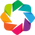

In [100]:
# Import statements

from collections import defaultdict
import concurrent.futures as cf
from datetime import datetime
import json
import random
import re
import tempfile
import warnings
from functools import lru_cache
from pathlib import Path
from typing import Optional
from urllib.request import urlopen
from zipfile import ZipFile

import missingno as msno
import cartopy.crs as ccrs
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import geoviews as gv
import geoviews.tile_sources as gts
import colorcet as cc
import holoviews as hv
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
from fiona.io import ZipMemoryFile
from pyvis.network import Network

# from sqlalchemy import create_engine
# from sqlalchemy.exc import SQLAlchemyError
from tqdm import tqdm
import dask
import dask.dataframe as dd

# from dask.diagnostics import ProgressBar
from dask.distributed import Client
import panel as pn
import panel.widgets as pnw
from panel.template import FastListTemplate

hv.extension("bokeh")
gv.extension("bokeh")
pn.extension("tabulator", template="fast", sizing_mode="stretch_width")

In [2]:
# ignore all warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 40)

In [3]:
# Test initial print statement
print("CapstoneJourney begins!")

CapstoneJourney begins!


#### Constants
Let's start by defining some constants that will be used throughout this notebook.

Most of the data was first downloaded from external websites and then uploaded onto a cloud storage bucket. This was done to ensure consistency and availability during the project. A brief description of the data and its original source link is referenced below.

## Data Sources

The following table provides an overview of the data sources used in this project:

| Dataset Name | Source URL | Original Source | Description | Date Downloaded |
|--------------|------------|-----------------|-------------|-----------------|
|RegistryUpload Table | [link](https://fracfocus.org/data-download) | FracFocus | This table contains each disclosure’s header information such as the job date, API number, location, base water volume, and total vertical depth. | 2023-11-11 |
RBDMSWells | [link](https://gisdata-occokc.opendata.arcgis.com/datasets/OCCOKC::rbdms-wells/about) | Oklahoma Corporation Commission | This table contains Oklahoma RBDMS statewide well data | 2023-11-23 |
| Wolfcamp Delaware Play Boundary | [link]((https://www.eia.gov/maps/maps.htm))| EIA | Permian Basin, Delaware Sub-Basin: Wolfcamp play boundary (9/4/2018) | 2023-11-19 |
| Wolfcamp Midland Play Boundaries | [link]((https://www.eia.gov/maps/maps.htm))| EIA | Wolfcamp A, B, C, and D play boundaries, Midland Basin (6/4/2020) | 2023-11-21 |
| ShalePlay Delaware | [link]((https://www.eia.gov/maps/maps.htm))| EIA |Delaware play boundary (10/8/2019)  | 2023-11-21 |
| AboYeso GlorietaYeso Spraberry | [link]((https://www.eia.gov/maps/maps.htm))| EIA | Abo-Yeso, Glorieta-Yeso, and Spraberry play boundaries (3/11/2016) | 2023-11-21 |
| NM SLO OilGas Leases | [link](https://www.nmstatelands.org/maps-gis/gis-data-download/)| New Mexico State Land Office | Active Oil and Gas Leases (11/07/2023) | 2023-11-21 |
| NM SLO Geologic Regions | [link]((https://www.nmstatelands.org/maps-gis/gis-data-download/))| New Mexico State Land Office | Geologic Regions (01/04/2010) | 2023-11-21 |
| NM SLO STL Status Combined | [link]((https://www.nmstatelands.org/maps-gis/gis-data-download/))| New Mexico State Land Office | New Mexico State Trust Lands By Subdivision (04/14/2022) | 2023-11-21 |
| All Layers By County | [link](https://rrc.texas.gov/resource-center/research/data-sets-available-for-download/)  | Railroad Commission of Texas | Map & Associated Data: Base Map, Wells, Surveys & Pipelines layers | 2023-11-17 |
| Oil & Gas Leases | [link](https://www.glo.texas.gov/land/land-management/gis/index.html) | Texas General Land Office | Active Leases (11/17/2023) | 2023-11-17 |
| Oil & Gas Units | [link](https://www.glo.texas.gov/land/land-management/gis/index.html) | Texas General Land Office | Active Units (11/17/2023) | 2023-11-17 |
| U.S. County Boundaries | [link](https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip) | United States Census Bureau | County (2022-10-31). Data is downloaded directly in the code. | N/A |
| U.S. County FIPS Codes | [link](https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county) | Wikipedia | List of United States FIPS codes by county. Data is downloaded directly in the code. | N/A |

Each row in the table represents a different dataset. The columns are:

- **Dataset Name**: The name of the dataset.
- **Source URL**: The URL where the dataset can be downloaded. Click on "link" to access the webpage.
- **Original Source**: The original source of the data.
- **Description**: A brief description of the dataset.
- **Date Downloaded**: The date when the dataset was downloaded.

In [4]:
# Constants
# This cell generates lists of URLs to CSV files stored in a Google Cloud Storage bucket.
# The CSV files contain data from the FracFocus Chemical Disclosure Registry.

# Generate a list of URLs to the FracFocusRegistry CSV files.
# There are 24 files in total, named FracFocusRegistry_i.csv where i ranges from 1 to 24.
DATA_URLS1 = [
    f"https://storage.googleapis.com/mrprime_dataset/fracfocus/FracFocusRegistry_{i}.csv"
    for i in range(1, 25)
]

# Generate a list of URLs to the registryupload CSV files.
# There are 3 files in total, named registryupload_i.csv where i ranges from 1 to 3.
DATA_URLS2 = [
    f"https://storage.googleapis.com/mrprime_dataset/fracfocus/registryupload_{j}.csv"
    for j in range(1, 4)
]

# URL to the readme.txt file in the bucket.
DATA_README_URL = [
    "https://storage.googleapis.com/mrprime_dataset/fracfocus/readme.txt"
]

# url to the OCC (Oklahoma) well data in th bucket
OCC_PARQUET_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/occ/rbdms_wells.parquet"

In [5]:
# Url for the shapefile for US counties from the Census Bureau's website.
CENSUS_COUNTY_MAP_URL = (
    "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
)
# Url for a Wikipedia page containing a table of FIPS codes for US counties.
FIPS_WIKI_URL = (
    "https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county"
)
# Bounds of the continental US in longitude and latitude.
USA_BOUNDS = (-124.77, 24.52, -66.95, 49.38)
# bounds of the continental US in Web Mercator coordinates.
USA_BOUNDS_MERCATOR = (-13874905.0, 2870341.0, -7453304.0, 6338219.0)

In [6]:
# url for the shapefiles of Permian Basin, Delaware Sub-Basin: Wolfcamp play boundary
WOLFCAMP_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/Wolfcamp_Delaware_Play_Boundary.zip"
MIDLAND_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/Wolfcamp_Midland_Play_Boundaries_EIA.zip"
DELAWARE_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/ShalePlay_Delaware_EIA.zip"
ABOYESO_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/ShalePlays_AboYeso_GlorietaYeso_Spraberry_EIA.zip"
# PB_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/PermianBasin_Boundary_Structural_Tectonic.zip"

basins_url_list = [
    WOLFCAMP_ZIP_URL,
    MIDLAND_ZIP_URL,
    DELAWARE_ZIP_URL,
    ABOYESO_ZIP_URL,
    # PB_ZIP_URL,
]


# url for shapefiles of Polygon data set intended to delineate active oil and gas leases on New Mexico State Trust Lands.
NM_SLO_OIL_LEASE_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/nm_slo/OilGas_Leases.zip"

# url for shapefiles of Polygon layer created to highlight general boundaries of subsurface geologic basins and uplifts of New Mexico
NM_SLO_GEO_REGION_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/nm_slo/slo_GeologicRegions.zip"
# url for shapefiles of Polygons of New Mexico State Trust Lands by PLSS subdivision (quarter-quarter, lot, tract, or partial).
NM_SLO_STL_PLSS_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/nm_slo/slo_STLStatusCombined.zip"

nm_slo_url_list = [
    NM_SLO_OIL_LEASE_URL,
    NM_SLO_GEO_REGION_URL,
]  # , NM_SLO_STL_PLSS_URL]

# Production data query for RRC website
PDQ_URL = (
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/PDQ_DSV.zip"
)

In [7]:
# Define a list of county numbers that we want to test. These numbers correspond to counties
# that we did not include in the data folder, but they do not cover all 254 counties.

# county numbers are only odd numbers
county_nums = [str(i).zfill(3) for i in range(1, 508) if i % 2]

# Generate a list of URLs to the shapefile zip files stored in a Google Cloud Storage bucket.
# The zip files are named Shp{num}.zip, where {num} is a county number from the county_nums list.
SHP_ZIP_URLS = [
    f"https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/all_layers_rrc_20231117/Shp{num}.zip"
    for num in county_nums
]

In [8]:
# url for the active leases in Texas on State land gdb
GDB_ZIP_URLS = [
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/glo/GDB_ActiveLeases.zip",
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/glo/GDB_ActiveUnits.zip",
    # "https://storage.googleapis.com/mrprime_dataset/capstone_journey/glo/GDB_InactiveLeases.zip",
]

#### Function definations
Next, let's define some functions that will be used throughout this notebook.

In [9]:
def read_csv_concurrent(urls_list):
    """Reads a list of CSV files concurrently"""
    # Create a thread pool
    with cf.ThreadPoolExecutor() as executor:
        # Use map to apply pd.read_csv to each URL
        results = list(tqdm(executor.map(pd.read_csv, urls_list), total=len(urls_list)))
    # Return the results
    return results

In [10]:
def extract_specific_gdf_from_local_zip(
    zip_paths: list[str], regex_patterns: list[str]
) -> dict[str, gpd.GeoDataFrame]:
    """
    Reads shapefiles from a list of zip files and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames.
    """
    # Initialize an empty dictionary to store the GeoDataFrames
    shp_dict = {}
    # compile the regex patterns
    patterns = [re.compile(pattern) for pattern in regex_patterns]

    # Loop over the list of zip file paths
    for zip_path in zip_paths:
        # Open the zip file
        with ZipFile(zip_path) as z:
            # Get the list of files in the zip file
            zip_contents = z.namelist()
            # Filter the list to get only the shapefiles that match any of the patterns
            shp_files = [
                f
                for f in zip_contents
                for pattern in patterns
                if pattern.search(f) and f.endswith(".shp")
            ]
            # read the shapefiles into GeoDataFrames
            for shp_file in shp_files:
                # Get the name of the shapefile
                shp_name = Path(shp_file).stem
                # Read the shapefile into a GeoDataFrame and add it to the dictionary
                shp_dict[shp_name] = gpd.read_file(f"zip://{zip_path}!{shp_file}")
    # Return the dictionary of GeoDataFrames
    return shp_dict

In [11]:
def extract_matching_shp_files_from_zip_urls(
    zip_urls: list[str], regex_patterns: list[str]
) -> dict[str, gpd.GeoDataFrame]:
    """
    Reads shapefiles from a list of zip file urls and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames.
    """
    # Initialize an empty dictionary to store the GeoDataFrames
    shp_dict = {}
    # compile the regex patterns
    patterns = [re.compile(pattern) for pattern in regex_patterns]

    # Loop over the list of zip file urls
    for zip_url in tqdm(zip_urls, desc="Processing zip files"):
        # download the zip file
        with urlopen(zip_url) as u:
            zip_data = u.read()
        # create a ZipMemoryFile from the zip data
        with ZipMemoryFile(zip_data) as z:
            # get the list of files in the zip file
            zip_files = z.listdir()
            # filter for shapefiles that match any of the patterns
            shp_files = [
                f
                for f in zip_files
                for pattern in patterns
                if pattern.search(f) and f.endswith(".shp")
            ]
            # read the shapefiles into GeoDataFrames
            for shp_file in shp_files:
                with z.open(shp_file) as f:
                    shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                        f, crs=f.crs
                    )
    # Return the dictionary of GeoDataFrames
    return shp_dict

In [12]:
def process_zip_url(
    zip_url: str, patterns: list[re.Pattern]
) -> dict[str, gpd.GeoDataFrame]:
    """Downloads a zip file url and returns a dictionary of GeoDataFrames for shapefiles that match the patterns"""
    shp_dict = {}
    with urlopen(zip_url) as u:
        zip_data = u.read()
    with ZipMemoryFile(zip_data) as z:
        zip_files = z.listdir()
        shp_files = [
            f
            for f in zip_files
            for pattern in patterns
            if pattern.search(f) and f.endswith(".shp")
        ]
        for shp_file in shp_files:
            with z.open(shp_file) as f:
                shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                    f, crs=f.crs
                )
    return shp_dict


def extract_matching_shp_files_from_zip_urls_concurrent(
    zip_urls: list[str], regex_patterns: list[str]
) -> dict[str, gpd.GeoDataFrame]:
    """Reads shapefiles from a list of zip file urls and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames."""
    shp_dict = {}
    patterns = [re.compile(pattern) for pattern in regex_patterns]
    with cf.ThreadPoolExecutor() as executor:
        future_to_url = {
            executor.submit(process_zip_url, url, patterns): url for url in zip_urls
        }
        futures = tqdm(
            cf.as_completed(future_to_url),
            total=len(future_to_url),
            desc="Processing URLs",
            dynamic_ncols=True,
        )
        for future in futures:
            shp_dict.update(future.result())
    return shp_dict

In [13]:
def concat_gdf_from_dict(gdf_dict: dict[str, gpd.GeoDataFrame]) -> gpd.GeoDataFrame:
    """
    Given a dictionary of GeoDataFrames, returns a single GeoDataFrame
    with a new column indicating the source of the data.
    """
    # use a dictionary comprehension to create a new dictionary
    gdf_data = {k: gdf.assign(source_file=k) for k, gdf in gdf_dict.items()}
    # return the concatenated GeoDataFrame
    return pd.concat(gdf_data.values(), ignore_index=True)

In [14]:
def extract_gdfs_from_zip(zip_path: str) -> Optional[dict[str, gpd.GeoDataFrame]]:
    """
    Reads shapefiles from a zip file and returns a dictionary of GeoDataFrames.
    """
    gdfs = {}
    # Open the zip file
    with ZipFile(zip_path) as z:
        # Get the list of files in the zip file
        zip_contents = z.namelist()
        # Find the shapefiles
        shp_files = [f for f in zip_contents if f.endswith(".shp")]
        for shp_file in shp_files:
            # Read the shapefile into a GeoDataFrame
            gdf = gpd.read_file(f"zip://{zip_path}!{shp_file}")
            gdfs[shp_file] = gdf

    # If no shapefile was found, return None
    return gdfs if gdfs else None

In [15]:
def extract_gdfs_from_zip_url(zip_url: str) -> Optional[dict[str, gpd.GeoDataFrame]]:
    """
    Downloads a ZIP file from a URL, reads shapefiles from the ZIP file, and returns a dictionary of GeoDataFrames.
    """
    gdfs = {}
    # Open the URL
    with urlopen(zip_url) as u:
        # Read the content of the response into a byte stream
        zip_data = u.read()
        # Open the ZIP file from the byte stream
        with ZipMemoryFile(zip_data) as z:
            # Get the list of files in the ZIP file
            zip_contents = z.listdir()
            # Find the shapefiles
            shp_files = [f for f in zip_contents if f.endswith(".shp")]
            for shp_file in shp_files:
                # Read the shapefile into a GeoDataFrame
                with z.open(shp_file) as f:
                    gdf = gpd.GeoDataFrame.from_features(f, crs=f.crs)
                gdfs[Path(shp_file).stem] = gdf

    # If no shapefile was found, return None
    return gdfs if gdfs else None

In [16]:
def process_shp_url(zip_url: str):
    """Downloads a zip file url and returns a dictionary of GeoDataFrames for shapefiles that match the patterns"""
    shp_dict = {}
    with urlopen(zip_url) as u:
        zip_data = u.read()
    with ZipMemoryFile(zip_data) as z:
        zip_files = z.listdir()
        shp_files = [f for f in zip_files if f.endswith(".shp")]
        for shp_file in shp_files:
            with z.open(shp_file) as f:
                shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                    f, crs=f.crs
                )
    return shp_dict


def extract_gdfs_from_zip_url_concurrent(
    zip_urls: list[str],
) -> dict[str, gpd.GeoDataFrame]:
    """Reads shapefiles from a list of zip file urls and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames."""
    shp_dict = {}
    with cf.ThreadPoolExecutor() as executor:
        future_to_url = {executor.submit(process_shp_url, url): url for url in zip_urls}
        futures = tqdm(
            cf.as_completed(future_to_url),
            total=len(future_to_url),
            desc="Processing URLs",
            dynamic_ncols=True,
        )
        for future in futures:
            shp_dict.update(future.result())
    return shp_dict

In [17]:
def read_gdb_from_zip(gdb_zips_list: list[str]):
    """Reads a list of zip files containing geodatabases and returns a dictionary of GeoDataFrames"""
    # initialize an empty dictionary
    gdb_dict = {}
    # loop through each zip file
    for gdb_zip in gdb_zips_list:
        with ZipFile(gdb_zip, "r") as z:
            # get list of files in zip
            files = z.namelist()
            # filter for gdb folders
            gdb_folders = [f for f in files if f.endswith(".gdb/")]
            # if there is a gdb folder in the zip file
            if gdb_folders:
                # get it and read it into a GeoDataFrame
                gdb_folder = gdb_folders[0]
                gdb_dict[Path(gdb_folder).stem] = gpd.read_file(
                    f"zip://{gdb_zip}!{gdb_folder}"
                ).to_crs("EPSG:4269")
    # return the dictionary of GeoDataFrames
    return gdb_dict

In [18]:
def read_gdb_from_zip_url(gdb_urls_list: list[str]):
    """Reads a list of zip file urls containing geodatabases and returns a dictionary of GeoDataFrames"""
    # initialize an empty dictionary
    gdb_dict = {}
    # loop through each zip file
    for gdb_url in gdb_urls_list:
        # create a temporary directory
        with tempfile.TemporaryDirectory() as tmp_dir:
            # download the zip file
            with urlopen(gdb_url) as u, open(f"{tmp_dir}/data.zip", "wb") as f_out:
                f_out.write(u.read())
            # extract the zip file
            with ZipFile(f"{tmp_dir}/data.zip", "r") as zip_ref:
                zip_ref.extractall(tmp_dir)
            # get the list of extracted files
            extracted_files = list(Path(tmp_dir).iterdir())
            # filter for gdb folders
            gdb_folders = [f for f in extracted_files if f.suffix == ".gdb"]
            # if there is a gdb folder in the extracted files
            if gdb_folders:
                # get it and read it into a GeoDataFrame
                gdb_folder = gdb_folders[0]
                gdb_dict[Path(gdb_folder).stem] = gpd.read_file(gdb_folder).to_crs(
                    "EPSG:4269"
                )
    # return the dictionary of GeoDataFrames
    return gdb_dict

In [19]:
def process_gdb_url(gdb_url):
    """Downloads a zip file url containing a geodatabase and returns a GeoDataFrame"""
    with tempfile.TemporaryDirectory() as tmp_dir:
        # download the zip file
        with urlopen(gdb_url) as u, open(f"{tmp_dir}/data.zip", "wb") as f_out:
            f_out.write(u.read())
        # extract the zip file
        with ZipFile(f"{tmp_dir}/data.zip", "r") as zip_ref:
            zip_ref.extractall(tmp_dir)
        # get the list of extracted files
        extracted_files = list(Path(tmp_dir).iterdir())
        # filter for gdb folders
        gdb_folders = [f for f in extracted_files if f.suffix == ".gdb"]
        # if there is a gdb folder in the extracted files
        if gdb_folders:
            # get it and read it into a GeoDataFrame
            gdb_folder = gdb_folders[0]
            return Path(gdb_folder).stem, gpd.read_file(gdb_folder)


def read_gdb_from_zip_url_concurrent(gdb_urls_list: list[str]):
    """Reads a list of zip file urls containing geodatabases and returns a dictionary of GeoDataFrames"""
    # initialize an empty dictionary
    gdb_dict = {}
    # create a ThreadPoolExecutor
    with cf.ThreadPoolExecutor() as executor:
        # submit the process_gdb_url function for each url and gather the results
        future_to_url = {
            executor.submit(process_gdb_url, url): url for url in gdb_urls_list
        }
        for future in cf.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                key, data = future.result()
                gdb_dict[key] = data
            except Exception as exc:
                print(f"{url} generated an exception: {exc}")
    # return the dictionary of GeoDataFrames
    return gdb_dict

In [20]:
# Function definitions
def pascal_to_snake(name: str):
    """Converts a string from PascalCase to snake_case"""
    # (?<=[A-Za-z0-9]) - positive lookbehind for any alphanumeric character
    # (?=[A-Z][a-z]) - positive lookahead for any uppercase followed by lowercase
    pattern = re.compile(r"(?<=[A-Za-z0-9])(?=[A-Z][a-z])")
    name = pattern.sub("_", name).lower()
    return name

In [21]:
def plot_statistics_table_nonmissing_hbar(df):
    # Calculate the percentage of non-missing values in each column
    missing_data_percent = (df.notnull().mean()).rename("Percent")

    # Create a DataFrame of the counts of non-missing values
    if isinstance(df, dd.DataFrame):
        non_missing_count, missing_data_percent = dask.compute(
            df.count().rename("Count"), (missing_data_percent * 100)
        )
    else:
        missing_data_percent = missing_data_percent * 100
        non_missing_count = df.notnull().sum().rename("Count")

    # Concatenate the two DataFrames along the columns
    non_missing_data = pd.concat([missing_data_percent, non_missing_count], axis=1)

    # Create a horizontal bar plot of the percentage of non-missing data
    hbar_plot = non_missing_data.hvplot.barh(
        y="Percent",
        width=800,
        height=600,
        title="Percentage of Non-Missing Data in Each Column",
        ylabel="",
        xlabel="",
        xaxis="bare",
        hover_cols="all",
    ).opts(
        active_tools=["box_zoom"],
        toolbar="above",
    )

    return hbar_plot

In [22]:
def unify_crs(
    dataframe: pd.DataFrame,
    lon_col: str = "longitude",
    lat_col: str = "latitude",
    crs_col: str = "crs",
    final_crs: str = "EPSG:4269",
):
    """
    Given a DataFrame with lon/lat or x/y coordinates,
    converts the coordinates to a unified crs and combines
    into a single GeoDataframe with a geometry column.
    """

    # Define the main columns that will be used for the conversion
    main_cols = [lon_col, lat_col, crs_col]

    # Get the other columns in the dataframe
    other_cols = list(set(dataframe.columns) - set(main_cols))

    # Create a subframe with only the main columns
    subframe = dataframe[main_cols]

    # Create a list of GeoDataFrames, each with a different CRS
    geo_dfs = [
        gpd.GeoDataFrame(
            # Use the data for this CRS
            data=data,
            # Create a geometry column from the lon/lat columns
            geometry=gpd.points_from_xy(x=data[lon_col].values, y=data[lat_col].values),
            # Set the CRS for this GeoDataFrame
            crs=pyproj.CRS(crs_val),
            # Convert the GeoDataFrame to the final CRS
        ).to_crs(final_crs)
        # Do this for each unique CRS in the subframe
        for crs_val, data in subframe.groupby(crs_col)
    ]

    # Merge the GeoDataFrames back together and return the result
    return pd.merge(
        # Concatenate the GeoDataFrames
        pd.concat(geo_dfs, sort=True),
        # Add the other columns back in
        dataframe[other_cols],
        # Merge on the index
        left_index=True,
        right_index=True,
    )

In [23]:
# @lru_cache(maxsize=3)
def get_background_map(bgcolor="black", alpha=0.5):
    """Returns a GeoViews background map"""
    return gts.CartoLight().opts(bgcolor=bgcolor, alpha=alpha)


def platecaree_to_mercator_vectorised(x, y):
    """Use Cartopy to convert PlateCarree coordinates to Mercator"""
    return ccrs.GOOGLE_MERCATOR.transform_points(ccrs.PlateCarree(), x, y)[:, :2]

In [24]:
def format_in_000(num):
    """Formats a number in thousands"""
    for unit in ["", "thousand", "million", "billion", "trillion"]:
        if abs(num) < 1000.0:
            return f"{num:3.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} quadrillion"

In [25]:
def split_datetime(df, column):
    """Splits a datetime column into year, month, and day columns"""
    # remove '_date' from the column name
    column_stem = column.replace("_date", "") if "_date" in column else column
    try:
        datetime_series = pd.to_datetime(df[column], errors="coerce")
        if datetime_series.isna().any():
            print(f"Errors occurred during conversion of column {column}.")
        df[column_stem + "_year"] = datetime_series.dt.year
        df[column_stem + "_month"] = datetime_series.dt.month
        df[column_stem + "_day"] = datetime_series.dt.day
    except KeyError:
        print(f"Column {column} not found in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")

### Load data

First dataset is from FracFocus. There is also a readme file which contains the data dictionary for the dataset. Let's have a look at both.

Readme file with data dictionary

In [ ]:
# get readme data
readme = urlopen(DATA_README_URL[0]).read().decode("windows-1252")
display(readme)

In [ ]:
# print function goes beyond 'hello world' and takes care of the escape characters
print(readme)

In [221]:
# We can collect all the dataframe into a list and then concatenate them
df_list = read_csv_concurrent(DATA_URLS2)


dfs = pd.concat(df_list).reset_index(drop=True)

100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


In [222]:
registry_df = pd.DataFrame()
registry_df = dfs.copy()
registry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213883 entries, 0 to 213882
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pKey                     213883 non-null  object 
 1   JobStartDate             213868 non-null  object 
 2   JobEndDate               213883 non-null  object 
 3   APINumber                213883 non-null  object 
 4   StateNumber              213883 non-null  int64  
 5   CountyNumber             213883 non-null  int64  
 6   OperatorName             213883 non-null  object 
 7   WellName                 213883 non-null  object 
 8   Latitude                 213883 non-null  float64
 9   Longitude                213883 non-null  float64
 10  Projection               213883 non-null  object 
 11  TVD                      183743 non-null  float64
 12  TotalBaseWaterVolume     183714 non-null  float64
 13  TotalBaseNonWaterVolume  163574 non-null  float64
 14  Stat

Looking at the missing values it is interesting to see that most missing values are from the `TVD`, `TotalBaseWaterVolume` and `TotalBaseNonWaterVolume`. One reason for this may be found in the data limitations on terms of use on the FracFocus website. It states:
-  Disclosures submitted using the FracFocus 1.0 format (January, 2011 to May 31, 2013) will contain only header data. 
-  Disclosures submitted using the FracFocus 2.0 format (November 2012 to present) will contain both header and chemical data. NOTE: Between November, 2012 and May 31, 2013 disclosures in both 1.0 and 2.0 formats were submitted to the system. 
-  After May 31, 2013 only disclosures submitted in the 2.0 format were accepted.
-  Data submitted appears as it was submitted by the operator or operator’s authorized agent. FracFocus does not warrant the data in any way.

In [ ]:
# plot the missing data
plot_statistics_table_nonmissing_hbar(registry_df)

In [ ]:
# Calculate the percentage of non-missing values in each column
missing_data_percent = (registry_df.notna().mean() * 100).rename("Percent")

# Create a DataFrame of the counts of non-missing values
non_missing_count = registry_df.notna().sum().rename("Count")

# Concatenate the two DataFrames along the columns
non_missing_data = pd.concat([missing_data_percent, non_missing_count], axis=1)

# Create a horizontal bar plot of the percentage of non-missing data
barh_plot = non_missing_data.hvplot.barh(
    y="Percent",
    width=800,
    height=600,
    title="Percentage of Non-Missing Data in Each Column",
    ylabel="",
    xlabel="",
    xaxis="bare",
    hover_cols="all",
).opts(
    active_tools=["box_zoom"],
    toolbar="above",
)

barh_plot

In [ ]:
# Look at some of the rows of the dataframe
display(registry_df.head(3))
display(registry_df.sample(5, random_state=628))
display(registry_df.tail(3))

From our first look at a few sample rows some things stick out immediately.
1. The dataset may be in chronological order and the values of the `JobStartDate`/`JobEndDate` at both of the extremes may be incorrect.
2. There may be an abundance for `StateNumber` `42` if 4 out of the 5 draws of the 200k+ rows drawn at random had a `StateNumber` of `42`.



### Data Cleaning

Before we jump into cleaning the data in the columns, let's make the columns look more pythonic by changing the column names to snake_case.


In [223]:
registry_df.columns = [pascal_to_snake(col) for col in registry_df.columns]
registry_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213883 entries, 0 to 213882
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   p_key                        213883 non-null  object 
 1   job_start_date               213868 non-null  object 
 2   job_end_date                 213883 non-null  object 
 3   api_number                   213883 non-null  object 
 4   state_number                 213883 non-null  int64  
 5   county_number                213883 non-null  int64  
 6   operator_name                213883 non-null  object 
 7   well_name                    213883 non-null  object 
 8   latitude                     213883 non-null  float64
 9   longitude                    213883 non-null  float64
 10  projection                   213883 non-null  object 
 11  tvd                          183743 non-null  float64
 12  total_base_water_volume      183714 non-null  float64
 13 

Next, we can remove the columns with only null values. These are the last 2 columns in the dataframe, `source` and `dtmod`. Also we can drop the `total_non_base_water_volume` column since we may not have much need for it.


In [224]:
registry_df = registry_df.drop(
    columns=["source", "dtmod", "total_base_non_water_volume"]
)
registry_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213883 entries, 0 to 213882
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   p_key                    213883 non-null  object 
 1   job_start_date           213868 non-null  object 
 2   job_end_date             213883 non-null  object 
 3   api_number               213883 non-null  object 
 4   state_number             213883 non-null  int64  
 5   county_number            213883 non-null  int64  
 6   operator_name            213883 non-null  object 
 7   well_name                213883 non-null  object 
 8   latitude                 213883 non-null  float64
 9   longitude                213883 non-null  float64
 10  projection               213883 non-null  object 
 11  tvd                      183743 non-null  float64
 12  total_base_water_volume  183714 non-null  float64
 13  state_name               213881 non-null  object 
 14  coun

Next, we will fix some of the dtypes of the columns.
- Both the `job_start_date` and the `job_end_date` columns are object dtypes, so we will convert those to datetime dtypes and drop the timestamp.
- We can also separate out the date components into its various components. This may come in handy for feature engineering later on.
- The `projection` column is an object dtype. That can be converted to a string dtype and shorten to `crs` as it represents the Cooordinate Reference System used in the `latitude` and `longitude` columns values. We can dig into what CRS is later on.
- The `federal_well` and `indian_well` columns are both boolean type columns. They may be more aptly named as `is_federal_well` and `is_indian_well` respectively.

In [225]:
# Use the function on 'job_start_date' and 'job_end_date'
split_datetime(registry_df, "job_start_date")
split_datetime(registry_df, "job_end_date")
registry_df[[col for col in registry_df.columns if re.search("start|end", col)]].info(
    memory_usage="deep"
)
# show the values which are null still
registry_df[
    registry_df[[col for col in registry_df.columns if re.search("start|end", col)]]
    .isna()
    .any(axis=1)
].shape

Errors occurred during conversion of column job_start_date.
Errors occurred during conversion of column job_end_date.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213883 entries, 0 to 213882
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   job_start_date   213868 non-null  object 
 1   job_end_date     213883 non-null  object 
 2   job_start_year   213866 non-null  float64
 3   job_start_month  213866 non-null  float64
 4   job_start_day    213866 non-null  float64
 5   job_end_year     213882 non-null  float64
 6   job_end_month    213882 non-null  float64
 7   job_end_day      213882 non-null  float64
dtypes: float64(6), object(2)
memory usage: 41.4 MB


(17, 24)

In [226]:
# Convert 'job_start_date' to datetime format and format it as 'YYYY-MM-DD'
registry_df["job_start_date"] = pd.to_datetime(
    registry_df["job_start_date"], errors="coerce"
).dt.strftime("%Y-%m-%d")

# Convert 'job_end_date' to datetime format and format it as 'YYYY-MM-DD'
registry_df["job_end_date"] = pd.to_datetime(
    registry_df["job_end_date"], errors="coerce"
).dt.strftime("%Y-%m-%d")

# drop rows with null values in 'job_start_date' and 'job_end_date'
# registry_df = registry_df.dropna(subset=["job_start_date", "job_end_date"])


# Rename some columns for clarity
registry_df.rename(
    columns={
        "federal_well": "is_federal_well",
        "indian_well": "is_indian_well",
        "projection": "crs",
    },
    inplace=True,
)

# Display the information of the DataFrame
registry_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213883 entries, 0 to 213882
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   p_key                    213883 non-null  object 
 1   job_start_date           213866 non-null  object 
 2   job_end_date             213882 non-null  object 
 3   api_number               213883 non-null  object 
 4   state_number             213883 non-null  int64  
 5   county_number            213883 non-null  int64  
 6   operator_name            213883 non-null  object 
 7   well_name                213883 non-null  object 
 8   latitude                 213883 non-null  float64
 9   longitude                213883 non-null  float64
 10  crs                      213883 non-null  object 
 11  tvd                      183743 non-null  float64
 12  total_base_water_volume  183714 non-null  float64
 13  state_name               213881 non-null  object 
 14  coun

Next, we will look at the `api_number` column.
We learned from the read me that 
> APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: 
> - First two digits represent the state, 
> - second three digits represent the county, 
> - third 5 digits represent the well.

Theoretically, we could just grab the first two characters of the `APINnumber` and use that as the state number according to the definition of the `APINumber` above. Actually, that would not be a good idea, and here is why.<br>
Although the column was called `APINumber`, it is not actually a number, so if it starts with a leading `0` that first character `0`, cannot be omitted from the value. Let's look at some of the rows with a single digit state numbers.

Right now, 
- the `api_number` column is an object dtype, but a better option would be a `string` dtype, as `object` dtype can be mixed . We can also shorten that column name to `api`.
- the `state_number` column and the `county_number` column are both `int64` dtypes right now. `string` type may be a stronger option.
- `state_code` and `county_code` may be better names for the `state_number` and `county_number` columns respectively.


In [ ]:
# rows where the state_number is a single digit
registry_df[
    (registry_df["state_number"] == 3) | (registry_df["state_number"] == 5)
].sample(5, random_state=628)

Some rows' `api_number` values have leading `0`, which is correct, but some do not. The rows without the leading `0` though are 13 characters long instead of 14. Maybe we can just add a leading `0` where needed until all API number values are 14 characters long. 

In [ ]:
# Check the number of characters in the api_number column
registry_df["api_number"].astype("string").str.len().value_counts()

Most are 14 characters long, but some are 13 characters long, like the ones we saw above without the leading `0`. Let's assume the ones with 13 characters are missing the leading `0` and not something else.

In [227]:
# Convert 'api' to string and pad it with zeros to make it 14 characters long
registry_df["api"] = registry_df["api_number"].astype("string").str.zfill(14)

# Convert 'state_number' to string and pad it with zeros to make it 2 characters long
registry_df["state_code"] = registry_df["state_number"].astype("string").str.zfill(2)

# Convert 'county_number' to string and pad it with zeros to make it 3 characters long
registry_df["county_code"] = registry_df["county_number"].astype("string").str.zfill(3)

In [228]:
# check which rows may have the api with the first two digits not matching the state number
api_state_mismatch_mask = registry_df["state_code"] != registry_df["api"].str[0:2]
# api_state_mismatch_mask

In [ ]:
# check which rows may have the api with the first two digits not matching the state number
registry_df[api_state_mismatch_mask][
    ["api_number", "api", "state_code", "state_name", "county_code", "county_name"]
]

We expected to get 2 rows here, since we checked the length of the `api_number` column above we saw that 1 row had 10 and another row had 12 characters. It is only two rows, so this may be an easy fix.

In [229]:
# Remove leading zeros and pad to 14 digits on mismatches
registry_df.loc[api_state_mismatch_mask, "api"] = (
    registry_df.loc[api_state_mismatch_mask, "api"].str.lstrip("0").str.ljust(14, "0")
)

In [ ]:
# check which rows may have the api with the first two digits not matching the state number
registry_df[api_state_mismatch_mask][
    ["api_number", "api", "state_code", "state_name", "county_code", "county_name"]
]

In [230]:
# check which rows may have the api with the 3-5 digits not matching the county number
api_county_mismatch_mask = registry_df["county_code"] != registry_df["api"].str[2:5]
registry_df[api_county_mismatch_mask]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code


State name should not have more than 50 possible values, given that there are only 50 states in the US. If we were to check the number of unique values in the `state_name` column, we would see 95. This is due to the variation in the way the `state_name` value is entered. Although not as obvious, we can assume the same for the `county_name` column. Luckily, the `api` includes both the `state_number` and the `county_number`. With this we can do 
1. data validation ensuring that these corresponding columns match
2. Ensure that the `state_name` and the `county_name` columns are correct. Important to note that 
> The state codes used in an API number are DIFFERENT from another standard which is the Federal Information Processing Standard (FIPS) state code established in 1987 by NIST. ([source](https://en.wikipedia.org/wiki/API_well_number#State_code))

In [ ]:
print(
    f'Number of different values in state_name column: {registry_df["state_name"].nunique()}'
)
print(
    f'Number of different values in state_number column: {registry_df["state_number"].nunique()}'
)

In [231]:
# group by state_code and find the mode of the state_name
state_code_mode = (
    registry_df.groupby("state_code")["state_name"]
    .apply(lambda x: x.mode().iloc[0])
    .reset_index()
)
state_code_mode = state_code_mode.rename(columns={"state_name": "state"})
state_code_mode

,state_code,state
0,01,Alabama
1,03,Arkansas
2,04,California
3,05,Colorado
4,11,Idaho
5,12,Illinois
6,13,Indiana
7,15,Kansas
8,16,Kentucky
9,17,Louisiana


In [232]:
registry_df = registry_df.merge(state_code_mode.rename(columns={"state_name": "state"}))
registry_df.sample(3, random_state=628)

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state
192605,d45ffa9c-25cc-42a3-92ab-09fcc74d032f,2018-11-13,2018-11-18,35083244260000,35,83,"chisholm Oil and Gas Operating, LLC",King Ranch #18-4-32 1H,36.000705,-97.653121,NAD27,6569.0,12481014.0,Oklahoma,Logan,3,False,False,2018.0,11.0,13.0,2018.0,11.0,18.0,35083244260000,35,083,Oklahoma
286,e3a3d6d1-d409-4e7c-ad57-703cbff32eef,2011-02-14,2011-02-14,42097341930000,42,97,"EOG Resources, Inc.",Herbert Unit #3H,33.536889,-97.474433,NAD27,NaN,NaN,Texas,Cooke,1,False,False,2011.0,2.0,14.0,2011.0,2.0,14.0,42097341930000,42,097,Texas
47360,702c7c38-053f-4b28-930d-b75fd0d1623d,2014-12-07,2015-01-07,42255337360000,42,255,Encana Oil & Gas (USA) Inc.,Charger 9H,29.037556,-97.934511,NAD27,10395.0,14672682.0,Texas,Karnes,2,False,False,2014.0,12.0,7.0,2015.0,1.0,7.0,42255337360000,42,255,Texas


We will focus our efforts in the most recent 10 years. Although more data is usually better, data too far in the past may distract whatever model we may build since unconventional drilling practices have really taken over the industry. We will also put our focus in one specific area, the Permian Basin. The Permian Basin has been instrumental in the shale boom transformation and is the most active area of exploration and production in the US presently. 

In [233]:
# create mask for from 2013 onwards
post_2012_mask = registry_df["job_start_date"] >= "2013-01-01"
registry_df_post_2012 = registry_df[post_2012_mask].copy()

# find all the rows with null values
null_mask = registry_df_post_2012.isna().any(axis=1)
registry_df_post_2012[null_mask]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state
61454,7534cb0b-9f85-4ca2-a21c-31be328456f8,2017-04-10,2017-04-10,42173374020000,42,173,"Cinnabar Energy, LTD.",Thomas 4101HD,31.996472,-101.568598,NAD27,9310.00,NaN,Texas,Glasscock,3,False,False,2017.0,4.0,10.0,2017.0,4.0,10.0,42173374020000,42,173,Texas
61965,c57e59c6-d132-4a13-bb0b-8fb3e58ce918,2017-05-08,2017-05-08,42077352710000,42,77,Lane Operating Company,Dillard A Unit No. 1,33.591273,-98.138934,NAD27,4600.00,NaN,Texas,Clay,3,False,False,2017.0,5.0,8.0,2017.0,5.0,8.0,42077352710000,42,077,Texas
62626,a2ad142e-6a38-44ed-8ebc-8572e43236b7,2017-06-13,2017-06-13,42237401310000,42,237,"Blakenergy Operating, LLC",Garner #2,33.434316,-98.227896,NAD27,6350.00,NaN,Texas,Jack,3,False,False,2017.0,6.0,13.0,2017.0,6.0,13.0,42237401310000,42,237,Texas
84840,fcbf3967-867e-4e4e-af18-d83e7a82c604,2020-04-19,2020-04-19,42461378800000,42,461,COG Operating LLC,Powell 36 7,31.523085,-102.118329,NAD27,NaN,NaN,Texas,Upton,1,False,False,2020.0,4.0,19.0,2020.0,4.0,19.0,42461378800000,42,461,Texas
89052,ead37751-a53f-4ed9-99df-8cac1ebf1e15,2021-05-23,2021-05-23,42173346750000,42,173,Berry Petroleum,Talon #4,31.950785,-101.775302,NAD83,NaN,NaN,Texas,Glasscock,1,False,False,2021.0,5.0,23.0,2021.0,5.0,23.0,42173346750000,42,173,Texas
89305,4753a32e-39cb-4994-b69b-8acb36597463,2021-06-08,2021-06-08,42115334560000,42,115,Pioneer Natural Resources,Echols 10 #1,32.531683,-102.096109,NAD27,NaN,NaN,Texas,Dawson,1,False,False,2021.0,6.0,8.0,2021.0,6.0,8.0,42115334560000,42,115,Texas
98083,b76c7cc4-f1c1-4711-9168-ba819f41d070,2022-10-16,2022-10-27,42479446890000,42,479,Lewis Energy Group,HAMILTON NO. 34H,27.958510,-99.567909,WGS84,10456.00,NaN,Texas,Webb,3,False,False,2022.0,10.0,16.0,2022.0,10.0,27.0,42479446890000,42,479,Texas
98087,99463560-ccb5-4c07-9537-8abdc731208b,2022-10-16,2022-10-27,42479446880000,42,479,Lewis Energy Group,HAMILTON NO. 33H,27.958510,-99.567956,WGS84,10437.00,NaN,Texas,Webb,3,False,False,2022.0,10.0,16.0,2022.0,10.0,27.0,42479446880000,42,479,Texas
139253,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,2022-05-28,2022-06-08,33610338000000,33,610,Hunt Oil Company,TRULSON 156-90-11-14H-3,48.355506,-102.212124,NAD83,8872.40,13496802.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,8.0,33610338000000,33,610,North Dakota
139256,6e5d8284-29d1-4b3d-a72c-729d95c327de,2022-05-28,2022-06-09,33610338100000,33,610,Hunt Oil Company,PALERMO 156-90-2-31H-5,48.355506,-102.212330,NAD83,8782.65,14820967.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,9.0,33610338100000,33,610,North Dakota


See how many nans we still have in each column.

In [251]:
registry_df_post_2012.info(memory_usage="deep")
registry_df_post_2012.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 174264 entries, 18356 to 213882
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   p_key                    174264 non-null  object 
 1   job_start_date           174264 non-null  object 
 2   job_end_date             174264 non-null  object 
 3   api_number               174264 non-null  object 
 4   state_number             174264 non-null  int64  
 5   county_number            174264 non-null  int64  
 6   operator_name            174264 non-null  object 
 7   well_name                174264 non-null  object 
 8   latitude                 174264 non-null  float64
 9   longitude                174264 non-null  float64
 10  crs                      174264 non-null  object 
 11  tvd                      174261 non-null  float64
 12  total_base_water_volume  174254 non-null  float64
 13  state_name               174264 non-null  object 
 14  count

p_key                       0
job_start_date              0
job_end_date                0
api_number                  0
state_number                0
county_number               0
operator_name               0
well_name                   0
latitude                    0
longitude                   0
crs                         0
tvd                         3
total_base_water_volume    10
state_name                  0
county_name                 4
ff_version                  0
is_federal_well             0
is_indian_well              0
job_start_year              0
job_start_month             0
job_start_day               0
job_end_year                0
job_end_month               0
job_end_day                 0
api                         0
state_code                  0
county_code                 0
state                       0
well                        0
dtype: int64

Looking at the `county_number` for the rows with a nan value in the `county_name` column, we can see why there is a nan for the `county_name`. Those numbers are most likely incorrect as small states like `North Dakota` and `Arkansas` do not have large `county_number` values. However we can still try to impute what the correct values by cross referencing with other sources or by using the `latitude` and `longitude` values.


In [252]:
# the rows with a null value for the county_name column
registry_df_post_2012[registry_df_post_2012["county_name"].isna()]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
139253,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,2022-05-28,2022-06-08,33610338000000,33,610,Hunt Oil Company,TRULSON 156-90-11-14H-3,48.355506,-102.212124,NAD83,8872.40,13496802.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,8.0,33610338000000,33,610,North Dakota,TRULSON 156-90-11-14H-3
139256,6e5d8284-29d1-4b3d-a72c-729d95c327de,2022-05-28,2022-06-09,33610338100000,33,610,Hunt Oil Company,PALERMO 156-90-2-31H-5,48.355506,-102.212330,NAD83,8782.65,14820967.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,9.0,33610338100000,33,610,North Dakota,PALERMO 156-90-2-31H-5
178445,692d9381-748e-4e5f-b83f-30f868f18882,2019-11-19,2019-11-19,03729439000000,3,729,WFD Oil Corporation,Vanorsdale,0.123455,-0.123450,NAD27,2442.00,22134.0,Arkansas,NaN,3,False,False,2019.0,11.0,19.0,2019.0,11.0,19.0,03729439000000,03,729,Arkansas,Vanorsdale
206589,87ea1a50-ab40-4956-8051-d39bf139ae53,2020-11-11,2020-12-01,43317428660000,43,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #133,32.409144,-101.808518,NAD83,8262.00,17519292.0,Utah,NaN,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,43317428660000,43,317,Utah,Rhea 1-6 Unit 1 #133


In [253]:
# get the index of one of the rows with a null value for the county_name column (3rd one down)
index_vanorsdale = registry_df_post_2012.query("api_number == '03729439000000'").index

#### Oklahoma Commission Corporation (OOC)

With some search engine investigating, we can learn that WFD Oil Corporation is a PC in Oklahoma. We also learn that the well name is `VANORSDOL` ,the well number is `#1-29`, and the API number is `3503729439` `0000`. We can correct some of the data which was entered incorrectly in FracFocus.

The data are looking for is in this markdown cell so we can manually input it in but we will do it through code instead. We will query the api number in the data we have on the wells in OK.

| Column Name | Value |
| --- | --- |
API	|3503729439
WELL_NAME|	VANORSDOL
WELL_NUM|	#1-29
OPERATOR|	WFD OIL CORPORATION
WELLSTATUS|	AC
WELLTYPE|	OIL
SH_LAT	|35.749381
SH_LON	|-96.370355
COUNTY	|CREEK


In [254]:
# When reading the Parquet file
occ_wells = pd.read_parquet(OCC_PARQUET_URL)
# Convert the WKT column back to a geometry column
occ_wells["geometry"] = occ_wells["geometry"].apply(lambda x: wkt.loads(x))


# Convert the DataFrame to a GeoDataFrame, specifying the CRS
occ_wells = gpd.GeoDataFrame(
    occ_wells, geometry="geometry", crs=occ_wells["crs"].iloc[0]
)
occ_wells.info()
# look at 1 sample row of the dataframe
occ_wells.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 445575 entries, 0 to 445574
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   objectid           445575 non-null  int64   
 1   api                445575 non-null  float64 
 2   well_browse_link   445575 non-null  object  
 3   well_records_docs  445575 non-null  object  
 4   well_name          445568 non-null  object  
 5   well_num           445570 non-null  object  
 6   operator           445575 non-null  object  
 7   wellstatus         443813 non-null  object  
 8   welltype           365021 non-null  object  
 9   symbol_class       445575 non-null  object  
 10  sh_lat             437073 non-null  float64 
 11  sh_lon             437073 non-null  float64 
 12  county             445575 non-null  object  
 13  section            445454 non-null  float64 
 14  township           445450 non-null  object  
 15  range              445575 

,objectid,api,well_browse_link,well_records_docs,well_name,well_num,operator,wellstatus,welltype,symbol_class,sh_lat,sh_lon,county,section,township,range,qtr4,qtr3,qtr2,qtr1,pm,footage_ew,ew,footage_ns,ns,geometry,crs
191617,191618,3.508103e+09,http://wellbrowse.occ.ok.gov/Webforms/WellInfo...,https://public.occ.ok.gov/OGCDWebLink/Search.a...,DETHLOFF,#1,OTC/OCC NOT ASSIGNED,PA,None,PLUGGED,35.915783,-96.716741,LINCOLN,25.0,17N,05E,None,NW,SE,SE,IM,0.0,None,0.0,None,POINT (-96.71674 35.91578),EPSG:4326


In [255]:
# Convert the 'api' column to string
occ_wells["api"] = occ_wells["api"].astype("int64").astype("string")
occ_wells.sample()

,objectid,api,well_browse_link,well_records_docs,well_name,well_num,operator,wellstatus,welltype,symbol_class,sh_lat,sh_lon,county,section,township,range,qtr4,qtr3,qtr2,qtr1,pm,footage_ew,ew,footage_ns,ns,geometry,crs
300977,300978,3511704387,http://wellbrowse.occ.ok.gov/Webforms/WellInfo...,https://public.occ.ok.gov/OGCDWebLink/Search.a...,ROY DAWSON,#1,OTC/OCC NOT ASSIGNED,PA,DRY,PLUGGED,36.40478,-96.864041,PAWNEE,10.0,22N,04E,None,NE,NE,NW,IM,0.0,None,0.0,None,POINT (-96.86404 36.40478),EPSG:4326


In [256]:
# make a copy of the well_name column
registry_df_post_2012["well"] = registry_df_post_2012["well_name"].copy()

In [257]:
registry_df_post_2012[registry_df_post_2012["api"].str.contains("11533124")]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well


In [258]:
# query the well_name column for 'vanors
# occ_wells[occ_wells["well_name"].str.contains("vanors", case=False, na=False)]
vanorsdol_row = occ_wells.query(
    'well_name.fillna("").str.contains("vanors", case=False) & (api == "3503729439")',
)[
    [
        "api",
        "well_name",
        "well_num",
        "operator",
        "sh_lat",
        "sh_lon",
        "county",
    ]
].rename(
    columns={"sh_lat": "latitude", "sh_lon": "longitude"}
)
vanorsdol_row["well"] = (
    vanorsdol_row["well_name"].str.title()
    + " "
    + vanorsdol_row["well_num"].astype("string")
)
index_vanorsdol = vanorsdol_row.index

columns_to_replace = ["api", "well", "latitude", "longitude"]
for col in columns_to_replace:
    registry_df_post_2012.loc[index_vanorsdale, col] = vanorsdol_row.loc[
        index_vanorsdol, col
    ].values

# check that the values have been replaced
registry_df_post_2012.loc[index_vanorsdale, columns_to_replace]

,api,well,latitude,longitude
178445,3503729439,Vanorsdol #1-29,35.749381,-96.370355


In [259]:
# adjust the api column to 14 characters again
registry_df_post_2012["api"] = registry_df_post_2012["api"].str.ljust(14, "0")

registry_df_post_2012[registry_df_post_2012["county_name"].isna()]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
139253,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,2022-05-28,2022-06-08,33610338000000,33,610,Hunt Oil Company,TRULSON 156-90-11-14H-3,48.355506,-102.212124,NAD83,8872.40,13496802.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,8.0,33610338000000,33,610,North Dakota,TRULSON 156-90-11-14H-3
139256,6e5d8284-29d1-4b3d-a72c-729d95c327de,2022-05-28,2022-06-09,33610338100000,33,610,Hunt Oil Company,PALERMO 156-90-2-31H-5,48.355506,-102.212330,NAD83,8782.65,14820967.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,9.0,33610338100000,33,610,North Dakota,PALERMO 156-90-2-31H-5
178445,692d9381-748e-4e5f-b83f-30f868f18882,2019-11-19,2019-11-19,03729439000000,3,729,WFD Oil Corporation,Vanorsdale,35.749381,-96.370355,NAD27,2442.00,22134.0,Arkansas,NaN,3,False,False,2019.0,11.0,19.0,2019.0,11.0,19.0,35037294390000,03,729,Arkansas,Vanorsdol #1-29
206589,87ea1a50-ab40-4956-8051-d39bf139ae53,2020-11-11,2020-12-01,43317428660000,43,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #133,32.409144,-101.808518,NAD83,8262.00,17519292.0,Utah,NaN,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,43317428660000,43,317,Utah,Rhea 1-6 Unit 1 #133


Now, with `latitude` and `longitude` coordinates for all 4 rows with missing `county_name`, let's find out which counties they belong to spatially.



### Geodataframe

We can get the boundary coordinates for all the counties in the US from the [census.gov](https://www.census.gov/) website. We saved the URL for this as `CENSUS_COUNTY_MAP_URL` at the top of the notebook.

In [260]:
# read in the US counties map data using geopandas
county = gpd.read_file(CENSUS_COUNTY_MAP_URL)[
    ["GEOID", "STATEFP", "COUNTYFP", "NAME", "geometry"]
]
county.columns = county.columns.str.lower()
county.sample(3)

,geoid,statefp,countyfp,name,geometry
1829,01005,01,005,Barbour,"POLYGON ((-85.41585 31.68164, -85.41619 31.677..."
2892,46102,46,102,Oglala Lakota,"POLYGON ((-102.09955 43.12933, -102.09940 43.1..."
509,40015,40,015,Caddo,"POLYGON ((-98.09535 35.30522, -98.09535 35.304..."


We will scrape the FIPS table from wikipedia since the county dataframe does not have the state name and merge the 2 tables just for convenience. 

In [261]:
fips_df = pd.read_html(FIPS_WIKI_URL)[1]
fips_df.columns = ["geoid", "county", "state"]
fips_df["geoid"] = fips_df["geoid"].astype("string").str.zfill(5)
fips_df.sample(3)

,geoid,county,state
1974,37155,Robeson County,North Carolina
2400,44001,Bristol County[k],Rhode Island
1738,31155,Saunders County,Nebraska


In [262]:
county_fips_gdf = county.merge(fips_df, on="geoid")
county_fips_gdf.sample(3, random_state=628)

,geoid,statefp,countyfp,name,geometry,county,state
824,31045,31,045,Dawes,"POLYGON ((-102.77315 42.52564, -102.77298 42.5...",Dawes County,Nebraska
3058,51149,51,149,Prince George,"POLYGON ((-77.13939 37.12645, -77.14097 37.125...",Prince George County,Virginia
2315,22015,22,015,Bossier,"POLYGON ((-93.84522 32.95043, -93.84486 32.951...",Bossier Parish,Louisiana


Quick note about `GeoDataFrames`: they must have a column called `geometry` and this column contains the geometric objects. This call is what enables `geopandas` to perform spatial operations, and can also contain certain attributes like `.crs` which is the coordinate reference system.


Commonly used datums in North America are NAD27, NAD83, and WGS84. More info [here](https://webhelp.esri.com/arcgisdesktop/9.3/index.cfm?TopicName=Projection_basics_the_GIS_professional_needs_to_know).<br>

The county geodataframe uses `EPSG:4269` which is the EPSG code for the NAD83 coordinate system. Let's create a geodataframe with the `latitude` and `longitude` values that we have and put all of the points to the same CRS.

In [263]:
county_fips_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [264]:
# ensures each row of the geodataframe is in the same CRS
registry_gdf = unify_crs(registry_df_post_2012, crs_col="crs")

In [265]:
# We can now perform a spatial join on the 2 GeoDataFrame.
# fitler for rows with null county_name

joined_gdf = (
    registry_gdf[registry_gdf["county_name"].isna()]
    .sjoin(county_fips_gdf.drop(columns=["county"]), how="left", predicate="intersects")
    .drop(columns=["index_right"])
)
joined_gdf

,crs,geometry,latitude,longitude,operator_name,api,county_code,well,api_number,is_indian_well,job_start_month,job_start_date,job_start_year,tvd,job_end_date,job_end_day,state_number,state_code,total_base_water_volume,county_number,state_left,job_end_year,well_name,ff_version,job_start_day,county_name,state_name,p_key,job_end_month,is_federal_well,geoid,statefp,countyfp,name,state_right
178445,NAD27,POINT (-96.37064 35.74946),35.749381,-96.370355,WFD Oil Corporation,35037294390000,729,Vanorsdol #1-29,03729439000000,False,11.0,2019-11-19,2019.0,2442.00,2019-11-19,19.0,3,03,22134.0,729,Arkansas,2019.0,Vanorsdale,3,19.0,NaN,Arkansas,692d9381-748e-4e5f-b83f-30f868f18882,11.0,False,40037,40,037,Creek,Oklahoma
139253,NAD83,POINT (-102.21212 48.35551),48.355506,-102.212124,Hunt Oil Company,33610338000000,610,TRULSON 156-90-11-14H-3,33610338000000,False,5.0,2022-05-28,2022.0,8872.40,2022-06-08,8.0,33,33,13496802.0,610,North Dakota,2022.0,TRULSON 156-90-11-14H-3,3,28.0,NaN,North Dakota,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,6.0,False,38061,38,061,Mountrail,North Dakota
139256,NAD83,POINT (-102.21233 48.35551),48.355506,-102.212330,Hunt Oil Company,33610338100000,610,PALERMO 156-90-2-31H-5,33610338100000,False,5.0,2022-05-28,2022.0,8782.65,2022-06-09,9.0,33,33,14820967.0,610,North Dakota,2022.0,PALERMO 156-90-2-31H-5,3,28.0,NaN,North Dakota,6e5d8284-29d1-4b3d-a72c-729d95c327de,6.0,False,38061,38,061,Mountrail,North Dakota
206589,NAD83,POINT (-101.80852 32.40914),32.409144,-101.808518,Endeavor Energy Resources,43317428660000,317,Rhea 1-6 Unit 1 #133,43317428660000,False,11.0,2020-11-11,2020.0,8262.00,2020-12-01,1.0,43,43,17519292.0,317,Utah,2020.0,Rhea 1-6 Unit 1 #133,3,11.0,NaN,Utah,87ea1a50-ab40-4956-8051-d39bf139ae53,12.0,False,48317,48,317,Martin,Texas


- The `North Dakota` `county_number` should be `061`, which is `Mountrail` county, not `610`. 
- The `Utah` `county_number` though was actually correct. The error was the state number which should have been `42`, not `43`. This error is somewhat significant as according to the data dictionary:
> APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: First two digits 
represent the state, second three digits represent the county, third 5 digits represent the well.<br>

All this means is the `api` number is also incorrect. It should be `42317428660000` (<u><b>42</b></u>-317-42866-0000) instead of `43317428660000` (<u><b>43</b></u>-317-42866-0000).<br>


In [266]:
state_code_mode

,state_code,state
0,01,Alabama
1,03,Arkansas
2,04,California
3,05,Colorado
4,11,Idaho
5,12,Illinois
6,13,Indiana
7,15,Kansas
8,16,Kentucky
9,17,Louisiana


In [267]:
# Let's corect theos values putting the county_code and
registry_gdf["county"] = registry_gdf["county_name"].copy()

# replace the county_code and county columns with the values from the joined_gdf
registry_gdf.loc[joined_gdf.index, "county"] = joined_gdf["name"]
registry_gdf.loc[joined_gdf.index, "county_code"] = joined_gdf["countyfp"]

# change the api column of the last row in joined_gdf to 42317428660000 instead of 43317428660000
# registry_gdf.loc[joined_gdf.index[-1], "api"] = "42317428660000"
registry_gdf["api"] = registry_gdf["api"].replace("43317428660000", "42317428660000")
# correct the state_code values for where the api was changed
registry_gdf["state_code"] = registry_gdf["api"].str[0:2]
# Create a mapping from 'state_code' to 'state'
state_mapping = state_code_mode.set_index("state_code")["state"].to_dict()

# Use the mapping to update the 'state' column in 'registry_gdf'
registry_gdf["state"] = registry_gdf["state_code"].map(state_mapping)


# check that the values have been replaced
registry_gdf[registry_gdf["county_name"].isna()]

,crs,geometry,latitude,longitude,operator_name,api,county_code,well,api_number,is_indian_well,job_start_month,job_start_date,job_start_year,tvd,job_end_date,job_end_day,state_number,state_code,total_base_water_volume,county_number,state,job_end_year,well_name,ff_version,job_start_day,county_name,state_name,p_key,job_end_month,is_federal_well,county
178445,NAD27,POINT (-96.37064 35.74946),35.749381,-96.370355,WFD Oil Corporation,35037294390000,037,Vanorsdol #1-29,03729439000000,False,11.0,2019-11-19,2019.0,2442.00,2019-11-19,19.0,3,35,22134.0,729,Oklahoma,2019.0,Vanorsdale,3,19.0,NaN,Arkansas,692d9381-748e-4e5f-b83f-30f868f18882,11.0,False,Creek
139253,NAD83,POINT (-102.21212 48.35551),48.355506,-102.212124,Hunt Oil Company,33610338000000,061,TRULSON 156-90-11-14H-3,33610338000000,False,5.0,2022-05-28,2022.0,8872.40,2022-06-08,8.0,33,33,13496802.0,610,North Dakota,2022.0,TRULSON 156-90-11-14H-3,3,28.0,NaN,North Dakota,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,6.0,False,Mountrail
139256,NAD83,POINT (-102.21233 48.35551),48.355506,-102.212330,Hunt Oil Company,33610338100000,061,PALERMO 156-90-2-31H-5,33610338100000,False,5.0,2022-05-28,2022.0,8782.65,2022-06-09,9.0,33,33,14820967.0,610,North Dakota,2022.0,PALERMO 156-90-2-31H-5,3,28.0,NaN,North Dakota,6e5d8284-29d1-4b3d-a72c-729d95c327de,6.0,False,Mountrail
206589,NAD83,POINT (-101.80852 32.40914),32.409144,-101.808518,Endeavor Energy Resources,42317428660000,317,Rhea 1-6 Unit 1 #133,43317428660000,False,11.0,2020-11-11,2020.0,8262.00,2020-12-01,1.0,43,42,17519292.0,317,Texas,2020.0,Rhea 1-6 Unit 1 #133,3,11.0,NaN,Utah,87ea1a50-ab40-4956-8051-d39bf139ae53,12.0,False,Martin


In [268]:
registry_gdf.columns

Index(['crs', 'geometry', 'latitude', 'longitude', 'operator_name', 'api',
       'county_code', 'well', 'api_number', 'is_indian_well',
       'job_start_month', 'job_start_date', 'job_start_year', 'tvd',
       'job_end_date', 'job_end_day', 'state_number', 'state_code',
       'total_base_water_volume', 'county_number', 'state', 'job_end_year',
       'well_name', 'ff_version', 'job_start_day', 'county_name', 'state_name',
       'p_key', 'job_end_month', 'is_federal_well', 'county'],
      dtype='object')

Another way to impute the missing `county_name` values would have been by using the `well_name` in the `registry_df_post_2012` dataframe. Assuming the other wells on the same pad has the correct `state_code` and `state` values. However, this may not have worked with `Vanorsdol` as there's only one well with that name.

In [269]:
registry_df_post_2012[
    registry_df_post_2012["well_name"].str.contains("vanors", case=False, na=False)
]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
178445,692d9381-748e-4e5f-b83f-30f868f18882,2019-11-19,2019-11-19,03729439000000,3,729,WFD Oil Corporation,Vanorsdale,35.749381,-96.370355,NAD27,2442.0,22134.0,Arkansas,NaN,3,False,False,2019.0,11.0,19.0,2019.0,11.0,19.0,35037294390000,03,729,Arkansas,Vanorsdol #1-29


In [270]:
# show other wells with a similar name to rhea 1-6
registry_df_post_2012[
    registry_df_post_2012["well"].str.contains("Rhea 1-6", case=False, na=False)
]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
86492,f2fc89b2-43bc-4a2d-a302-d003c9dab182,2020-11-07,2020-11-25,42317428600000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #112,32.409086,-101.803853,NAD83,8242.0,17632700.0,Texas,Martin,3,False,False,2020.0,11.0,7.0,2020.0,11.0,25.0,42317428600000,42,317,Texas,Rhea 1-6 Unit 1 #112
86493,ee8e1a88-fd13-4ee1-9ac9-3cf04bfb73c1,2020-11-07,2020-11-25,42317428630000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #123,32.409031,-101.804087,NAD83,8247.0,19430193.0,Texas,Martin,3,False,False,2020.0,11.0,7.0,2020.0,11.0,25.0,42317428630000,42,317,Texas,Rhea 1-6 Unit 1 #123
86504,b1fa42d1-7bcd-4910-be96-23f1f93ab58d,2020-11-07,2020-11-26,42317428590000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #211,32.409068,-101.803931,NAD83,8977.0,16920683.0,Texas,Martin,3,False,False,2020.0,11.0,7.0,2020.0,11.0,26.0,42317428590000,42,317,Texas,Rhea 1-6 Unit 1 #211
86505,7924a3b1-3eda-4452-b0c0-769017cb2830,2020-11-07,2020-11-26,42317428610000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #221,32.409049,-101.804009,NAD83,8722.0,17988065.0,Texas,Martin,3,False,False,2020.0,11.0,7.0,2020.0,11.0,26.0,42317428610000,42,317,Texas,Rhea 1-6 Unit 1 #221
86550,fd5b8aa8-2727-42be-8dfb-e91bd30a2906,2020-11-11,2020-12-01,42317428640000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #231,32.409162,-101.808440,NAD83,8739.0,17739048.0,Texas,Martin,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,42317428640000,42,317,Texas,Rhea 1-6 Unit 1 #231
86551,00937ae7-0cc4-446f-9c31-befe787ee09b,2020-11-11,2020-12-01,42317428650000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #232,32.409126,-101.808596,NAD83,8884.0,17523065.0,Texas,Martin,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,42317428650000,42,317,Texas,Rhea 1-6 Unit 1 #232
86552,52ff3cb8-be62-456e-91be-3edab3f13ab2,2020-11-11,2020-12-01,42317428670000,42,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #241,32.409108,-101.808674,NAD83,8729.0,17466997.0,Texas,Martin,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,42317428670000,42,317,Texas,Rhea 1-6 Unit 1 #241
206589,87ea1a50-ab40-4956-8051-d39bf139ae53,2020-11-11,2020-12-01,43317428660000,43,317,Endeavor Energy Resources,Rhea 1-6 Unit 1 #133,32.409144,-101.808518,NAD83,8262.0,17519292.0,Utah,NaN,3,False,False,2020.0,11.0,11.0,2020.0,12.0,1.0,43317428660000,43,317,Utah,Rhea 1-6 Unit 1 #133


In [271]:
registry_df_post_2012[registry_df_post_2012["well"].str.contains("Trulson", case=False)]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
136875,5f5b1711-c657-4e85-b0d1-238585a4adaa,2019-06-01,2019-06-03,33061042180000,33,61,Hunt Oil Company,Trulson 156-90-11-14H-4,48.355200,-102.219000,NAD27,8926.77,4923847.0,North Dakota,Mountrail,3,False,False,2019.0,6.0,1.0,2019.0,6.0,3.0,33061042180000,33,061,North Dakota,Trulson 156-90-11-14H-4
139253,0f8e944c-87d7-4d84-8d56-4b8a5f1cba94,2022-05-28,2022-06-08,33610338000000,33,610,Hunt Oil Company,TRULSON 156-90-11-14H-3,48.355506,-102.212124,NAD83,8872.40,13496802.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,8.0,33610338000000,33,610,North Dakota,TRULSON 156-90-11-14H-3


In [272]:
# county_fips_gdf[county_fips_gdf["state"].isin(permian_states)]
registry_df_post_2012[registry_df_post_2012["well"].str.contains("palermo", case=False)]

,p_key,job_start_date,job_end_date,api_number,state_number,county_number,operator_name,well_name,latitude,longitude,crs,tvd,total_base_water_volume,state_name,county_name,ff_version,is_federal_well,is_indian_well,job_start_year,job_start_month,job_start_day,job_end_year,job_end_month,job_end_day,api,state_code,county_code,state,well
138760,07a3ddb7-7b49-4b78-b784-dcd7d4ece9c3,2021-09-11,2021-09-21,33061018280000,33,61,Hunt Oil Company,Palermo 2-6-34H,48.356826,-102.297271,NAD83,9034.68,10726600.0,North Dakota,Mountrail,3,False,False,2021.0,9.0,11.0,2021.0,9.0,21.0,33061018280000,33,061,North Dakota,Palermo 2-6-34H
139256,6e5d8284-29d1-4b3d-a72c-729d95c327de,2022-05-28,2022-06-09,33610338100000,33,610,Hunt Oil Company,PALERMO 156-90-2-31H-5,48.355506,-102.212330,NAD83,8782.65,14820967.0,North Dakota,NaN,3,False,False,2022.0,5.0,28.0,2022.0,6.0,9.0,33610338100000,33,610,North Dakota,PALERMO 156-90-2-31H-5
139473,a1f7da60-c02d-4094-b4d5-0d61487c1bbb,2022-08-05,2022-08-20,33061049910000,33,61,Hunt Oil Company,PALERMO-KING 156-90-5-34H 1,48.356878,-102.270326,NAD83,8928.90,13760852.0,North Dakota,Mountrail,3,False,False,2022.0,8.0,5.0,2022.0,8.0,20.0,33061049910000,33,061,North Dakota,PALERMO-KING 156-90-5-34H 1
139505,8584cf47-a792-4412-9877-85106ebdcf90,2022-08-22,2022-08-30,33061049870000,33,61,Hunt Oil Company,PALERMO 156-90-6-34H 3,48.357256,-102.286621,NAD83,8967.15,13389298.0,North Dakota,Mountrail,3,False,False,2022.0,8.0,22.0,2022.0,8.0,30.0,33061049870000,33,061,North Dakota,PALERMO 156-90-6-34H 3
139506,c3ee8ca1-258a-46d5-b4e6-846cf6a34e1a,2022-08-22,2022-08-31,33061049880000,33,61,Hunt Oil Company,PALERMO 156-90-5-34H 4,48.357256,-102.286497,NAD83,8955.30,14201058.0,North Dakota,Mountrail,3,False,False,2022.0,8.0,22.0,2022.0,8.0,31.0,33061049880000,33,061,North Dakota,PALERMO 156-90-5-34H 4


In [273]:
# make the well column uppercase to lower variation among for wells on the same pad
registry_gdf["well"] = registry_gdf["well"].str.upper()
# make the operator column uppercase to lower the variation among entry for the same operator
registry_gdf["operator"] = registry_gdf["operator_name"].str.upper()

In [274]:
registry_gdf.columns

Index(['crs', 'geometry', 'latitude', 'longitude', 'operator_name', 'api',
       'county_code', 'well', 'api_number', 'is_indian_well',
       'job_start_month', 'job_start_date', 'job_start_year', 'tvd',
       'job_end_date', 'job_end_day', 'state_number', 'state_code',
       'total_base_water_volume', 'county_number', 'state', 'job_end_year',
       'well_name', 'ff_version', 'job_start_day', 'county_name', 'state_name',
       'p_key', 'job_end_month', 'is_federal_well', 'county', 'operator'],
      dtype='object')

Just as we did for those 4 wells to find the `county` and `state` for which they belong to, we can do that for all the wells.

In [275]:
# create 2 new columns, lat and lon in the registry_gdf for corrections
registry_gdf["lat"] = registry_gdf["latitude"].copy()
registry_gdf["lon"] = registry_gdf["longitude"].copy()

# Check which other wells may have a state value which did not agree with the spatial join result
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])

trimmed_column_set = [
    "api",
    "well",
    "state_left",
    "state_right",
    "county_left",
    "county_right",
    "county_code",
    "operator",
    "lon",
    "lat",
    "geometry",
]

# rows whichthe spatial join did not match for the both dataframes
# mismatch_geo = registry_county_gdf[registry_county_gdf["state_right"].isna()]
mismatch_geo = registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
]
print(f"Number of rows: {len(mismatch_geo)}")

Number of rows: 155


The ones with a nan in the `state_right` column are those that we could not find a match for based on the `geometry`. We can match those for OK using the `api` number and see if the coordinates match for the wells in FracFocus match those from the OCC.

In [276]:
# get the rows with Oklahoma in the state_left column
mismatch_geo_ok = mismatch_geo.query('state_left.str.contains("Oklahoma")')
print(f"Number of rows from OK state: {len(mismatch_geo_ok)}")
mismatch_geo_ok[trimmed_column_set].sample(3)

Number of rows from OK state: 27


,api,well,state_left,state_right,county_left,county_right,county_code,operator,lon,lat,geometry
192451,35003233370000,ALVA 5-25-11 1H,Oklahoma,NaN,Alfalfa,NaN,003,MACH RESOURCES,-10.123456,10.123456,POINT (-10.12346 10.12346)
197104,35045239040000,YANET 8-5 #1H,Oklahoma,Texas,Ellis,Lipscomb County,045,UPLAND OPERATING LLC,-100.002358,36.215817,POINT (-100.00275 36.21587)
192352,35017252160000,VINITA 1207 19-18 1MXH,Oklahoma,NaN,Canadian,NaN,017,"CAMINO NATURAL RESOURCES, LLC",35.494000,-97.974847,POINT (35.49400 -97.97485)


In [277]:
# Store the original index in a new column
mismatch_geo_ok["original_index"] = mismatch_geo_ok.index
# alter api to match the format in the occ_wells dataframe
mismatch_geo_ok["ok_api"] = mismatch_geo_ok["api"].str[:10]  # ok for Oklahoma
# drop the api column
mismatch_geo_ok.drop(columns=["api"], inplace=True)
# rename the api column in occ_wells to ok_api
occ_wells.rename(columns={"api": "ok_api"}, inplace=True)
# look for the api in the occ_wells dataframe and merge that row to mismatch_geo_ok
joined_mismatch_ok = mismatch_geo_ok.merge(
    occ_wells[
        ["ok_api", "well_name", "well_num", "operator", "sh_lat", "sh_lon", "county"]
    ],
    how="left",
    on="ok_api",
)
joined_mismatch_ok[["geometry", "latitude", "longitude", "sh_lat", "sh_lon"]]

,geometry,latitude,longitude,sh_lat,sh_lon
0,POINT (-98.84517 37.97053),37.970500,-9.884480e+01,36.970261,-97.844927
1,POINT (-99.95937 33.74175),33.741644,-9.995899e+01,35.407310,-99.998870
2,POINT (-98.39757 37.59893),37.598889,-9.839722e+01,36.955708,-97.835542
3,POINT (-98.40035 37.60004),37.600000,-9.840000e+01,36.955708,-97.835542
4,POINT (-97.69883 37.04772),37.047667,-9.769850e+01,36.107460,-98.880690
5,POINT (-98732102099.00000 36.20187),36.201866,-9.873210e+10,NaN,NaN
6,POINT (35.82785 -97.77623),-97.776229,3.582785e+01,35.827851,-97.776229
7,POINT (36.18891 -98.07005),-98.070053,3.618891e+01,36.188967,-98.070053
8,POINT (36.11700 -98.01788),-98.017878,3.611700e+01,36.117041,-98.018222
9,POINT (36.14611 -97.98831),-97.988311,3.614611e+01,36.146174,-97.896670


In [278]:
# replace the lat and lon values with the sh_lat and sh_lon values
# Replace the 'lat' and 'lon' values
joined_mismatch_ok.loc[
    joined_mismatch_ok["sh_lat"].notna(), "lat"
] = joined_mismatch_ok["sh_lat"]
joined_mismatch_ok.loc[
    joined_mismatch_ok["sh_lon"].notna(), "lon"
] = joined_mismatch_ok["sh_lon"]

joined_mismatch_ok.set_index("original_index", inplace=True)

# occ_wells[occ_wells["api"].isin(mismatch_geo_ok["ok_api"])][
#     ["api", "well_name", "well_num", "operator", "sh_lat", "sh_lon", "county"]
# ]

In [279]:
# Update 'lat' and 'lon' in the original DataFrame
registry_gdf.loc[joined_mismatch_ok.index, "lat"] = joined_mismatch_ok["lat"]
registry_gdf.loc[joined_mismatch_ok.index, "lon"] = joined_mismatch_ok["lon"]
# registry_gdf


# Update 'geometry' in the original DataFrame
registry_gdf.loc[joined_mismatch_ok.index, "geometry"] = [
    Point(xy) for xy in zip(joined_mismatch_ok.lon, joined_mismatch_ok.lat)
]
# Check which other wells may have a state value which did not agree with the spatial join result again
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])

# mismatch_geo = registry_county_gdf[registry_county_gdf["state_right"].isna()]

mismatch_geo = registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
]
print(f"Number of rows with mismatched state values: {mismatch_geo.shape[0]}")
# mismatch_geo

Number of rows with mismatched state values: 130


In [280]:
# query for the wells in Texas
mismatch_geo_tx = mismatch_geo[trimmed_column_set].query(
    'state_left.str.contains("Texas")'
)
# store the original index in a new column
mismatch_geo_tx["original_index"] = mismatch_geo_tx.index

mismatch_geo_tx["tx_api"] = mismatch_geo_tx["api"].str[2:10]
# mismatch_geo_tx

#### Texas Railroad Commission (RRC)


Land survey data, bottom well data, and surface well data were taken from the RRC website. The data was then uploaded to GCP for easier reliabiliity. They are 254 zipfiles, one for each county, in the state of Texas. Each of those zipfiles contained various file extensions, and spatial data format that is usually contained in shapefiles, and contained info for various categories ranging from Airport lines to Offshore survey polys.  

In [281]:
# regex patterns to identify which shapefiles to extract
# we are grabbing the survey lines, surface wells, and bottom well locations shp files
patterns = [r"surv\d{3}p", r"well\d{3}s", r"well\d{3}b"]

# Look at the survey lines polygons and the surface wells points. Data saved from RRC website
shp_dict = extract_matching_shp_files_from_zip_urls_concurrent(SHP_ZIP_URLS, patterns)

Processing URLs:   6%|▋         | 16/254 [00:31<07:47,  1.97s/it]


IncompleteRead: IncompleteRead(1737693 bytes read, 227056 more expected)

In [ ]:
import sys


def deep_getsizeof(obj):
    """Recursively find size of object and its elements"""
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum(deep_getsizeof(k) + deep_getsizeof(v) for k, v in obj.items())
    elif isinstance(obj, (list, tuple)):
        size += sum(deep_getsizeof(x) for x in obj)
    return size


# Assume 'my_dict' is your dictionary
total_size_in_bytes = deep_getsizeof(shp_dict)
total_size_in_mb = total_size_in_bytes / 1e6
print(f"The total size of the dictionary is {total_size_in_mb:.2f} MB.")

In [ ]:
format_in_000(total_size_in_bytes)

In [ ]:
# use the patterns to separate the gdf in the dict based on the pattern
surv_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[0], k)}
swell_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[1], k)}
bwell_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[2], k)}

#### Texas RRC land survey data

In [ ]:
# O&G well symnum is a number that indicates the type of well simplified for fewer bins
well_symnum_dict = {
    2: "Permitted Location",
    3: "Dry Hole",
    4: "Oil/Gas",  # oil
    5: "Oil/Gas",  # gas
    6: "Oil/Gas",  # oil/ gas
    7: "Plugged/Shut-in",  # oil
    8: "Plugged/Shut-in",  # gas
    9: "Canceled Location",
    10: "Plugged/Shut-in",
    11: "Injection/Disposal",
    12: "Core Test",
    17: "Storage",  # oil
    18: "Storage",  # gas
    19: "Plugged/Shut-in",  # oil
    20: "Plugged/Shut-in",  # gas
    21: "Injection/Disposal",  # oil
    22: "Injection/Disposal",  # gas
    23: "Injection/Disposal",  # oil/ gas
    73: "Brine Mining",
    74: "Water Supply",
    75: "Water Supply",  # oil
    76: "Water Supply",  # gas
    77: "Water Supply",  # oil/ gas
    86: "Horizontal",  # Horizontal Well Surface Location",
    87: "Horizontal",  # Directional/Sidetrack Well Surface Location,
    88: "Storage",
    103: "Storage",  # oil/gas
}
# well_symnum_dict

In [ ]:
# Concatenate the GeoDataFrames in surv_dict into a single GeoDataFrame
surv_data_gdf = concat_gdf_from_dict(surv_dict)

# Convert the column names to snake case for consistency
surv_data_gdf.columns = [pascal_to_snake(col) for col in surv_data_gdf.columns]
# addd a coulmn for the county_code
surv_data_gdf["county_code"] = surv_data_gdf["source_file"].str.extract(r"(\d{3})")

# Display a sample of 3 rows from the DataFrame
display(surv_data_gdf.sample(3))

# Display information about the DataFrame, including the number of non-null entries in each column
surv_data_gdf.info(memory_usage="deep")

#### Texas RRC surface well data

In [ ]:
# Concatenate the GeoDataFrames in well_dict into a single GeoDataFrame
swell_data_gdf = concat_gdf_from_dict(swell_dict)

# Convert the column names to snake case for consistency
swell_data_gdf.columns = [pascal_to_snake(col) for col in swell_data_gdf.columns]
# get the county code from the source_file column
swell_data_gdf["county_code"] = swell_data_gdf["source_file"].str.extract(r"(\d{3})")
# map the dictionary to the SYMNUM column and fill the rare values with 'Other'
swell_data_gdf["well_type"] = (
    swell_data_gdf["symnum"].map(well_symnum_dict).fillna("Other")
)

# Display a sample of 3 rows from the DataFrame
display(swell_data_gdf.sample(3))

# Display information about the DataFrame, including the number of non-null entries in each column
swell_data_gdf.info(
    memory_usage="deep"
)  # shp_dict = extract_specific_gdf_from_zip_url(shp_zip_urls, patterns)

In [ ]:
swell_data_gdf["well_type"].value_counts()

In [ ]:
# plot the well types on a horizontal bar chart
swell_data_gdf["well_type"].value_counts().hvplot.barh(
    height=400,
    width=600,
    title="Surface Well Types Count",
    xlabel="",
    ylabel="",
    xaxis="bare",
    hover_cols="all",
).opts(
    active_tools=["box_zoom"],
    toolbar="above",
)

In [ ]:
# plot on a map the dry holes
dry_hole_gdf = swell_data_gdf[swell_data_gdf["well_type"] == "Dry Hole"]

# vertorize the coordinates
dry_hole_mer = platecaree_to_mercator_vectorised(
    dry_hole_gdf["geometry"].x, dry_hole_gdf["geometry"].y
)
dry_hole_coords = pd.DataFrame(dry_hole_mer, columns=["x", "y"])

bg_map = get_background_map()
# plot the dry holes on a map
bg_map * gv.Points(
    dry_hole_coords.reset_index(), ["x", "y"], ["index"], crs=ccrs.GOOGLE_MERCATOR
).opts(width=800, height=600, title="Dry Hole Locations", size=1)

In [ ]:
# create function to plot the well types on a map
def plot_well_types(gdf, well_type):
    """Plots the well types on a map"""
    # filter the swell_data_gdf for the well_type
    well_type_gdf = gdf[gdf["well_type"] == well_type]
    # vertorize the coordinates
    well_type_mer = platecaree_to_mercator_vectorised(
        well_type_gdf["geometry"].x, well_type_gdf["geometry"].y
    )
    well_type_coords = pd.DataFrame(well_type_mer, columns=["x", "y"])
    # plot the well types on a map
    return get_background_map() * gv.Points(
        well_type_coords.reset_index(),
        ["x", "y"],
        ["index"],
        crs=ccrs.GOOGLE_MERCATOR,
    ).opts(width=800, height=600, title=f"{well_type} Locations", size=1).opts(
        active_tools=["box_zoom"],
        toolbar="above",
        xaxis="bare",
        yaxis="bare",
        tools=["hover"],
    )


from functools import partial

# create a partial function for the plot_well_types function
plot_well_types_partial = partial(plot_well_types, swell_data_gdf)

plot_well_types_partial("Plugged/Shut-in")

#### Texas RRC bottom hole data

In [ ]:
# Concatenate the GeoDataFrames in well_dict into a single GeoDataFrame
bwell_data_gdf = concat_gdf_from_dict(bwell_dict)

# Convert the column names to snake case for consistency
bwell_data_gdf.columns = [pascal_to_snake(col) for col in bwell_data_gdf.columns]
# get the county code from the source_file column
bwell_data_gdf["county_code"] = bwell_data_gdf["source_file"].str.extract(r"(\d{3})")

# map the dictionary to the SYMNUM column and fill the rare values with 'Other'
bwell_data_gdf["well_type"] = (
    bwell_data_gdf["symnum"].map(well_symnum_dict).fillna("Other")
)
# Display a sample of 3 rows from the DataFrame
display(bwell_data_gdf.sample(3))

# Display information about the DataFrame, including the number of non-null entries in each column
bwell_data_gdf.info(memory_usage="deep")

#### matching the mismatched wells

In [ ]:
swell_columns = ["api", "lat83", "long83", "well_type"]
mismatch_columns = ["tx_api", "lon", "lat", "original_index"]

In [ ]:
mismatch_geo_tx[mismatch_columns].merge(
    swell_data_gdf[swell_columns], how="left", left_on="tx_api", right_on="api"
)

In [ ]:
joined_mismatch_tx = mismatch_geo_tx[mismatch_columns].merge(
    swell_data_gdf[swell_columns], how="left", left_on="tx_api", right_on="api"
)

# set the index to the original_index column
joined_mismatch_tx.set_index("original_index", inplace=True)

# replace the lat and lon values with the lat83 and lon83 values if not nan
joined_mismatch_tx.loc[joined_mismatch_tx["lat83"].notna(), "lat"] = joined_mismatch_tx[
    "lat83"
]
joined_mismatch_tx.loc[
    joined_mismatch_tx["long83"].notna(), "lon"
] = joined_mismatch_tx["long83"]

# Update 'lat' and 'lon' in the original DataFrame


registry_gdf.loc[joined_mismatch_tx.index, "lat"] = joined_mismatch_tx["lat"]
registry_gdf.loc[joined_mismatch_tx.index, "lon"] = joined_mismatch_tx["lon"]


# Update 'geometry' in the original DataFrame
registry_gdf.loc[joined_mismatch_tx.index, "geometry"] = [
    Point(xy) for xy in zip(joined_mismatch_tx.lon, joined_mismatch_tx.lat)
]

In [ ]:
registry_gdf.shape

In [ ]:
# Check which other wells may have a state value which did not agree with the spatial join result again
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])
mismatch_geo = registry_county_gdf[registry_county_gdf["state_right"].isna()]
mismatch_geo.shape
print(f"Number of rows with mismatched state values: {mismatch_geo.shape[0]}")
display(mismatch_geo.sample(3))

# drop the rows with null values in the state_right column of mismatch_geo from the registry_gdf
print(f"Number of rows before dropping: {registry_gdf.shape[0]}")
registry_gdf.drop(mismatch_geo.index, inplace=True)

In [ ]:
registry_gdf.sjoin(county_fips_gdf, how="left", predicate="intersects").drop(
    columns=["index_right"]
)[trimmed_column_set]

In [ ]:
# list the columns to keep
columns_we_want = [
    "api",
    "well",
    "state_code",
    "state_left",
    "state_right",
    "county_code",
    "county_left",
    "countyfp",
    "name",
    "operator",
    "lat",
    "lon",
    "geoid",
    "geometry",
]
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])[columns_we_want]

print(f"Number of rows: {registry_county_gdf.shape[0]}")
registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
][columns_we_want].sample(3)

In [ ]:
# get the rows where the state_left is California with the state_right being Texas
# This would represent where the geometry said Texas but the api or original dataset had California
# we check the api with
cali_tx_query = registry_county_gdf.query(
    'state_left == "California" & state_right == "Texas"'
)
# from the query, take the last 9 of the api (well_id) with 42 at beginning
# with county_code from county that was matched with the geometry
cali_tx_query["state_code"] = "42"
cali_tx_query["county_code"] = cali_tx_query["countyfp"]
cali_tx_query["well_id"] = cali_tx_query["api"].str[-9:]
cali_tx_query["api"] = (
    cali_tx_query["state_code"]
    + cali_tx_query["county_code"]
    + cali_tx_query["well_id"]
)

# put api, county_code and state_code into the registry_gdf
registry_gdf.loc[
    cali_tx_query.index, ["api", "county_code", "state_code"]
] = cali_tx_query[["api", "county_code", "state_code"]].values

In [ ]:
registry_county_gdf[
    registry_county_gdf[columns_we_want]["state_left"]
    != registry_county_gdf[columns_we_want]["state_right"]
][columns_we_want]

In [ ]:
# swell_data_gdf["well_type"].value_counts()
# well_data_gdf[well_data_gdf["well_type"] == "Other"]["symnum"].value_counts()
# look for the mismatch_geo_tx api in the swell_data_gdf and get those rrows

mismatch_geo_tx_sw = swell_data_gdf[
    swell_data_gdf["api"].isin(mismatch_geo_tx["tx_api"])
].copy()
mismatch_geo_tx_sw
# convert the long83 and lat83 columns to geomety Points
mismatch_geo_tx_sw["geometry"] = [
    Point(xy) for xy in zip(mismatch_geo_tx_sw.long83, mismatch_geo_tx_sw.lat83)
]
# create a GeoDataFrame from the mismatch_geo_tx_sw dataframe
mismatch_geo_tx_sw = gpd.GeoDataFrame(
    mismatch_geo_tx_sw, geometry="geometry", crs="EPSG:4269"
)
# plot the mismatch_geo_tx_sw GeoDataFrame
# bg_map * gv.Points(mismatch_geo_tx_sw).opts(height=500, width=800, tools=["hover"])

mismatch_geo_tx_sw.sjoin(county_fips_gdf, how="left", predicate="intersects")

In [ ]:
# check the length of the tx_api values
swell_data_gdf["api"].astype("string").str.len().value_counts()

# drop the rows with the api number length of 3
swell_data_gdf.drop(
    swell_data_gdf[swell_data_gdf["api"].astype("string").str.len() == 3].index,
    inplace=True,
)

In [ ]:
test_zip = SHP_ZIP_URLS[1]

In [ ]:
# get the zip file at test_zip
with urlopen(test_zip) as u:
    zip_data = u.read()
# extract the zip file
with ZipMemoryFile(zip_data) as z:
    zip_files = z.listdir()
    print(zip_files)
    # get the .shp files
    shp_files = [f for f in zip_files if f.endswith(".shp")]
    # read in the .shp files
    for shp_file in shp_files:
        with z.open(shp_file) as f:
            gdf = gpd.GeoDataFrame.from_features(f, crs=f.crs)
            # add column for the source file
            gdf["source_file"] = shp_file
            print(f"Shape of {shp_file}: {gdf.shape}")
            display(gdf.sample())

In [ ]:
bg_map = get_background_map()

ok_counties = county_fips_gdf.query('state.str.contains("Oklahoma")').copy()
ok_counties.to_crs("EPSG:3857", inplace=True)

tx_counties = county_fips_gdf.query('state.str.contains("Texas")').copy()
tx_counties.to_crs("EPSG:3857", inplace=True)

ok_polys = gv.Polygons(ok_counties, crs=ccrs.GOOGLE_MERCATOR).opts(
    projection=ccrs.GOOGLE_MERCATOR,
    line_color="black",
    fill_alpha=0,
    height=500,
    width=500,
)
bg_map * ok_polys

In [ ]:
# Define a list of states that are in the Permian Basin.
nm_tx = ["New Mexico", "Texas"]

# Filter the county_fips_gdf DataFrame to include only the counties in the Permian states.
counties_nm_tx_gdf = county_fips_gdf[county_fips_gdf["state"].isin(nm_tx)]

# Perform a spatial join between the registry_gdf and counties_nm_tx_gdf DataFrames.
# This will add the data from counties_nm_tx_gdf to registry_gdf for matching locations.
# After the join, drop the 'index_right' column as it's not needed.
registry_nm_tx_gdf = registry_gdf.sjoin(counties_nm_tx_gdf).drop(
    columns=["index_right"]
)
registry_nm_tx_gdf.sample(3)

In [ ]:
registry_nm_tx_gdf.info()

In [ ]:
registry_nm_tx_gdf["operator_name"].nunique()

In [ ]:
# create a pivot table with the count of operators for each year
operator_year_count = registry_nm_tx_gdf.pivot_table(
    index="operator_name", columns="job_start_year", values="api", aggfunc="count"
)
# See which operators were active every year
# operator_year_count[operator_year_count.count(axis=1) == 11]

# See who has been active for the last 5 years
operator_active_5y = operator_year_count.loc[
    ~operator_year_count.iloc[:, -5:].isna().any(axis=1)
].fillna(0)

# do some styler table formatting from pandas
style = operator_active_5y.style.background_gradient(
    cmap="cet_CET_L2_r", axis=1, vmin=0, vmax=operator_year_count.max().max()
)
# Format the numbers in the table as integers
style = style.format("{:.0f}")
print(f"Number of operators active for the last 5 years: {len(operator_active_5y)}")
style

In [ ]:
# Create a mask for rows where the first 2 characters of the api number are not 42 nor 30.
# This is done to filter out rows that do not belong to the states we are interested in (Texas and New Mexico).
api_mask = ~registry_nm_tx_gdf["api"].str[0:2].isin(["42", "30"])

# Apply the mask to the registry_nm_tx_gdf DataFrame to get the rows that match the condition.
mismatch_state = registry_nm_tx_gdf[api_mask]

# Display selected columns from the mismatch_state DataFrame.
# These columns provide information about the well, its location, and the job start date.
display(
    mismatch_state[
        [
            "api",
            "api_number",
            "state_right",
            "state_name",
            "state_number",
            "well_name",
            "operator_name",
            "county_name",
            "latitude",
            "longitude",
            "geometry",
            "crs",
            "job_start_date",
            "county",
            "countyfp",
        ]
    ]
)

In [26]:
# get a background map
bg_map = get_background_map()

In [ ]:
# Convert the coordinates to Mercator
mercator_coords = platecaree_to_mercator_vectorised(
    registry_nm_tx_gdf["geometry"].x, registry_nm_tx_gdf["geometry"].y
)

# Round the coordinates and create a DataFrame
mer_points = pd.DataFrame(np.round(mercator_coords), columns=["x", "y"])

# Create a Points object for plotting
gpoints = gv.Points(
    mer_points.reset_index(), ["x", "y"], ["index"], crs=ccrs.GOOGLE_MERCATOR
).opts(height=600, width=800, color="skyblue", size=1, tools=["hover"])

# Create a layout with the background map and the points
layout = bg_map * gpoints
layout

### Map files taken from the EIA website.


### Formations

In [ ]:
# Use the function 'extract_gdfs_from_zip_url_concurrent' to get GeoDataFrames from the URLs in 'basins_url_list'
# This function concurrently downloads and extracts GeoDataFrames from the given URLs
basins_dict = extract_gdfs_from_zip_url_concurrent(basins_url_list)

# Display the keys of 'basins_dict' to see the names of the basins
display(basins_dict.keys())

# Concatenate the GeoDataFrames in 'basins_dict' into a single GeoDataFrame using the function 'concat_gdf_from_dict'
basins_gdf = concat_gdf_from_dict(basins_dict)

# Convert the column names of 'basins_gdf' to snake case for consistency
# The function 'pascal_to_snake' is used to convert PascalCase or camelCase to snake_case
basins_gdf.columns = [pascal_to_snake(col) for col in basins_gdf.columns]

In [ ]:
print(f"Number of sub basins/ geodataframes: {len(basins_dict)}\n")

for k, gdf in basins_dict.items():
    print(f"{k}| Shape:{gdf.shape}| CRS:{gdf.crs.to_string()}")
    display(gdf.sample())
    print()

In [ ]:
# get the shapefile of the basin boundaries
basins_dict = extract_gdfs_from_zip_url_concurrent(basins_url_list)
display(basins_dict.keys())
basins_gdf = concat_gdf_from_dict(basins_dict)
# scrub the column names
basins_gdf.columns = [pascal_to_snake(col) for col in basins_gdf.columns]

In [ ]:
# Plot shale plays and basin boundaries of the different formations in the Permian Basin
bg_map * basins_gdf.hvplot(
    geo=True,
    alpha=0.5,
    title="Shale Plays in the Permian Basin",
    legend=True,
    by="shale_play",
    muted_alpha=0.01,
).opts(
    tools=["hover", "tap"],
    legend_position="right",
    height=600,
    width=800,
)

In [ ]:
from holoviews import opts

# Dissolve the geometries of the basins_gdf GeoDataFrame into a single geometry


shale_plays_gdf = basins_gdf[["geometry"]].dissolve()
# get the counties in the Permian Basin
permian_counties = county_fips_gdf.intersects(shale_plays_gdf)
# plot the counties in the Permian Basin
bg_map * gv.Polygons(county_fips_gdf[permian_counties]).opts(
    title="Counties in the Permian Basin",
    tools=["hover"],
    height=600,
    width=800,
    alpha=0.5,
    color="skyblue",
)
# plot an outline of the Permian Basin over the counties
overlay = (
    bg_map
    * gv.Polygons(county_fips_gdf[permian_counties])
    * gv.Path(shale_plays_gdf)
    # * gpoints
)

overlay.opts(
    opts.Polygons(alpha=0.5, cmap=["#73d2ff"], line_color="gray"),
    opts.Path(alpha=0.5, color="black"),
    opts.Overlay(tools=["hover"], height=600, width=800),
    opts.Points(color="crimson"),
)


# plot to confirm that the geometries have been dissolved
# bg_map * gv.Polygons(shale_plays_gdf).opts(
#     # geo=True,
#     title="Dissolved Shale play in the Permian Basin",
#     height=600,
#     width=800,
# )

#### State land leases

#### New Mexico:
> 


In [ ]:
# Use the extract_gdfs_from_zip_url_concurrent function to download and extract GeoDataFrames
# from the shapefile zip files at the URLs in the shp_url_list. The function returns a dictionary
# where the keys are the names of the shapefiles and the values are the corresponding GeoDataFrames.
nm_slo_dict = extract_gdfs_from_zip_url_concurrent(nm_slo_url_list)

# Display the keys of the land_map_dict dictionary. These are the names of the shapefiles
# that were downloaded and extracted.
nm_slo_dict.keys()

In [ ]:
# land_map_dict = extract_gdfs_from_zip_url_concurrent(shp_url_list)


# land_map_dict.keys()

In [ ]:
# sample the gdfs in the dictionary
for k, gdf in nm_slo_dict.items():
    print(f"{k}| Shape:{gdf.shape}| CRS:{gdf.crs.to_string()}")
    display(gdf.sample(3))
    display(gdf.info())

In [ ]:
# Create 2 separate gdfs instead of concatenating them as they have distinct columns
nm_slo_gdfs = list(nm_slo_dict.values())
# first one is the geologic regions
nm_slo_geo = nm_slo_gdfs[0]
# scrub the columns
nm_slo_geo.columns = [pascal_to_snake(col) for col in nm_slo_geo.columns]

# Define  a dictionary for the opts to include in plot function
poly_opts = dict(
    alpha=0.8,
    height=600,
    width=800,
    line_width=0,
    line_color="lightgray",
    tools=["hover"],
)


# Adjust opts for this plot
poly_opts_copy = poly_opts.copy()
poly_opts_copy["line_width"] = 1

# plot the geologic regions gdf
bg_map * gv.Polygons(nm_slo_geo.to_crs("EPSG:4269"), vdims=["label"]).opts(
    **poly_opts_copy, cmap=["#73d2ff"] * 256, title="New Mexico Geologic Regions"
)

In [ ]:
# Second one is the oil and gas leases on New Mexico State Trust Lands
nm_slo_lease = nm_slo_gdfs[1]
# scrub the columns
nm_slo_lease.columns = [pascal_to_snake(col) for col in nm_slo_lease.columns]
# create a new column for the area of the lease
nm_slo_lease["area"] = nm_slo_lease["geometry"].area
# groupby the ogrid_nam and sum the area
# add the transformed area to the gdf
nm_slo_lease["ogrid_area"] = (
    nm_slo_lease.groupby("ogrid_nam")["area"].transform("sum") / 1e6
)

# plot the oil and gas leases gdf for New Mexico State Trust Lands
bg_map * gv.Polygons(
    nm_slo_lease.to_crs("EPSG:4269"), vdims=["ogrid_nam", "ogrid_area"]
).opts(
    **poly_opts,
    cnorm="eq_hist",
    colorbar=True,
    title="Oil and Gas Leases on New Mexico State Trust Lands"
)

In [ ]:
# list(land_map_dict.values())
# [gdf['geometry'] for gdf in land_map_dict.values()]
random_color_list = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(len(nm_slo_dict))
]
plots = []
new_map = get_background_map()
plots.append(new_map)
for color, (name, gdf) in zip(random_color_list, nm_slo_dict.items()):
    # Add new column with the name of the shapefile for the hover tool
    gdf["label"] = name
    plot = gv.Polygons(gdf.to_crs("EPSG:4269"), vdims=["label"]).opts(
        tools=["hover"], height=600, width=800, alpha=0.5, title=""
    )
    plots.append(plot)

overlay = hv.Overlay(plots)
overlay

In [ ]:
nm_slo_lease.info()

In [ ]:
# Concatenate the GeoDataFrames in well_dict into a single GeoDataFrame
swell_data_gdf = concat_gdf_from_dict(swell_dict)

# Convert the column names to snake case for consistency
swell_data_gdf.columns = [pascal_to_snake(col) for col in swell_data_gdf.columns]
# get the county code from the source_file column
swell_data_gdf["county_code"] = swell_data_gdf["source_file"].str.extract(r"(\d{3})")

# Display a sample of 3 rows from the DataFrame
display(swell_data_gdf.sample(3))

# Display information about the DataFrame, including the number of non-null entries in each column
swell_data_gdf.info()

In [ ]:
# add a column to the surv_data_gdf with the county number
# the county_number wil be the numbers in the source_file column
surv_data_gdf["county_number"] = surv_data_gdf["source_file"].str.extract(r"(\d{3})")

# using just the geometry and the county_number columns, intersect with the permian basin gdf
surv_permian_gdf = surv_data_gdf[["geometry", "county_number"]].sjoin(
    shale_plays_gdf[["geometry"]], how="inner", predicate="intersects"
)
# see which counties are in the permian basin
pb_county_numbers = surv_permian_gdf["county_number"].unique().tolist()

# plot the survey lines in the permian basin
bg_map * gv.Polygons(
    surv_permian_gdf.to_crs("EPSG:4269"), vdims=["county_number"]
).opts(
    tools=["hover"],
    height=600,
    width=800,
    alpha=0.5,
    line_width=0,
    title="Permian Basin Survey Lines",
)

# surv_data_gdf.sample(3)

In [ ]:
# see how land survey polygon data looks on map
pb_plot = shale_plays_gdf.hvplot(geo=True, color="red", alpha=0.5, line_width=0).opts(
    height=600, width=800
)
survey_plot = surv_data_gdf.hvplot(geo=True, color="blue", alpha=0.5, line_width=0)

# bg_map * survey_plot * pb_plot

In [ ]:
# Get the intersection of the survey polygons and the Permian Basin polygon
survey_pb_gdf = gpd.overlay(surv_data_gdf, shale_plays_gdf, how="intersection")
survey_pb_gdf.info()

In [ ]:
# survey_pb_gdf.explore()
# surv_data_gdf.sample(100)

In [ ]:
# spatial join of the registry_gdf(from fracfocus) and surv_data_gdf
registry_join_gdf = gpd.sjoin(
    registry_gdf[
        [
            "geometry",
            "api",
            "operator_name",
            "well_name",
            "state",
            "county_name",
            "county_number",
        ]
    ],
    surv_data_gdf,
).drop(columns=["index_right"])


registry_join_gdf.sort_values(by="api")

registry_join_gdf.county_name.value_counts()

# create a well_id column from the api column

registry_join_gdf["tx_api"] = registry_join_gdf["api"].str[2:10]


# merge the welltype column from well_data_gdf to registry_join_gdf on the api_short column

registry_join_gdf = (
    registry_join_gdf.merge(swell_data_gdf[["tx_api", "well_type"]], on="tx_api")
    .drop(columns=["scrap_file", "level4_sur"])
    .rename(columns={"level2_blo": "block"})
)
# registry_join_gdf.explore()
# plot polygons using geoviews
bg_map * gv.Polygons(registry_join_gdf.to_crs("EPSG:4269"), vdims=["well_type"]).opts(
    **poly_opts, color="well_type", title="Well Types in the Permian Basin"
)

bg_map * registry_join_gdf.hvplot(
    geo=True,
    by="well_type",
    alpha=0.8,
    legend="right",
    width=800,
    height=600,
    size=1,
    muted_alpha=0.1,
)

### Geodatabase files taken from the Texas GLO (General Land Office.)

These files contained both the Oil and Gas Leases (active only), managed by the Texas GLO, and Oil & Gas units (active only) which is Oil and Gas pooling agreements managed by the Texas GLO. 

In [161]:
# get the geodataframe of the active leases
# active_gdb_dict = read_gdb_from_zip_url(gdb_zip_urls)


# get the geodataframe of the active leases using concurrent futures
active_gdb_dict = read_gdb_from_zip_url_concurrent(GDB_ZIP_URLS)

In [162]:
active_gdb_dict

{'OAG_Units_Active':            VIEWID LEASE_NUMBER LEASE_STATUS LEASE_STATUS_DATE  \
 0     105387672.0        10000    Producing        11/05/2016   
 1     105387675.0        10002    Producing        03/01/2017   
 2     105387681.0        10006    Producing        06/29/2016   
 3     105387683.0        10007    Producing        06/30/2016   
 4     105387682.0        10008    Producing        06/30/2016   
 ...           ...          ...          ...               ...   
 7378  105390684.0         9827    Producing        01/30/2019   
 7379  105390685.0         9828    Producing        01/30/2019   
 7380  105390686.0         9829    Producing        01/30/2019   
 7381  105390689.0         9830    Producing        01/31/2019   
 7382  105390699.0         9832    Producing        02/01/2019   
 
       CURRENT_NET_ACRES EFFECTIVE_DATE PRIMARY_TERM_END_DATE LEASE_TYPE  \
 0                   NaN     07/19/2016                  None       Unit   
 1                   NaN     07/19

In [163]:
active_gdb_dict.keys()

dict_keys(['OAG_Units_Active', 'OAG_Leases_Active'])

In [164]:
# Read in the active lease geodatabase
active_leases_gdf = active_gdb_dict["OAG_Leases_Active"]
# clean column names
active_leases_gdf.columns = [pascal_to_snake(col) for col in active_leases_gdf.columns]
active_leases_gdf.columns

Index(['viewid', 'lease_number', 'lease_status', 'lease_status_date',
       'effective_date', 'primary_term_end_date', 'bonus_amount',
       'original_gross_acres', 'original_net_acres', 'current_gross_acres',
       'current_net_acres', 'lease_type', 'bonus_amount_per_acre',
       'primary_term_year', 'original_lessee', 'lessor', 'field_name',
       'undivided_interest', 'unitized', 'all_depths', 'depth_from',
       'depth_to', 'dep_from_formation', 'dep_to_formation', 'depth_land_part',
       'depth_from_text', 'depth_to_text', 'lease_royalty_gas',
       'lease_royalty_oil', 'lease_royalty_sulphur', 'application_bonus',
       'first_well_class', 'first_well_gas', 'first_well_oil',
       'first_well_unit', 'first_well_hardmin', 'lease_update', 'lease_input',
       'land_type', 'county', 'shape_length', 'shape_area', 'geometry'],
      dtype='object')

In [165]:
# get the columns with the date in it using regex
date_cols = [col for col in active_leases_gdf.columns if re.search(r"date", col)]
# add any other columns that should be dates
date_cols.extend(["lease_input"])

date_cols

['lease_status_date',
 'effective_date',
 'primary_term_end_date',
 'lease_update',
 'lease_input']

In [166]:
# convert the date columns to datetime
active_leases_gdf[date_cols] = pd.concat(
    [pd.to_datetime(active_leases_gdf[col]) for col in date_cols], axis=1
)
# active_leases_gdf[date_cols] = active_leases_gdf[date_cols].fillna(
#     pd.Timestamp("1900-06-28")
# )

In [169]:
# get the columns interested in seeing
columns_of_interest = date_cols + [
    "county",
    "geometry",
    "land_type",
    "primary_term_year",
    "original_lessee",
    "lessor",
    "field_name",
    "lease_type",
    "lease_status",
    "lease_number",
]

In [170]:
active_leases_gdf[columns_of_interest].info()
active_leases_gdf[active_leases_gdf[columns_of_interest].isna().any(axis=1)][
    columns_of_interest
].sort_values(by="effective_date", ascending=False)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lease_status_date      7065 non-null   datetime64[ns]
 1   effective_date         7073 non-null   datetime64[ns]
 2   primary_term_end_date  6529 non-null   datetime64[ns]
 3   lease_update           6538 non-null   datetime64[ns]
 4   lease_input            7073 non-null   datetime64[ns]
 5   county                 7073 non-null   object        
 6   geometry               7106 non-null   geometry      
 7   land_type              7073 non-null   object        
 8   primary_term_year      7073 non-null   object        
 9   original_lessee        6567 non-null   object        
 10  lessor                 6060 non-null   object        
 11  field_name             358 non-null    object        
 12  lease_type             6795 non-null   object        


,lease_status_date,effective_date,primary_term_end_date,lease_update,lease_input,county,geometry,land_type,primary_term_year,original_lessee,lessor,field_name,lease_type,lease_status,lease_number
6870,2024-11-02,2024-11-02,2029-11-02,NaT,2022-12-21 16:12:00,Cameron,"MULTIPOLYGON (((-10828739.931 3015861.124, -10...",02,"5 years, 0 months, 0 days",Saxet Energy Inc.,State of Texas (GLO),None,Bay Fee,Active,MF121185
7103,2023-11-07,2023-11-07,2024-11-07,NaT,2023-10-05 16:37:00,Fisher,"MULTIPOLYGON (((-11202046.525 3859457.307, -11...",56,"1 years, 0 months, 0 days",Browning Oil Company Inc,State of Texas (GLO),None,32.207 56 [State Unleased HROW],Active,MF121487
7101,2023-11-07,2023-11-07,2024-11-07,NaT,2023-10-02 15:24:00,La Salle,"MULTIPOLYGON (((-11059243.003 3257568.498, -11...",56,"1 years, 0 months, 0 days","Pursuit Oil & Gas LLC., Houston",State of Texas (GLO),OWEN (OLMOS),32.207 56 [State Unleased HROW],Active,MF121483
7099,2023-12-01,2023-11-07,2024-11-07,2023-09-27 11:52:00,2023-09-27 08:07:00,Reeves ; Ward,"MULTIPOLYGON (((-11530523.030 3715488.433, -11...",01,"1 years, 0 months, 0 days","CPX IV Permian, LLC",State of Texas (GLO),None,52.076 [Unleased riverbed],Active,MF121481
7098,2023-11-07,2023-11-07,2024-11-07,NaT,2023-09-27 11:50:00,Reeves ; Ward,"MULTIPOLYGON (((-11530523.030 3715488.433, -11...",01,"1 years, 0 months, 0 days","CPX IV Permian, LLC",State of Texas (GLO),None,52.076 [Unleased riverbed],Pending,MF121480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7095,NaT,NaT,NaT,NaT,NaT,None,"MULTIPOLYGON (((-11547957.064 3669593.433, -11...",None,None,None,None,None,None,None,None
7096,NaT,NaT,NaT,NaT,NaT,None,"MULTIPOLYGON (((-10741410.218 3294358.835, -10...",None,None,None,None,None,None,None,None
7097,NaT,NaT,NaT,NaT,NaT,None,"MULTIPOLYGON (((-10739588.508 3292703.582, -10...",None,None,None,None,None,None,None,None
7104,NaT,NaT,NaT,NaT,NaT,None,"MULTIPOLYGON (((-11203070.152 4267521.262, -11...",None,None,None,None,None,None,None,None


In [178]:
active_leases_gdf_trimmed = active_leases_gdf[columns_of_interest]

lease_3137_gdf = active_leases_gdf_trimmed[
    active_leases_gdf_trimmed["lease_number"].str.contains("3137", na=False)
]
lease_3137_gdf.to_crs("EPSG:4269", inplace=True)
get_background_map() * gv.Polygons(
    lease_3137_gdf[["lease_number", "field_name", "county", "geometry"]],
).opts(height=600, width=800, tools=["hover"])

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (lease_number,field_name,county)

In [ ]:
non_date_cols = list(set(columns_of_interest) - set(date_cols))
pd.concat(
    [
        active_leases_gdf[non_date_cols],
        active_leases_gdf[date_cols].astype(
            str
        ),  # the .explore() does not work with NaT in datetime columns
    ],
    axis=1,
).explore()

### Dask

 #### Production Data Query Dump from RRC

#### Production Data Query Dump from RRC

| Table | Description|
|---|---|
|GP_COUNTY | General purpose table that stores county information.|
GP_DATE_RANGE_CYCLE | General purpose table of PDQ data range ( Jan. 1993-current production report month/year). |
GP_DISTRICT | General purpose table that contains district information. |
OG_COUNTY_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the county in which the wells are located.  |This is an estimate only based on allowables and potentials.
OG_COUNTY_LEASE_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by lease and county in which the wells  |are located. This is an estimate only based on allowables and potentials.
OG_DISTRICT_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the completion district for the lease ID. |
OG_FIELD_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the field in which the well(s) for the lease  |are completed.
OG_FIELD_DW | Table of field identifying data. |
OG_LEASE_CYCLE | Contains production report data reported by lease and month (YYYYMM). |
OG_LEASE_CYCLE_DISP | Contains production report disposition data reported by lease and month (YYYYMM). |
OG_OPERATOR_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the operator of the lease. |
OG_OPERATOR_DW | This table contains identifying operator information. |
OG_REGULATORY_LEASE_DW | This table contains identifying lease information. |
OG_SUMMARY_MASTER_LARGE | Summary table. (Used for query purposes at the operator level) |
OG_SUMMARY_ONSHORE_LEASE | Summary table. (Used for query purposes on the leases in onshore counties) |
OG_WELL_COMPLETION | This table contains identifying well completion information. |

Load data i from GCS by downloading the zip file to disk and then unipping it. 

In [27]:
from google.cloud import storage


def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # source_blob_name = "storage-object-name"

    # The path to which the file should be downloaded
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded storage object {} from bucket {} to local file {}.".format(
            source_blob_name, bucket_name, destination_file_name
        )
    )

In [ ]:
bucket_name = "mrprime_dataset"
blob_name = "capstone_journey/rrc/PDQ_DSV.zip"
dl_file = Path("../data/PDQ_DSV.zip")

# Check if the directory exists
if not dl_file.parent.exists():
    # If the directory does not exist, create it
    dl_file.parent.mkdir(parents=True)

download_blob(bucket_name, blob_name, str(dl_file))

# Create a new directory with the same name as the stem of the zip file
extract_dir = dl_file.parent / dl_file.stem
extract_dir.mkdir(exist_ok=True)

# Extract the zip file
with ZipFile(dl_file, "r") as zip_ref:
    for name in zip_ref.namelist():
        zip_ref.extract(name, extract_dir)

Read in the data as parquet files from GCS. We were able to bring in the data without loading it on to disk.

In [36]:
# this_url = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/processed/*.parquet"

from google.cloud import storage
import gcsfs

# Create a client
client = storage.Client()

# Define the bucket name and the prefix
bucket_name = "mrprime_dataset"
prefix = "capstone_journey/rrc/processed/"

# Get the bucket
bucket = client.get_bucket(bucket_name)

# Get the blobs (files) in the bucket that match the prefix
blobs = bucket.list_blobs(prefix=prefix)

# Get the URLs of the data tables
data_tables = set(
    blob.name.rsplit("/", 2)[1] for blob in blobs if "_DATA_TABLE.parquet" in blob.name
)

# Load each data table into a separate DataFrame
dfs = {
    data_table: dd.read_parquet(
        f"gs://{bucket_name}/{prefix}{data_table}/*.parquet", engine="pyarrow"
    )
    for data_table in tqdm(data_tables)
}

100%|██████████| 16/16 [00:52<00:00,  3.26s/it]


In [39]:
# shortent the keys for conciseness
dfs = {k.split(".")[0]: v for k, v in dfs.items()}
data_table_list = list(dfs.keys())
dfs[data_table_list[0]].head()

,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,CYCLE_YEAR,CYCLE_MONTH,COUNTY_NO,OPERATOR_NO,FIELD_NO,CYCLE_YEAR_MONTH,FIELD_TYPE,GAS_WELL_NO,PROD_REPORT_FILED_FLAG,CNTY_LSE_OIL_PROD_VOL,CNTY_LSE_OIL_ALLOW,CNTY_LSE_OIL_ENDING_BAL,CNTY_LSE_GAS_PROD_VOL,CNTY_LSE_GAS_ALLOW,CNTY_LSE_GAS_LIFT_INJ_VOL,CNTY_LSE_COND_PROD_VOL,CNTY_LSE_COND_LIMIT,CNTY_LSE_COND_ENDING_BAL,CNTY_LSE_CSGD_PROD_VOL,CNTY_LSE_CSGD_LIMIT,CNTY_LSE_CSGD_GAS_LIFT,CNTY_LSE_OIL_TOT_DISP,CNTY_LSE_GAS_TOT_DISP,CNTY_LSE_COND_TOT_DISP,CNTY_LSE_CSGD_TOT_DISP,DISTRICT_NAME,LEASE_NAME,OPERATOR_NAME,FIELD_NAME,COUNTY_NAME
0,G,6,282680,2023,1,1,872178,3203400,202301,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
1,G,6,282680,2023,2,1,872178,3203400,202302,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
2,G,6,282680,2023,3,1,872178,3203400,202303,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
3,G,6,282680,2023,4,1,872178,3203400,202304,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
4,G,6,282680,2023,5,1,872178,3203400,202305,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON


In [61]:
tables = [
    "GP_COUNTY_DATA_TABLE",
    "GP_DISTRICT_DATA_TABLE",
    "GP_DATE_RANGE_CYCLE_DATA_TABLE",
    "OG_COUNTY_CYCLE_DATA_TABLE",
    "OG_COUNTY_LEASE_CYCLE_DATA_TABLE",
    "OG_LEASE_CYCLE_DATA_TABLE",
    "OG_LEASE_CYCLE_DISP_DATA_TABLE",
    "OG_DISTRICT_CYCLE_DATA_TABLE",
    "OG_FIELD_CYCLE_DATA_TABLE",
    "OG_OPERATOR_CYCLE_DATA_TABLE",
    "OG_FIELD_DW_DATA_TABLE",
    "OG_OPERATOR_DW_DATA_TABLE",
    "OG_REGULATORY_LEASE_DW_DATA_TABLE",
    "OG_WELL_COMPLETION_DATA_TABLE",
    "OG_SUMMARY_MASTER_LARGE_DATA_TABLE",
    "OG_SUMMARY_ONSHORE_LEASE_DATA_TABLE",
]
short_table = [item.replace("_DATA_TABLE", "").lower() for item in tables]

table_zip = zip(short_table, tables)
# Make the short table names the keys with dfs dict values
data_tables_dict = {k: dfs[v] for k, v in table_zip}
data_tables_dict.keys()

dict_keys(['gp_county', 'gp_district', 'gp_date_range_cycle', 'og_county_cycle', 'og_county_lease_cycle', 'og_lease_cycle', 'og_lease_cycle_disp', 'og_district_cycle', 'og_field_cycle', 'og_operator_cycle', 'og_field_dw', 'og_operator_dw', 'og_regulatory_lease_dw', 'og_well_completion', 'og_summary_master_large', 'og_summary_onshore_lease'])

In [68]:
# general purpose table paths
gp_county_path = Path("../data/PDQ_DSV/GP_COUNTY_DATA_TABLE.dsv")
gp_district_path = Path("../data/PDQ_DSV/GP_DISTRICT_DATA_TABLE.dsv")
gp_date_range_path = Path("../data/PDQ_DSV/GP_DATE_RANGE_CYCLE_DATA_TABLE.dsv")


# production data estimates based potentials and allowables paths
og_county_cycle_path = Path("../data/PDQ_DSV/OG_COUNTY_CYCLE_DATA_TABLE.dsv")
og_county_lease_cycle_path = Path(
    "../data/PDQ_DSV/OG_COUNTY_LEASE_CYCLE_DATA_TABLE.dsv"
)

# production disposition data by lease and month paths
og_lease_cycle_disp_path = Path("../data/PDQ_DSV/OG_LEASE_CYCLE_DISP_DATA_TABLE.dsv")


# production report data by lease paths
og_lease_cycle_path = Path("../data/PDQ_DSV/OG_LEASE_CYCLE_DATA_TABLE.dsv")

# production data by lease aggregated by another feature
og_district_cycle_path = Path("../data/PDQ_DSV/OG_DISTRICT_CYCLE_DATA_TABLE.dsv")
og_field_cycle_path = Path("../data/PDQ_DSV/OG_FIELD_CYCLE_DATA_TABLE.dsv")
og_operator_cycle_path = Path("../data/PDQ_DSV/OG_OPERATOR_CYCLE_DATA_TABLE.dsv")


# identifying tables paths
og_field_dw_path = Path("../data/PDQ_DSV/OG_FIELD_DW_DATA_TABLE.dsv")
og_operator_dw_path = Path("../data/PDQ_DSV/OG_OPERATOR_DW_DATA_TABLE.dsv")
og_regulatory_lease_dw_path = Path(
    "../data/PDQ_DSV/OG_REGULATORY_LEASE_DW_DATA_TABLE.dsv"
)
# well completion data
og_well_completion_path = Path("../data/PDQ_DSV/OG_WELL_COMPLETION_DATA_TABLE.dsv")


# summary tables
og_summary_master_large_path = Path(
    "../data/PDQ_DSV/OG_SUMMARY_MASTER_LARGE_DATA_TABLE.dsv"
)
og_summary_onshore_lease_path = Path(
    "../data/PDQ_DSV/OG_SUMMARY_ONSHORE_LEASE_DATA_TABLE.dsv"
)

pdq_dsv_paths = [
    gp_county_path,
    gp_district_path,
    gp_date_range_path,
    og_county_cycle_path,
    og_county_lease_cycle_path,
    og_lease_cycle_path,
    og_lease_cycle_disp_path,
    og_district_cycle_path,
    og_field_cycle_path,
    og_operator_cycle_path,
    og_field_dw_path,
    og_operator_dw_path,
    og_regulatory_lease_dw_path,
    og_well_completion_path,
    og_summary_master_large_path,
    og_summary_onshore_lease_path,
]

In [85]:
# def get_csv_dtypes(path, sep="}", nrows=10000):
#     """Reads in a csv file and returns the dtypes of the columns"""
#     data = pd.read_csv(path, sep=sep, nrows=nrows)
#     return data.dtypes.to_dict()
from convert_to_parquet import get_csv_dtypes_for_all_files

In [30]:
def format_in_B(num):
    """Formats a number in thousands"""
    for unit in ["", "k", "M", "G", "T"]:
        if abs(num) < 1024:
            return f"{num:3.2f} {unit}B"
        num /= 1024
    return f"{num:.1f} TB"

In [89]:
def get_table_overview_from_frame(table_name_dict, table_name, column_types={}):
    """Returns an overview of the data in a dask dataframe"""

    # get the dask dataframe from the dictionary
    ddf = table_name_dict[table_name]
    # get the number of rows and columns
    num_rows, num_cols = ddf.shape
    # get the size on disk
    size = ddf.memory_usage(deep=True).sum()
    # get the column names
    columns = ddf.columns.tolist()
    # get the column dtypes
    dtypes = ddf.dtypes.to_list()
    # get the number of partitions

    # compute values and put these properties in 1 row of a dataframe
    num_rows, size = dask.compute(num_rows, size)
    # partition_num_rows, partition_size = dask.compute(partition_rows, partition_size)
    # create a dataframe with the properties
    df = pd.DataFrame(
        {
            "table": [table_name],
            "rows": [f"{num_rows:,}"],
            "cols": [num_cols],
            "columns": [columns],
            "size": [format_in_B(size)],
            "col_dtypes": [dtypes],
        }
    )
    return df

In [66]:
def get_table_overview(path, path_name, column_types={}):
    """
    Returns an overview of the data in the file at the given path.

    This function returns a dictionary containing the file name, the number of rows,
    the column names, the first five rows of the data, and the column data types.
    It uses Dask to efficiently compute the number of rows in the file, which makes
    it suitable for large files.

    Parameters:
    path (Path or str): The path to the data file.

    Returns:
    dict: A pandas DataFrame containing the file overview.
    """
    # column_types = {}
    # Initialize ddf as an empty Dask DataFrame
    while True:
        try:
            ddf = dd.read_csv(path, sep="}", dtype=column_types)
            num_rows = len(ddf)
            break
        except ValueError as e:
            match = re.search(r"dtype=\{'(.*?)': '(.*?)'", str(e))
            # match = re.search(r"dtype=\{'(.*?)': 'object'", str(e))
            if match:
                column_name = match.group(1)
                column_types[column_name] = "object"

    big_sample_data = pd.read_csv(path, sep="}", nrows=10000, dtype=column_types)
    if num_rows < 4:
        sample_data = big_sample_data.sample(num_rows)
    else:
        sample_data = big_sample_data.sample(3)
    # columns = sample_data.columns.tolist()

    # column_dtypes = ddf.dtypes.tolist()
    column_dtypes = ddf.dtypes.to_dict()
    file_size = format_in_B(path.stat().st_size)

    overview = pd.DataFrame(
        {
            "table_var": [path_name],
            "file_name": [path.stem],
            "num_rows": [f"{num_rows:,}"],
            "num_cols": [len(column_dtypes)],
            "size_on_disk": [file_size],
            "cols": [list(column_dtypes.keys())],
            "col_dtypes": [list(column_dtypes.values())],
            "file_path": [path],
            "file_extension": [path.suffix],
            "sample_data": [sample_data.to_json()],
        },
    )
    return overview

In [32]:
def get_table_description(path, column_types={}):
    """
    Returns a Dask dataframe with the statistical description of the data in the file at the given path.
    """
    columns_needed = pd.read_csv(path, sep="}", nrows=1).columns.tolist()
    # create a new dict with only the keys needed
    column_types_needed = {k: column_types[k] for k in columns_needed}
    # Read the CSV file into a Dask dataframe
    ddf = dd.read_csv(path, sep="}", dtype=column_types_needed)

    # Compute the descriptive statistics for the numeric columns
    desc_ddf = ddf.describe(include="all")
    # add row with value in each of the columns in the describe dataframe for the dtype
    num_dtypes = dd.from_pandas(
        pd.DataFrame(desc_ddf.dtypes.apply(lambda x: x.name), columns=["dtype"]).T,
        npartitions=1,
    )
    # Return the descriptive statistics as a tuple of Dask dataframes
    desc_ddf = dd.concat([desc_ddf, num_dtypes])

    return desc_ddf

In [97]:
def get_table_description_from_frame(table_name_dict, table_name, column_types={}):
    """Returns a Dask Dataframe with the statistical description of the data in the table"""
    # get the dask dataframe from the dictionary
    ddf = table_name_dict[table_name]
    # compute the descriptive statistics for the numeric columns
    desc_ddf = ddf.describe(include="all")
    # add row with value in each of the columns in the describe dataframe for the dtype
    num_dtypes = dd.from_pandas(
        pd.DataFrame(desc_ddf.dtypes.apply(lambda x: x.name), columns=["dtype"]).T,
        npartitions=1,
    )
    # Return the descriptive statistics as a tuple of Dask dataframes
    desc_ddf = dd.concat([desc_ddf, num_dtypes])
    return desc_ddf

In [33]:
def get_data_for_plots(ddf):
    """takes in a dask dataframe and returns the df data to be used for plotting"""
    # define order for the columns
    column_order = [
        "dtype",
        "count",
        "unique",
        "top",
        "freq",
        "mean",
        "std",
        "min",
        "25%",
        "50%",
        "75%",
        "max",
    ]
    # get the data for the plots
    computed_ddf = ddf.compute()
    return computed_ddf.T[column_order].sort_values(by="dtype", ascending=False)


def plot_statistics_table_nonmissing_hbar(ddf, title=""):
    """Plots a barh plot and a table in a layout."""

    # state opts of barh plot
    hbar_opts = dict(
        title=title,
        ylabel="",
        xlabel="",
        xaxis="bare",
        tools=["hover"],
    )
    df = pd.DataFrame()
    df = get_data_for_plots(ddf)
    # turn the count column into an int dtype column
    df["count"] = pd.to_numeric(df["count"]).astype(int)
    # round the values of the floats to integers
    float_cols = ["mean", "std", "min", "25%", "50%", "75%", "max"]
    for col in float_cols:
        df[col] = pd.to_numeric(df[col].fillna("0.0"), errors="coerce").astype(int)
    # df[float_cols] = df[float_cols].round(0)
    # create a horizontal bartplot of the count column using hvplot
    df["fraction_nonmissing"] = round(df["count"] / df["count"].max(), 4)

    element_height = (1 + df.shape[0]) * 33

    # set the index to the query_field column

    # hv_table = df.hvplot.table(
    #     df.reset_index().columns.tolist(), width=1110, height=element_height
    # )
    table_panel = pnw.Tabulator(df.iloc[::-1], height=element_height)

    barh_plot = df.hvplot.barh(
        y="fraction_nonmissing", height=element_height, **hbar_opts
    ).opts(active_tools=["box_zoom"], toolbar="above")
    barh_panel = pn.panel(barh_plot)

    # return a panel row with the tabulator table and the bar plot
    return pn.Row(
        barh_panel,
        table_panel,
        sizing_mode="stretch_width",
    )

In [205]:
def display_table_overview_from_frame(
    persisted_overviews, table_name_dict, table_name, nrows=15, column_types={}
):
    """Display an overview of the data in a Dask DataFrame."""
    over_view_table = persisted_overviews[table_name]
    # over_view_table = get_table_overview_from_frame(
    #     table_name_dict, table_name, column_types
    # )

    # display the shape of the table with decorative ~*~ around it
    num_rows = over_view_table["rows"].values[0]
    num_cols = over_view_table["cols"].values[0]
    print(f"~*~ {table_name} ~*~")
    print(f"{num_rows} rows, {num_cols} columns")

    # get ddf from the dictionary
    ddf = table_name_dict[table_name]
    # display nrows of the dask dataframe
    display(ddf.head(nrows))

In [34]:
def display_table_overview(path, nrows=15, column_types={}):
    """
    Displays an overview of the data in the file at the given path.

    This function prints the file name, the number of rows, the column names,
    and the first five rows of the data. It uses Dask to efficiently compute
    the number of rows in the file, which makes it suitable for large files.

    Parameters:
    path (Path or str): The path to the data file.
    """
    # make a decorative line
    decor_length = len(path.name) + 8
    decor = "~*~" * (decor_length // 3)

    print(f"{decor}")
    print(f"File: {path.name}")
    print(f"{decor}")

    # column_types = {}

    while True:
        try:
            ddf = dd.read_csv(path, sep="}", dtype=column_types)
            print(f"Number of rows: {len(ddf):,}")
            break
        except ValueError as e:
            # print(e)
            # If a ValueError occurs, parse the error message to get the column name
            match = re.search(r"dtype=\{'(.*?)': '(.*?)'", str(e))
            # match = re.search(r"dtype=\{'(.*?)': 'object'", str(e))
            if match:
                column_name = match.group(1)
                print(f"Problematic column: {column_name}")
                # Add the problematic column to the column types dictionary
                column_types[column_name] = "object"

    column_dtypes = ddf.dtypes.to_dict()
    print(f"File size: {format_in_B(path.stat().st_size)}")
    print(f"Number of columns: {len(column_dtypes)}")
    # display(pd.DataFrame.from_dict(column_dtypes, orient="index", columns=["dtype"]))
    print()

    print(f"Sample of data in {path.name}:")
    display(pd.read_csv(path, delimiter="}", nrows=nrows, dtype=column_types))

In [35]:
# define a function that combines get_table_description, plot_statistics_table_nonmissing_hbar
# returns a panel card with the table and the bar plot
def get_table_card(path, column_types={}):
    """returns a panel card with the table and the bar plot"""
    results = get_table_description(path, column_types)
    bar_table = plot_statistics_table_nonmissing_hbar(results, title=path.stem)
    return pn.Card(bar_table, title=path.stem)

In [98]:
def get_table_card_from_frame(table_name_dict, table_name, column_types={}):
    """returns a panel card with the table and the bar plot"""
    results = get_table_description_from_frame(
        table_name_dict, table_name, column_types
    )
    bar_table = plot_statistics_table_nonmissing_hbar(results, title=table_name)
    return pn.Card(bar_table, title=table_name)

In [86]:
# create a default diction to store the dtypes of the columns
csv_dtypes = get_csv_dtypes_for_all_files()

# # loop through the paths and get the dtypes of the columns
# for fpath in pdq_dsv_paths:
#     temp_dict = get_csv_dtypes(fpath)
#     # only update values if the key is not in the dictionary
#     for k, v in temp_dict.items():
#         if k not in csv_dtypes:
#             csv_dtypes[k] = v

# csv_dtypes = {k: v.name for k, v in csv_dtypes.items()}
# # csv_dtypes

In [69]:
# variable name is the path stem before _DATA_TABLE in lowercase
# regular_expression?
pattern = r"(\w+)_DATA_TABLE"

# find the variable pair from in the pdq_dsv_paths
variable_pairs = [
    (my_path, re.match(pattern, my_path.stem.upper()).group(1).lower())
    for my_path in pdq_dsv_paths
    if re.match(pattern, my_path.stem.upper())
]
# variable_pairs

#### Overview list of data tables

In [70]:
# get a list of 1-row snips of the size of the data tables
overview_dfs_list = [
    get_table_overview(*pair, column_types=csv_dtypes) for pair in tqdm(variable_pairs)
]
# concaternate summary rows into a single dataframe
overview_dfs = pd.concat(overview_dfs_list, ignore_index=True)

100%|██████████| 16/16 [04:29<00:00, 16.84s/it]


2023-12-03 15:17:57,711 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52474', name: 2, status: running, memory: 0, processing: 0>
2023-12-03 15:17:57,712 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:52476', name: 1, status: running, memory: 0, processing: 0>
2023-12-03 15:17:57,717 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52474'.
2023-12-03 15:17:57,719 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:52476'.


In [71]:
overview_dfs.iloc[0]

table_var                                                 gp_county
file_name                                      GP_COUNTY_DATA_TABLE
num_rows                                                        277
num_cols                                                          7
size_on_disk                                                7.15 kB
cols              [COUNTY_NO, COUNTY_FIPS_CODE, COUNTY_NAME, DIS...
col_dtypes        [int64, int64, string, int64, string, string, ...
file_path                  ..\data\PDQ_DSV\GP_COUNTY_DATA_TABLE.dsv
file_extension                                                 .dsv
sample_data       {"COUNTY_NO":{"122":191,"264":5,"33":137},"COU...
Name: 0, dtype: object

In [200]:
from dask import persist

##### Dask Client 

We can see that some tables are as large as 11GB, and this is why we use Dask. Dask enables us to handle large data files by spliting the data into chunks so that all the data is not loaded into memory at once. Dask also enables parallel processing when possible and enable us to manage the computational resources via a `Client` object. It can do a lot more too but that is outside our scope for this project.

In [203]:
# Create a Dask client with specified configuration
# This client will use 4 workers, each with 1 thread and a memory limit of 2GB
# The Dask diagnostic dashboard will be served at the address ":8788"
client = Client(
    n_workers=4, threads_per_worker=1, memory_limit="2GB", dashboard_address=":8788"
)

# Print the link to the Dask diagnostic dashboard
# This link can be used to monitor the progress and performance of Dask computations
print(client.dashboard_link)

http://127.0.0.1:8788/status


In [204]:
persisted_overviews = {}

for table_name in tqdm(data_tables_dict.keys()):
    overview_table = get_table_overview_from_frame(
        data_tables_dict, table_name, column_types=csv_dtypes
    )
    (persisted_overview,) = persist(overview_table)
    persisted_overviews[table_name] = persisted_overview

persisted_overviews_list = [
    persisted_overviews[table_name] for table_name in data_tables_dict
]
overview_dfs_from_frame = pd.concat(persisted_overviews_list, ignore_index=True)
overview_dfs_from_frame

100%|██████████| 16/16 [09:13<00:00, 34.60s/it]


,table,rows,cols,columns,size,col_dtypes
0,gp_county,277,9,"[county_no, county_fips_code, county_name, dis...",16.52 kB,"[int64, int64, string, int64, string, string, ..."
1,gp_district,14,4,"[DISTRICT_NO, DISTRICT_NAME, OFFICE_PHONE_NO, ...",599.00 B,"[int64, string, int64, string]"
2,gp_date_range_cycle,1,5,"[OLDEST_PROD_CYCLE_YEAR_MONTH, NEWEST_PROD_CYC...",58.00 B,"[int64, int64, int64, string, string]"
3,og_county_cycle,"223,715",24,"[COUNTY_NO, DISTRICT_NO, CYCLE_YEAR, CYCLE_MON...",42.22 MB,"[int64, int64, int64, int64, int64, int64, flo..."
4,og_county_lease_cycle,"68,969,454",33,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, CYCLE_YE...",19.88 GB,"[string, int64, int64, int64, int64, int64, in..."
5,og_lease_cycle,"70,708,285",32,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, CYCLE_YE...",19.69 GB,"[string, int64, int64, int64, int64, int64, in..."
6,og_lease_cycle_disp,"44,002,513",54,"[oil_gas_code, district_no, lease_no, cycle_ye...",19.29 GB,"[string, int64, int64, int64, int64, int64, in..."
7,og_district_cycle,"4,823",9,"[DISTRICT_NO, CYCLE_YEAR, CYCLE_MONTH, CYCLE_Y...",367.38 kB,"[int64, int64, int64, int64, string, int64, in..."
8,og_field_cycle,"10,412,430",11,"[DISTRICT_NO, FIELD_NO, CYCLE_YEAR, CYCLE_MONT...",1.08 GB,"[int64, int64, int64, int64, int64, string, st..."
9,og_operator_cycle,"3,447,208",9,"[OPERATOR_NO, CYCLE_YEAR, CYCLE_MONTH, CYCLE_Y...",317.90 MB,"[int64, int64, int64, int64, string, int64, in..."


In [ ]:
# # create a loop to take each file in PDQ_DSV and transform it into a parquet file format
# source_folder = Path("../data/PDQ_DSV")
# destination_folder = Path("../data/processed")
# # create folder if the destination folder does not exist
# if not destination_folder.exists():
#     destination_folder.mkdir(parents=True)
# for file in tqdm(source_folder.glob("*.dsv")):
#     # read the file in a dask dataframe
#     temp_ddf = dd.read_csv(file, sep="}", dtype=csv_dtypes)
#     # convert the file to parquet
#     temp_ddf.to_parquet(destination_folder / (file.stem + ".parquet"))
#     print(f"Converted {file.name} to parquet")

In [ ]:
json_data = overview_dfs.iloc[4]["sample_data"]
pd.DataFrame(json.loads(json_data))

##### Table 0 - County

General purpose table that stores county information.

Below is the district_no, a number representing the RRC district_name in the RRC system associated with lease reporting.

 DISTRICT_no (RRC VALUE) | DISTRICT_NAME |
|--|--|
01|01 
02|02 
04|04 
05|05 
06|06 
07|6E (oil only)
|08|7B
|10|08
|11|8A
|13|09
|14|10
This value is not used. 12 | 8B

In [101]:
# file_path_0 = overview_dfs.loc[0, "file_path"]
# display_table_overview(file_path_0, column_types=csv_dtypes)
# get_table_description(file_path_0, column_types=csv_dtypes).compute().T
# get_table_card(file_path_0, column_types=csv_dtypes)
display_table_overview_from_frame(persisted_overviews,
    data_tables_dict, "gp_county", column_types=csv_dtypes
)
get_table_card_from_frame(data_tables_dict, "gp_county", column_types=csv_dtypes)

~*~ gp_county ~*~
277 rows, 7 columns


,COUNTY_NO,COUNTY_FIPS_CODE,COUNTY_NAME,DISTRICT_NO,DISTRICT_NAME,ON_SHORE_FLAG,ONSHORE_ASSC_CNTY_FLAG
0,363,363,PALO PINTO,8,7B,Y,N
1,367,367,PARKER,8,7B,Y,N
2,411,411,SAN SABA,8,7B,Y,N
3,417,417,SHACKELFORD,8,7B,Y,N
4,425,425,SOMERVELL,8,7B,Y,N
5,429,429,STEPHENS,8,7B,Y,N
6,433,433,STONEWALL,8,7B,Y,N
7,441,441,TAYLOR,8,7B,Y,N
8,447,447,THROCKMORTON,8,7B,Y,N
9,81,81,COKE,9,7C,Y,N


BokehModel(combine_events=True, render_bundle={'docs_json': {'647fcd3b-ac86-4336-88c8-10d64ad1c0c2': {'version…

In [102]:
# read in the dask dataframe
# gp_county_ddf = dd.read_csv(file_path_0, sep="}", dtype=csv_dtypes)
gp_county_ddf = data_tables_dict["gp_county"]

gp_county_ddf.head()

,COUNTY_NO,COUNTY_FIPS_CODE,COUNTY_NAME,DISTRICT_NO,DISTRICT_NAME,ON_SHORE_FLAG,ONSHORE_ASSC_CNTY_FLAG
0,363,363,PALO PINTO,8,7B,Y,N
1,367,367,PARKER,8,7B,Y,N
2,411,411,SAN SABA,8,7B,Y,N
3,417,417,SHACKELFORD,8,7B,Y,N
4,425,425,SOMERVELL,8,7B,Y,N


In [103]:
# convert the the column names to snake case
gp_county_ddf.columns = [pascal_to_snake(col) for col in gp_county_ddf.columns]
# create column is_onshore based on on_shore_flag column
gp_county_ddf["is_onshore"] = gp_county_ddf["on_shore_flag"].map(
    {"Y": True, "N": False}
)
gp_county_ddf["is_onshore_assc_cnty"] = gp_county_ddf["onshore_assc_cnty_flag"].map(
    {"Y": True, "N": False}
)

# create a small table to link the district_no to the district_name
gp_district_name = (
    gp_county_ddf[["district_no", "district_name"]]
    .drop_duplicates()
    .sort_values(by="district_no")
    .reset_index(drop=True)
    .compute()
)
gp_district_name

,district_no,district_name
0,1,01
1,2,02
2,3,03
3,4,04
4,5,05
5,6,06
6,8,7B
7,9,7C
8,10,08
9,11,8A


In [104]:
# drop some of the extra columns
column_to_drop = [
    "county_fips_code",
    "district_name",
    "on_shore_flag",
    "onshore_assc_cnty_flag",
]
columns_to_keep = [col for col in gp_county_ddf.columns if col not in column_to_drop]
gp_county_ddf = gp_county_ddf[columns_to_keep]
gp_county_ddf.info(memory_usage="deep")
gp_county_ddf.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 5 entries, county_no to is_onshore_assc_cnty
dtypes: int64(2), string(3)
memory usage: 10.0 KB


,county_no,county_name,district_no,is_onshore,is_onshore_assc_cnty
0,363,PALO PINTO,8,True,False
1,367,PARKER,8,True,False
2,411,SAN SABA,8,True,False
3,417,SHACKELFORD,8,True,False
4,425,SOMERVELL,8,True,False


In [105]:
# get the number of counties in each district
district_county_count = (
    gp_county_ddf.groupby("district_no")
    .county_no.nunique()
    .rename("county_count")
    .compute()
)

district_county_count.hvplot.bar(
    title="Count of Counties in each District", xlabel="", ylabel="", hover_cols="all"
).opts(
    toolbar="above",
    active_tools=["box_zoom"],
)

:Bars   [district_no]   (county_count)

In [106]:
# gp_county_ddf["is_onshore_assc_cnty"] = gp_county_ddf["is_onshore_assc_cnty"].astype(
#     int
# )
# gp_county_ddf["is_onshore"] = gp_county_ddf["is_onshore"].astype(int)

counts = (
    gp_county_ddf.groupby(["district_no", "is_onshore", "is_onshore_assc_cnty"])
    .count()
    .reset_index()
)

In [150]:
def plot_with_labels(var_1, var_2, col1, col2):
    # Filter the data for the given 'is_onshore' value
    data = counts[(counts[col1] == var_1) & (counts[col2] == var_2)]

    # Create a bar plot
    bar_plot = data.hvplot.bar(
        x="district_no",
        y="county_no",
        stacked=True,
        xlabel="",
        yaxis="bare",
        title=f"Count of Counties in each District No. where {col1}={var_1} & {col2}={var_2}",
    )

    # Create a list to hold the text elements
    texts = []

    # Loop over the DataFrame and create a text element for each row
    for row in data.itertuples():
        # The position of the text is the center of the bar
        x = getattr(row, "district_no")
        y = getattr(row, "county_no") / 2
        # The text is the height of the bar
        text = str(getattr(row, "county_no"))
        # Create the text element and add it to the list
        texts.append(hv.Text(x, y, text).opts(text_color="white"))

    # Overlay the text elements on the plot
    labelled_plot = bar_plot * hv.Overlay(texts)

    return labelled_plot


# Create a DynamicMap with the 'plot_with_labels' function
dynamic_map = hv.DynamicMap(
    lambda var_1, var_2: plot_with_labels(
        var_1, var_2, "is_onshore", "is_onshore_assc_cnty"
    ),
    kdims=[
        hv.Dimension("var_1", label="is_onshore"),
        hv.Dimension("var_2", label="is_onshore_assc_cnty"),
    ],
).redim.range(
    var_1=(0, 1),
    var_2=(0, 1),
)
dynamic_map

BokehModel(combine_events=True, render_bundle={'docs_json': {'51c6ed4b-f680-49f1-aebf-03eb4d59473b': {'version…

In [108]:
# gp_county_ddf[gp_county_ddf["is_onshore"] == 0].compute()
gp_county_ddf[gp_county_ddf["is_onshore_assc_cnty"] == 1].compute()

,county_no,county_name,district_no,is_onshore,is_onshore_assc_cnty
139,57,CALHOUN,2,True,True
152,39,BRAZORIA,3,True,True
155,71,CHAMBERS,3,True,True
159,167,GALVESTON,3,True,True
164,245,JEFFERSON,3,True,True
168,321,MATAGORDA,3,True,True
192,7,ARANSAS,4,True,True
194,61,CAMERON,4,True,True
199,261,KENEDY,4,True,True
200,273,KLEBERG,4,True,True


In [109]:
# Double check that each county is only in 1 district
district_counties_dict = (
    gp_county_ddf.compute().groupby("district_no")["county_no"].apply(set).to_dict()
)
# district_counties_dict[1]

keys = list(district_counties_dict.keys())
found_common = False

# Convert the values in district_counties_dict to sets
district_counties_dict = {k: set(v) for k, v in district_counties_dict.items()}

# Iterate over each key in the list
for i in range(len(keys)):
    # Get the key and values for the current index
    key1 = keys[i]
    values1 = district_counties_dict[key1]

    # Iterate over all subsequent keys in the list
    for j in range(i + 1, len(keys)):
        # Get the key and values for the subsequent index
        key2 = keys[j]
        values2 = district_counties_dict[key2]

        # Check if any value from the first pair is in the values of the second pair
        common_values = values1.intersection(values2)
        if common_values:
            print(f"Key {key1} has common values with key {key2}: {common_values}")
            found_common = True
if not found_common:
    print("No common values found")

# district_counties_dict

No common values found


##### Table 1

General purpose table that contains district information.

Includes the info of the office phone number and which town they are located in per that district.

In [215]:
# file_path_1 = overview_dfs.loc[1, "file_path"]
# display_table_overview(file_path_1, column_types=csv_dtypes)
# get_table_description(file_path_1, column_types=csv_dtypes).compute().T
# get_table_card(file_path_1, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "gp_district", column_types=csv_dtypes
)
get_table_card_from_frame(data_tables_dict, "gp_district", column_types=csv_dtypes)

~*~ gp_district ~*~
14 rows, 4 columns


,DISTRICT_NO,DISTRICT_NAME,OFFICE_PHONE_NO,OFFICE_LOCATION
0,1,01,2102271313,San Antonio
1,2,02,2102271313,San Antonio
2,3,03,7138695001,Houston
3,4,04,3612423113,Corpus Christi
4,5,05,9039843026,Kilgore
5,6,06,9039843026,Kilgore
6,7,6E,9039843026,Kilgore
7,8,7B,9156773545,Abilene
8,9,7C,9156577450,San Angelo
9,10,08,9156845581,Midland


BokehModel(combine_events=True, render_bundle={'docs_json': {'ecbda43c-d05c-4d34-a73f-047b07599a8b': {'version…

##### Table 2

General purpose table of PDQ data range (Jan. 1993-current production report month/year).

In [112]:
# file_path_2 = overview_dfs.loc[2, "file_path"]
# dd.read_csv(file_path_2, sep="}", dtype=csv_dtypes).head()
data_tables_dict["gp_date_range_cycle"].head()

,OLDEST_PROD_CYCLE_YEAR_MONTH,NEWEST_PROD_CYCLE_YEAR_MONTH,NEWEST_SCHED_CYCLE_YEAR_MONTH,GAS_EXTRACT_DATE,OIL_EXTRACT_DATE
0,199301,202308,202311,19-OCT-23,19-OCT-23


##### Table 3 - County Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the county in which the wells are located. This is an estimate only based on allowables and potentials.

In [214]:
# file_path_3 = overview_dfs.loc[3, "file_path"]
# display_table_overview(file_path_3, column_types=csv_dtypes)
# # get_table_description(file_path_3, column_types=csv_dtypes).compute().T
# get_table_card(file_path_3, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_county_cycle", column_types=csv_dtypes
)
get_table_card_from_frame(data_tables_dict, "og_county_cycle", column_types=csv_dtypes)

~*~ og_county_cycle ~*~
223,715 rows, 24 columns


,COUNTY_NO,DISTRICT_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,CNTY_OIL_PROD_VOL,CNTY_OIL_ALLOW,CNTY_OIL_ENDING_BAL,CNTY_GAS_PROD_VOL,CNTY_GAS_ALLOW,CNTY_GAS_LIFT_INJ_VOL,CNTY_COND_PROD_VOL,CNTY_COND_LIMIT,CNTY_COND_ENDING_BAL,CNTY_CSGD_PROD_VOL,CNTY_CSGD_LIMIT,CNTY_CSGD_GAS_LIFT,CNTY_OIL_TOT_DISP,CNTY_GAS_TOT_DISP,CNTY_COND_TOT_DISP,CNTY_CSGD_TOT_DISP,COUNTY_NAME,DISTRICT_NAME,OIL_GAS_CODE
0,1,5,1993,1,199301,7355,NaN,NaN,0,NaN,NaN,0,NaN,NaN,6347,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
1,1,5,1993,2,199302,6312,NaN,NaN,0,NaN,NaN,0,NaN,NaN,4919,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
2,1,5,1993,3,199303,6222,NaN,NaN,0,NaN,NaN,0,NaN,NaN,4973,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
3,1,5,1993,4,199304,6139,NaN,NaN,0,NaN,NaN,0,NaN,NaN,4410,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
4,1,5,1993,5,199305,5785,NaN,NaN,0,NaN,NaN,0,NaN,NaN,5961,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
5,1,5,1993,6,199306,4836,NaN,NaN,0,NaN,NaN,0,NaN,NaN,5585,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
6,1,5,1993,7,199307,4779,NaN,NaN,0,NaN,NaN,0,NaN,NaN,6179,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
7,1,5,1993,8,199308,4401,NaN,NaN,0,NaN,NaN,0,NaN,NaN,5019,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
8,1,5,1993,9,199309,4547,NaN,NaN,0,NaN,NaN,0,NaN,NaN,5473,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O
9,1,5,1993,10,199310,4832,NaN,NaN,0,NaN,NaN,0,NaN,NaN,6050,NaN,NaN,NaN,NaN,NaN,NaN,ANDERSON,05,O


BokehModel(combine_events=True, render_bundle={'docs_json': {'99d38598-8919-42df-ba3c-6ee8632e8860': {'version…

In [115]:
# drop the columns with any null value in the first row
og_county_cycle_ddf = data_tables_dict["og_county_cycle"]
og_county_cycle_ddf = og_county_cycle_ddf.drop(
    og_county_cycle_ddf.columns[og_county_cycle_ddf.isnull().any()], axis=1
)

In [116]:
# drop all the columns with all null values
# any column with 1 nan has all nans
# first_row_3 = pd.read_csv(file_path_3, sep="}", dtype=csv_dtypes, nrows=1)
# non_null_mask = first_row_3.notna().any(axis=0).values

# # use mask to get the non null columns
# non_null_columns = first_row_3.columns[non_null_mask].values.tolist()
# # read in dask ddf
# og_county_cycle_ddf = dd.read_csv(file_path_3, sep="}", dtype=csv_dtypes)
# # filter to include only the non null columns
# og_county_cycle_ddf = og_county_cycle_ddf[non_null_columns]

# change column to lower case
og_county_cycle_ddf.columns = [
    pascal_to_snake(col) for col in og_county_cycle_ddf.columns
]
# create column is_gas based on the oil_gas_code column
og_county_cycle_ddf["is_gas"] = (
    og_county_cycle_ddf["oil_gas_code"].map({"G": True, "O": False}).astype("int8")
)

non_null_columns = [
    col
    for col in og_county_cycle_ddf.columns
    if col
    not in ["district_name", "county_name", "cycle_month", "cycle_year", "oil_gas_code"]
]
# drop the columns we don't want from the ddf
og_county_cycle_ddf = og_county_cycle_ddf[non_null_columns]
# drop rows with the cycle_year_month < 2013
og_county_cycle_ddf = og_county_cycle_ddf[og_county_cycle_ddf.cycle_year_month > 201300]

print(
    f"Shape of og_county_cycle_ddf: ({og_county_cycle_ddf.shape[0].compute()} , {og_county_cycle_ddf.shape[1]})"
)
og_county_cycle_ddf.info(memory_usage="deep")
og_county_cycle_ddf.head()

Shape of og_county_cycle_ddf: (81744 , 8)
<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, county_no to is_gas
dtypes: int64(7), int8(1)
memory usage: 5.1 MB


,county_no,district_no,cycle_year_month,cnty_oil_prod_vol,cnty_gas_prod_vol,cnty_cond_prod_vol,cnty_csgd_prod_vol,is_gas
383,1,5,201301,0,0,0,0,1
384,1,5,201301,81,0,0,198,0
385,1,5,201302,0,0,0,0,1
386,1,5,201302,86,0,0,253,0
387,1,5,201303,0,0,0,0,1


##### Table 4 - County Lease Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by lease and county in which the wells are located. This is an estimate only based on allowables and potentials.

In [217]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_county_lease_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_county_lease_cycle")

~*~ og_county_lease_cycle ~*~
68,969,454 rows, 33 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,CYCLE_YEAR,CYCLE_MONTH,COUNTY_NO,OPERATOR_NO,FIELD_NO,CYCLE_YEAR_MONTH,FIELD_TYPE,GAS_WELL_NO,PROD_REPORT_FILED_FLAG,CNTY_LSE_OIL_PROD_VOL,CNTY_LSE_OIL_ALLOW,CNTY_LSE_OIL_ENDING_BAL,CNTY_LSE_GAS_PROD_VOL,CNTY_LSE_GAS_ALLOW,CNTY_LSE_GAS_LIFT_INJ_VOL,CNTY_LSE_COND_PROD_VOL,CNTY_LSE_COND_LIMIT,CNTY_LSE_COND_ENDING_BAL,CNTY_LSE_CSGD_PROD_VOL,CNTY_LSE_CSGD_LIMIT,CNTY_LSE_CSGD_GAS_LIFT,CNTY_LSE_OIL_TOT_DISP,CNTY_LSE_GAS_TOT_DISP,CNTY_LSE_COND_TOT_DISP,CNTY_LSE_CSGD_TOT_DISP,DISTRICT_NAME,LEASE_NAME,OPERATOR_NAME,FIELD_NAME,COUNTY_NAME
0,G,6,282680,2023,1,1,872178,3203400,202301,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
1,G,6,282680,2023,2,1,872178,3203400,202302,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
2,G,6,282680,2023,3,1,872178,3203400,202303,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
3,G,6,282680,2023,4,1,872178,3203400,202304,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
4,G,6,282680,2023,5,1,872178,3203400,202305,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
5,G,6,282680,2023,6,1,872178,3203400,202306,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
6,G,6,282680,2023,7,1,872178,3203400,202307,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
7,G,6,282680,2023,8,1,872178,3203400,202308,EX,11,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
8,G,6,282680,2023,9,1,872178,3203400,202309,EX,11,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON
9,G,6,282680,2023,10,1,872178,3203400,202310,EX,11,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06,MAY,"TSAR ENERGY, LLC",ANWAC (900 WILCOX),ANDERSON


BokehModel(combine_events=True, render_bundle={'docs_json': {'527dfb71-57e1-4179-a750-f0e0c9bc327c': {'version…

In [ ]:
# file_path_4 = overview_dfs.loc[4, "file_path"]
# display_table_overview(file_path_4, column_types=csv_dtypes)
# get_table_description(file_path_4, column_types=csv_dtypes).compute().T
# get_table_card(file_path_4, column_types=csv_dtypes)

##### Table 5 - Lease Cycle

Contains production report data reported by lease and month (YYYYMM).

In [216]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_lease_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_lease_cycle")

~*~ og_lease_cycle ~*~
70,708,285 rows, 32 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,LEASE_NO_DISTRICT_NO,OPERATOR_NO,FIELD_NO,FIELD_TYPE,GAS_WELL_NO,PROD_REPORT_FILED_FLAG,LEASE_OIL_PROD_VOL,LEASE_OIL_ALLOW,LEASE_OIL_ENDING_BAL,LEASE_GAS_PROD_VOL,LEASE_GAS_ALLOW,LEASE_GAS_LIFT_INJ_VOL,LEASE_COND_PROD_VOL,LEASE_COND_LIMIT,LEASE_COND_ENDING_BAL,LEASE_CSGD_PROD_VOL,LEASE_CSGD_LIMIT,LEASE_CSGD_GAS_LIFT,LEASE_OIL_TOT_DISP,LEASE_GAS_TOT_DISP,LEASE_COND_TOT_DISP,LEASE_CSGD_TOT_DISP,DISTRICT_NAME,LEASE_NAME,OPERATOR_NAME,FIELD_NAME
0,G,1,498,2023,1,202301,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
1,G,1,498,2023,2,202302,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
2,G,1,498,2023,3,202303,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
3,G,1,498,2023,4,202304,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
4,G,1,498,2023,5,202305,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
5,G,1,498,2023,6,202306,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
6,G,1,498,2023,7,202307,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
7,G,1,498,2023,8,202308,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
8,G,1,498,2023,9,202309,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
9,G,1,498,2023,10,202310,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)


BokehModel(combine_events=True, render_bundle={'docs_json': {'b59269bd-4039-4be5-8480-6bdc5bdfc53c': {'version…

In [ ]:
# file_path_5 = overview_dfs.loc[5, "file_path"]
# display_table_overview(file_path_5, column_types=csv_dtypes)
# # get_table_description(file_path_5, column_types=csv_dtypes).compute().T
# get_table_card(file_path_5, column_types=csv_dtypes)

In [122]:
og_lease_cycle_ddf = data_tables_dict["og_lease_cycle"]

In [123]:
# read in the dask dataframe
# og_lease_cycle_ddf = dd.read_csv(file_path_5, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_lease_cycle_ddf = og_lease_cycle_ddf.rename(columns=str.lower)
columns_list = og_lease_cycle_ddf.columns.tolist()
# drop certain columns based on substrings
# create column is_gas based on the oil_gas_code column
og_lease_cycle_ddf["is_gas"] = (
    og_lease_cycle_ddf["oil_gas_code"].map({"G": True, "O": False}).astype("int8")
)

# Define the regex pattern
pattern = re.compile(r"_code$|_name$|cycle_month|cycle_year$|^district_no|lease_no$")

# Filter the columns
columns_to_keep = [col for col in columns_list if not pattern.search(col)]
og_lease_cycle_ddf = og_lease_cycle_ddf[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_lease_cycle_ddf = og_lease_cycle_ddf[og_lease_cycle_ddf.cycle_year_month > 201300]

# show first few rows and get shape
num_rows = og_lease_cycle_ddf.shape[0]
num_cols = og_lease_cycle_ddf.shape[1]
# lease_no are unique within districts
num_lease_districts = og_lease_cycle_ddf.lease_no_district_no.nunique()

num_rows, num_cols, num_lease_districts = dask.compute(
    num_rows, num_cols, num_lease_districts
)
print(
    f"Shape of og_lease_cycle_ddf: ({num_rows} , {num_cols})\nNumber of unique lease_no_district_no: {num_lease_districts}"
)
og_lease_cycle_ddf.info(memory_usage="deep")
og_lease_cycle_ddf.head()

Shape of og_lease_cycle_ddf: (29744121 , 23)
Number of unique lease_no_district_no: 273536
<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, cycle_year_month to lease_csgd_tot_disp
dtypes: int64(20), string(3)
memory usage: 5.2 GB


,cycle_year_month,lease_no_district_no,operator_no,field_no,field_type,gas_well_no,prod_report_filed_flag,lease_oil_prod_vol,lease_oil_allow,lease_oil_ending_bal,lease_gas_prod_vol,lease_gas_allow,lease_gas_lift_inj_vol,lease_cond_prod_vol,lease_cond_limit,lease_cond_ending_bal,lease_csgd_prod_vol,lease_csgd_limit,lease_csgd_gas_lift,lease_oil_tot_disp,lease_gas_tot_disp,lease_cond_tot_disp,lease_csgd_tot_disp
0,202301,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,202302,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,202303,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,202304,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,202305,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Table 6 - Lease Cycle Disposition

Contains production report disposition data reported by lease and month (YYYYMM).



In [218]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_lease_cycle_disp"
)
get_table_card_from_frame(data_tables_dict, "og_lease_cycle_disp")

~*~ og_lease_cycle_disp ~*~
44,002,513 rows, 54 columns


,oil_gas_code,district_no,lease_no,cycle_year,cycle_month,operator_no,field_no,cycle_year_month,lease_oil_dispcd00_vol,lease_oil_dispcd01_vol,lease_oil_dispcd02_vol,lease_oil_dispcd03_vol,lease_oil_dispcd04_vol,lease_oil_dispcd05_vol,lease_oil_dispcd06_vol,lease_oil_dispcd07_vol,lease_oil_dispcd08_vol,lease_oil_dispcd09_vol,lease_oil_dispcd99_vol,lease_gas_dispcd01_vol,...,lease_cond_dispcd05_vol,lease_cond_dispcd06_vol,lease_cond_dispcd07_vol,lease_cond_dispcd08_vol,lease_cond_dispcd99_vol,lease_csgd_dispcde01_vol,lease_csgd_dispcde02_vol,lease_csgd_dispcde03_vol,lease_csgd_dispcde04_vol,lease_csgd_dispcde05_vol,lease_csgd_dispcde06_vol,lease_csgd_dispcde07_vol,lease_csgd_dispcde08_vol,lease_csgd_dispcde99_vol,district_name,lease_name,operator_name,field_name,is_gas,lease_no_district_no
0,G,1,62055,2023,1,100222,93874100,202301,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
1,G,1,62055,2023,2,100222,93874100,202302,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
2,G,1,62055,2023,3,100222,93874100,202303,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
3,G,1,62055,2023,4,100222,93874100,202304,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
4,G,1,62055,2023,5,100222,93874100,202305,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
5,G,1,62055,2023,6,100222,93874100,202306,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
6,G,1,62055,2023,7,100222,93874100,202307,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
7,G,1,62055,2023,8,100222,93874100,202308,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -11-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN),1,6205501
8,G,1,112239,2023,1,169313,76198950,202301,0,0,0,0,0,0,0,0,0,0,0,239,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,LINDHOLM C S,"COLUMBUS ENERGY, LLC","RHODE (10,600 WILCOX)",1,11223901
9,G,1,112239,2023,2,169313,76198950,202302,0,0,0,0,0,0,0,0,0,0,0,90,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,LINDHOLM C S,"COLUMBUS ENERGY, LLC","RHODE (10,600 WILCOX)",1,11223901


BokehModel(combine_events=True, render_bundle={'docs_json': {'6063c092-e755-4f5c-a13e-1aebbb1bf890': {'version…

In [ ]:
# file_path_6 = overview_dfs.loc[6, "file_path"]
# display_table_overview(file_path_6, column_types=csv_dtypes)
# get_table_description(file_path_6, column_types=csv_dtypes).compute().T
# get_table_card(file_path_6, column_types=csv_dtypes)

In [125]:
og_lease_cycle_disp_ddf = data_tables_dict["og_lease_cycle_disp"]

In [126]:
# read in the dask dataframe
# og_lease_cycle_disp_ddf = dd.read_csv(file_path_6, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_lease_cycle_disp_ddf.columns = [
    pascal_to_snake(col) for col in og_lease_cycle_disp_ddf.columns
]
# columns_list = og_lease_cycle_disp_ddf.columns.tolist()

# og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf.rename(columns=str.lower)
# create column is_gas based on the oil_gas_code column
og_lease_cycle_disp_ddf["is_gas"] = (
    og_lease_cycle_disp_ddf["oil_gas_code"].map({"G": True, "O": False}).astype("int8")
)
og_lease_cycle_disp_ddf["lease_no_district_no"] = og_lease_cycle_disp_ddf[
    "lease_no"
].astype(str) + og_lease_cycle_disp_ddf["district_no"].astype(str).str.zfill(2)
og_lease_cycle_disp_ddf["lease_no_district_no"] = og_lease_cycle_disp_ddf[
    "lease_no_district_no"
].astype(int)

# Define the regex pattern
pattern = re.compile(r"_code$|_name$|cycle_month|cycle_year$|^district_no|lease_no$")

# Filter the columns
columns_to_keep = [
    col for col in og_lease_cycle_disp_ddf.columns if not pattern.search(col)
]
og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf[
    og_lease_cycle_disp_ddf.cycle_year_month > 201300
]

num_rows = og_lease_cycle_disp_ddf.shape[0]
num_cols = og_lease_cycle_disp_ddf.shape[1]
# group by district_no and get the nunique of lease_no
num_lease_districts = og_lease_cycle_disp_ddf["lease_no_district_no"].nunique()
memory_usage = og_lease_cycle_disp_ddf.memory_usage(index=True, deep=True).sum()
num_rows, num_lease_districts, memory_usage = dask.compute(
    num_rows, num_lease_districts, memory_usage
)
print(
    f"Shape of og_lease_cycle_disp_ddf: ({num_rows} , {num_cols})\nNumber of unique lease_no_district_no: {num_lease_districts}"
)
print(f"Total number of leases: {num_lease_districts}")
print(f"Total memory usage: {format_in_B(memory_usage)}")
# og_lease_cycle_disp_ddf.info(memory_usage="deep")
og_lease_cycle_disp_ddf.head()

Shape of og_lease_cycle_disp_ddf: (17680430 , 45)
Number of unique lease_no_district_no: 212579
Total number of leases: 212579
Total memory usage: 5.88 GB


,operator_no,field_no,cycle_year_month,lease_oil_dispcd00_vol,lease_oil_dispcd01_vol,lease_oil_dispcd02_vol,lease_oil_dispcd03_vol,lease_oil_dispcd04_vol,lease_oil_dispcd05_vol,lease_oil_dispcd06_vol,lease_oil_dispcd07_vol,lease_oil_dispcd08_vol,lease_oil_dispcd09_vol,lease_oil_dispcd99_vol,lease_gas_dispcd01_vol,lease_gas_dispcd02_vol,lease_gas_dispcd03_vol,lease_gas_dispcd04_vol,lease_gas_dispcd05_vol,lease_gas_dispcd06_vol,...,lease_cond_dispcd01_vol,lease_cond_dispcd02_vol,lease_cond_dispcd03_vol,lease_cond_dispcd04_vol,lease_cond_dispcd05_vol,lease_cond_dispcd06_vol,lease_cond_dispcd07_vol,lease_cond_dispcd08_vol,lease_cond_dispcd99_vol,lease_csgd_dispcde01_vol,lease_csgd_dispcde02_vol,lease_csgd_dispcde03_vol,lease_csgd_dispcde04_vol,lease_csgd_dispcde05_vol,lease_csgd_dispcde06_vol,lease_csgd_dispcde07_vol,lease_csgd_dispcde08_vol,lease_csgd_dispcde99_vol,is_gas,lease_no_district_no
0,100222,93874100,202301,0,0,0,0,0,0,0,0,0,0,0,0,270,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6205501
1,100222,93874100,202302,0,0,0,0,0,0,0,0,0,0,0,0,375,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6205501
2,100222,93874100,202303,0,0,0,0,0,0,0,0,0,0,0,0,346,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6205501
3,100222,93874100,202304,0,0,0,0,0,0,0,0,0,0,0,0,347,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6205501
4,100222,93874100,202305,0,0,0,0,0,0,0,0,0,0,0,0,297,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6205501


##### Table 7 - District Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the completion district for the lease ID.


In [213]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_district_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_district_cycle")

~*~ og_district_cycle ~*~
4,823 rows, 9 columns


,DISTRICT_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,DISTRICT_NAME,DIST_OIL_PROD_VOL,DIST_GAS_PROD_VOL,DIST_COND_PROD_VOL,DIST_CSGD_PROD_VOL
0,1,1993,1,199301,01,1947484,8120967,43651,2059947
1,1,1993,2,199302,01,1747372,7298169,41133,1882366
2,1,1993,3,199303,01,1888892,8041840,45487,2039469
3,1,1993,4,199304,01,1823936,7804435,42059,1979881
4,1,1993,5,199305,01,1804179,7971839,40765,2005336
5,1,1993,6,199306,01,1772901,7433205,36117,1936614
6,1,1993,7,199307,01,1809962,7840059,39149,1994869
7,1,1993,8,199308,01,1813086,7822196,40080,2041558
8,1,1993,9,199309,01,1675599,7556682,36599,1871241
9,1,1993,10,199310,01,1689383,7810724,41036,1981397


BokehModel(combine_events=True, render_bundle={'docs_json': {'4ed38dbb-0eae-4298-b186-653d2295dfc2': {'version…

In [ ]:
# file_path_7 = overview_dfs.loc[7, "file_path"]
# display_table_overview(file_path_7, column_types=csv_dtypes)
# get_table_description(file_path_7, column_types=csv_dtypes).compute().T
# get_table_card(file_path_7, column_types=csv_dtypes)

In [128]:
og_district_cycle_ddf = data_tables_dict["og_district_cycle"]

In [129]:
# read in the dask dataframe
# og_district_cycle_ddf = dd.read_csv(file_path_7, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_district_cycle_ddf = og_district_cycle_ddf.rename(columns=str.lower)
# get list of columns
columns_list = og_district_cycle_ddf.columns.tolist()

# drop the columns we don't want from columns list
columns_list = [
    col
    for col in columns_list
    if col not in ["district_name", "cycle_month", "cycle_year"]
]
# drop the column from the dataframe
og_district_cycle_ddf = og_district_cycle_ddf[columns_list]

# drop  row with cycle_year < 2013
og_district_cycle_ddf = og_district_cycle_ddf[
    og_district_cycle_ddf.cycle_year_month > 201300
]
num_rows = og_district_cycle_ddf.shape[0]
memory_usage = og_district_cycle_ddf.memory_usage(index=True, deep=True).sum()
# compute the number of rows and memory usage
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_district_cycle_ddf: ({num_rows} , {len(columns_list)})\nTotal memory usage: {format_in_B(memory_usage)}"
)

og_district_cycle_ddf.head()

Shape of og_district_cycle_ddf: (1703 , 6)
Total memory usage: 93.13 kB


,district_no,cycle_year_month,dist_oil_prod_vol,dist_gas_prod_vol,dist_cond_prod_vol,dist_csgd_prod_vol
240,1,201301,10817062,48599855,3233842,14567283
241,1,201302,10429192,47779588,3062971,14083508
242,1,201303,12109375,56345452,3541041,16619679
243,1,201304,12407821,55771056,3356742,17450261
244,1,201305,13626116,60017653,3836990,19245666


##### Table 8 - Field Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the field in which the well(s) for the lease are completed.


In [212]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_field_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_field_cycle")

~*~ og_field_cycle ~*~
10,412,430 rows, 11 columns


,DISTRICT_NO,FIELD_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,DISTRICT_NAME,FIELD_NAME,FIELD_OIL_PROD_VOL,FIELD_GAS_PROD_VOL,FIELD_COND_PROD_VOL,FIELD_CSGD_PROD_VOL
0,1,0,1999,1,199901,01,<NA>,0,0,0,0
1,1,0,1999,2,199902,01,<NA>,0,0,0,0
2,1,0,1999,3,199903,01,<NA>,0,0,0,0
3,1,0,1999,4,199904,01,<NA>,0,0,0,0
4,1,0,1999,5,199905,01,<NA>,0,0,0,0
5,1,0,1999,6,199906,01,<NA>,0,0,0,0
6,1,0,1999,7,199907,01,<NA>,0,0,0,0
7,1,0,1999,8,199908,01,<NA>,0,0,0,0
8,1,0,1999,9,199909,01,<NA>,0,0,0,0
9,1,0,1999,10,199910,01,<NA>,0,0,0,0


BokehModel(combine_events=True, render_bundle={'docs_json': {'d0f4e146-74d8-40dd-a092-9cd224de2ce4': {'version…

In [ ]:
# file_path_8 = overview_dfs.loc[8, "file_path"]
# display_table_overview(file_path_8, column_types=csv_dtypes)
# get_table_description(file_path_8, column_types=csv_dtypes).compute().T
# get_table_card(file_path_8, column_types=csv_dtypes)

In [131]:
# read in the dask dataframe
og_field_cycle_ddf = data_tables_dict["og_field_cycle"]

# og_field_cycle_ddf = dd.read_csv(file_path_8, sep="}", dtype=csv_dtypes)

# convert the column names to lower case

og_field_cycle_ddf = og_field_cycle_ddf.rename(columns=str.lower)

# drop the columns we don't want from columns list

columns_list = og_field_cycle_ddf.columns.tolist()

columns_to_keep = [
    col
    for col in columns_list

    if col not in ["district_name", "county_name", "cycle_month", "cycle_year"]

]

# drop the column from the dataframe

og_field_cycle_ddf = og_field_cycle_ddf[columns_to_keep]

# drop  row with cycle_year_month < 201300

og_field_cycle_ddf = og_field_cycle_ddf[og_field_cycle_ddf.cycle_year_month > 201300]

# drop the rows with null values for the field_name column

og_field_cycle_ddf = og_field_cycle_ddf.dropna(subset=["field_name"])


# get new number of rows and memory usage

num_rows = og_field_cycle_ddf.shape[0]

memory_usage = og_field_cycle_ddf.memory_usage(index=True, deep=True).sum()

# compute the number of rows and memory usage

num_rows, memory_usage = dask.compute(num_rows, memory_usage)

# show first few rows and shape

print(

    f"Shape of og_field_cycle_ddf: ({num_rows} , {len(columns_list)})\nTotal memory usage: {format_in_B(memory_usage)}"

)


og_field_cycle_ddf.head()

Shape of og_field_cycle_ddf: (3356276 , 11)
Total memory usage: 285.43 MB


,district_no,field_no,cycle_year_month,field_name,field_oil_prod_vol,field_gas_prod_vol,field_cond_prod_vol,field_csgd_prod_vol
592,1,2001,201301,WILDCAT,0,0,0,0
593,1,2001,201301,WILDCAT,0,0,0,391
594,1,2001,201301,WILDCAT,174,0,0,0
595,1,2001,201302,WILDCAT,0,0,0,0
596,1,2001,201302,WILDCAT,0,0,0,0


##### Table 9 - Operator Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the operator of the lease.


In [132]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_operator_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_operator_cycle")

~*~ og_operator_cycle ~*~
3,447,208 rows, 9 columns


,OPERATOR_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,OPERATOR_NAME,OPER_OIL_PROD_VOL,OPER_GAS_PROD_VOL,OPER_COND_PROD_VOL,OPER_CSGD_PROD_VOL
0,0,1996,1,199601,<NA>,0,0,0,0
1,0,1996,2,199602,<NA>,0,0,0,0
2,0,1996,3,199603,<NA>,0,0,0,0
3,0,1996,9,199609,<NA>,0,0,0,0
4,0,1996,10,199610,<NA>,0,0,0,0
5,0,1999,1,199901,<NA>,0,0,0,0
6,0,1999,2,199902,<NA>,0,0,0,0
7,0,1999,3,199903,<NA>,0,0,0,0
8,0,1999,4,199904,<NA>,0,0,0,0
9,0,1999,5,199905,<NA>,0,0,0,0


BokehModel(combine_events=True, render_bundle={'docs_json': {'6fbab815-0f7d-4ed1-a60d-8157ad032621': {'version…

In [ ]:
# file_path_9 = overview_dfs.loc[9, "file_path"]
# display_table_overview(file_path_9, column_types=csv_dtypes)
# # get_table_description(file_path_9, column_types=csv_dtypes).compute().T
# get_table_card(file_path_9, column_types=csv_dtypes)

In [133]:
# read in the dask dataframe
# og_operator_cycle_ddf = dd.read_csv(file_path_9, sep="}", dtype=csv_dtypes)
og_operator_cycle_ddf = data_tables_dict["og_operator_cycle"]
# convert the column names to lower case
og_operator_cycle_ddf = og_operator_cycle_ddf.rename(columns=str.lower)
# drop the 'cycle_month' and 'cycle_year' columns
columns_to_keep = [
    col
    for col in og_operator_cycle_ddf.columns
    if col not in ["cycle_month", "cycle_year"]
]
og_operator_cycle_ddf = og_operator_cycle_ddf[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_operator_cycle_ddf = og_operator_cycle_ddf[
    og_operator_cycle_ddf.cycle_year_month > 201300
]
# drop the rows with null values for the operator_name column
og_operator_cycle_ddf = og_operator_cycle_ddf.dropna(subset=["operator_name"])
# show first few rows and get shape
num_rows = og_operator_cycle_ddf.shape[0]
num_cols = og_operator_cycle_ddf.shape[1]
memory_usage = og_operator_cycle_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
print(
    f"Shape of og_operator_cycle_ddf: ({num_rows} , {num_cols})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_operator_cycle_ddf.head()

Shape of og_operator_cycle_ddf: (1100181 , 7)
Total memory usage: 85.20 MB


,operator_no,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol
261,16,201403,"A & E MINERALS, LLC",192,0,0,0
262,16,201404,"A & E MINERALS, LLC",100,0,0,0
263,16,201405,"A & E MINERALS, LLC",24,0,0,0
264,16,201406,"A & E MINERALS, LLC",241,0,0,0
265,16,201407,"A & E MINERALS, LLC",178,0,0,0


In [134]:
# create column for the total production to filter out the non producing operators
og_operator_cycle_ddf["total_oper_prod_vol"] = (
    og_operator_cycle_ddf["oper_oil_prod_vol"]
    + og_operator_cycle_ddf["oper_gas_prod_vol"]
    + og_operator_cycle_ddf["oper_cond_prod_vol"]
    + og_operator_cycle_ddf["oper_csgd_prod_vol"]
)
og_operator_cycle_ddf["is_producing"] = og_operator_cycle_ddf["total_oper_prod_vol"] > 0
producing_operator_nos = (
    og_operator_cycle_ddf[og_operator_cycle_ddf["is_producing"]]["operator_no"]
    .unique()
    .values
)

##### Table 10 - Field DW


Table of field identifying data.



In [219]:
# file_path_10 = overview_dfs.loc[10, "file_path"]
# display_table_overview(file_path_10, column_types=csv_dtypes)
# get_table_description(file_path_10, column_types=csv_dtypes).compute().T
# get_table_card(file_path_10, column_types=csv_dtypes)
display_table_overview_from_frame(persisted_overviews, data_tables_dict, "og_field_dw")
get_table_card_from_frame(data_tables_dict, "og_field_dw")

~*~ og_field_dw ~*~
65,803 rows, 32 columns


,FIELD_NO,FIELD_NAME,DISTRICT_NO,DISTRICT_NAME,FIELD_CLASS,FIELD_H2S_FLAG,FIELD_MANUAL_REV_FLAG,WILDCAT_FLAG,O_DERIVED_RULE_TYPE_CODE,G_DERIVED_RULE_TYPE_CODE,O_RESCIND_DT,G_RESCIND_DT,O_SALT_DOME_FLAG,G_SALT_DOME_FLAG,O_OFFSHORE_CODE,G_OFFSHORE_CODE,O_DONT_PERMIT,G_DONT_PERMIT,O_NOA_MAN_REV_RULE,G_NOA_MAN_REV_RULE,O_COUNTY_NO,G_COUNTY_NO,O_DISCOVERY_DT,G_DISCOVERY_DT,O_SCHED_REMARKS,G_SCHED_REMARKS,O_COMMENTS,G_COMMENTS,CREATE_BY,CREATE_DT,MODIFY_BY,MODIFY_DT
0,8000,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,47.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
1,8001,WILDCAT,4,04,B,Y,N,Y,SW,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,273.0,NaN,01-MAR-72,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
2,8666,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,47.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
3,8997,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,355.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
4,8998,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,215.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
5,8999,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,489.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
6,38500,A & A (4100),4,04,B,N,N,N,SW,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,427.0,427.0,30-JAN-56,06-DEC-56,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
7,130111,A. & H. (C-SAND),4,04,O,N,N,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,NaN,NaN,131.0,NaN,05-FEB-62,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
8,130222,A. & H. (HOCKLEY),4,04,O,N,N,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,NaN,NaN,131.0,NaN,22-JAN-59,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
9,130333,A. & H. (HOCKLEY -A-4-),4,04,B,N,N,N,SP,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,131.0,131.0,07-MAY-62,18-JUL-96,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN


BokehModel(combine_events=True, render_bundle={'docs_json': {'759de54f-1188-43da-a6ec-0232277e354e': {'version…

In [137]:
# read in the dask dataframe
# og_field_dw_ddf = dd.read_csv(file_path_10, sep="}", dtype=csv_dtypes)
og_field_dw_ddf = data_tables_dict["og_field_dw"]

# convert the column names to lower case
og_field_dw_ddf = og_field_dw_ddf.rename(columns=str.lower)

columns_list = og_field_dw_ddf.columns.tolist()

# drop the columns with all nans and get the columns list
substrings = {"modify", "remarks", "rev_rule", "create", "district_name"}
columns_list = [
    col for col in columns_list if not any(substring in col for substring in substrings)
]

# convert field_no to an int then zfill(8)
og_field_dw_ddf["field_no"] = (
    og_field_dw_ddf["field_no"].astype(int).astype(str).str.zfill(8)
)


# convert the o_discovery_dt and g_discovery_dt to datetime
def parse_dates(date_string):
    if pd.isnull(date_string):
        return pd.NaT
    dt = datetime.strptime(date_string, "%d-%b-%y")
    if dt.year > 2023:  # replace with the current year
        dt = dt.replace(year=dt.year - 100)
    return dt


og_field_dw_ddf["o_discovery_dt"] = og_field_dw_ddf["o_discovery_dt"].map_partitions(
    lambda df: df.apply(parse_dates), meta=("o_discovery_dt", "datetime64[ns]")
)
og_field_dw_ddf["g_discovery_dt"] = og_field_dw_ddf["g_discovery_dt"].map_partitions(
    lambda df: df.apply(parse_dates), meta=("g_discovery_dt", "datetime64[ns]")
)
# drop the column from the dataframe
og_field_dw_ddf = og_field_dw_ddf[columns_list]
# get the number of rows and memory usage
num_rows = og_field_dw_ddf.shape[0]
memory_usage = og_field_dw_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_field_dw_ddf: ({num_rows} , {len(columns_list)})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_field_dw_ddf.head()

Shape of og_field_dw_ddf: (65803 , 23)
Total memory usage: 10.40 MB


,field_no,field_name,district_no,field_class,field_h2s_flag,field_manual_rev_flag,wildcat_flag,o_derived_rule_type_code,g_derived_rule_type_code,o_rescind_dt,g_rescind_dt,o_salt_dome_flag,g_salt_dome_flag,o_offshore_code,g_offshore_code,o_dont_permit,g_dont_permit,o_county_no,g_county_no,o_discovery_dt,g_discovery_dt,o_comments,g_comments
0,00008000,WILDCAT-COMMISSION USE ONLY,4,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,47.0,NaN,2004-08-11,NaT,<NA>,<NA>
1,00008001,WILDCAT,4,B,Y,N,Y,SW,SW,<NA>,<NA>,N,N,L,L,N,N,273.0,NaN,1972-03-01,NaT,<NA>,<NA>
2,00008666,WILDCAT-COMMISSION USE ONLY,4,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,47.0,NaN,2004-08-11,NaT,<NA>,<NA>
3,00008997,WILDCAT-COMMISSION USE ONLY,4,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,355.0,NaN,2004-08-11,NaT,<NA>,<NA>
4,00008998,WILDCAT-COMMISSION USE ONLY,4,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,215.0,NaN,2004-08-11,NaT,<NA>,<NA>


##### Table 11 - Operator DW

This table contains identifying operator information.



In [210]:
# file_path_11 = overview_dfs.loc[11, "file_path"]
# display_table_overview(file_path_11, column_types=csv_dtypes)
# # get_table_description(file_path_11, column_types=csv_dtypes).compute().T
# get_table_card(file_path_11, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_operator_dw"
)
get_table_card_from_frame(data_tables_dict, "og_operator_dw")

~*~ og_operator_dw ~*~
76,383 rows, 14 columns


,operator_no,operator_name,p5_status_code,p5_last_filed_dt,operator_tax_cert_flag,operator_sb639_flag,fa_option_code,record_status_code,efile_status_code,efile_effective_dt,create_by,create_dt,modify_by,modify_dt
0,1,RAILROAD COMMISSION DISTRICT 01,S,0,Y,<NA>,02,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
1,2,RAILROAD COMMISSION DISTRICT 02,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
2,3,RAILROAD COMMISSION DISTRICT 03,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
3,4,RAILROAD COMMISSION DISTRICT 04,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
4,5,RAILROAD COMMISSION DISTRICT 05,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
5,6,RAILROAD COMMISSION DISTRICT 06,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
6,7,RAILROAD COMMISSION DISTRICT 06E,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
7,8,RAILROAD COMMISSION DISTRICT 07B,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
8,9,RAILROAD COMMISSION DISTRICT 07C,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
9,10,RAILROAD COMMISSION DISTRICT 08,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN


BokehModel(combine_events=True, render_bundle={'docs_json': {'56c49aee-a20e-4936-9039-91c762c3561d': {'version…

In [139]:
# read in the dask dataframe
# og_operator_dw_ddf = dd.read_csv(file_path_11, sep="}", dtype=csv_dtypes)
og_operator_dw_ddf = data_tables_dict["og_operator_dw"]
# convert the column names to lower case
og_operator_dw_ddf.columns = [
    pascal_to_snake(col) for col in og_operator_dw_ddf.columns
]
# drop the columns with all nans and other useless columns
pattern = re.compile(r"modify|efile|record|create")
columns_to_keep = [col for col in og_operator_dw_ddf.columns if not pattern.search(col)]
# drop the column from the dataframe
og_operator_dw_ddf = og_operator_dw_ddf[columns_to_keep]
# strip the excess space from the Letter in the p5_status_code column
og_operator_dw_ddf["p5_status_code"] = og_operator_dw_ddf["p5_status_code"].str.strip()

# get the number of rows and memory usage
num_rows = og_operator_dw_ddf.shape[0]
memory_usage = og_operator_dw_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_operator_dw_ddf: ({num_rows} , {len(columns_to_keep)})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_operator_dw_ddf.head()

Shape of og_operator_dw_ddf: (76383 , 7)
Total memory usage: 5.15 MB


,operator_no,operator_name,p5_status_code,p5_last_filed_dt,operator_tax_cert_flag,operator_sb639_flag,fa_option_code
0,1,RAILROAD COMMISSION DISTRICT 01,S,0,Y,<NA>,02
1,2,RAILROAD COMMISSION DISTRICT 02,S,0,Y,<NA>,NS
2,3,RAILROAD COMMISSION DISTRICT 03,S,0,Y,<NA>,NS
3,4,RAILROAD COMMISSION DISTRICT 04,S,0,Y,<NA>,NS
4,5,RAILROAD COMMISSION DISTRICT 05,S,0,Y,<NA>,NS


In [140]:
# get a table with the operator_no and operator_name
operator_no_name = og_operator_dw_ddf[
    ["operator_no", "operator_name"]
].drop_duplicates()
operator_no_name = operator_no_name.compute()
operator_no_name

,operator_no,operator_name
0,1,RAILROAD COMMISSION DISTRICT 01
1,2,RAILROAD COMMISSION DISTRICT 02
2,3,RAILROAD COMMISSION DISTRICT 03
3,4,RAILROAD COMMISSION DISTRICT 04
4,5,RAILROAD COMMISSION DISTRICT 05
...,...,...
76378,966260,"94 OPERATING, LP"
76379,977506,"96 WELLS, INC."
76380,983809,"5M GAS, LLC"
76381,988752,9K INVESTMENTS LLC


In [141]:
producing_operator_nos_list = producing_operator_nos.compute().tolist()
og_operator_dw_ddf[
    og_operator_dw_ddf["operator_no"].isin(producing_operator_nos_list)
].compute()

# get the operator_name of the producing_operator_nos
# filtered_df = og_operator_dw_ddf[
#     og_operator_dw_ddf["operator_no"].isin(producing_operator_nos)
# ].persist()

# filtered_df.compute()

,operator_no,operator_name,p5_status_code,p5_last_filed_dt,operator_tax_cert_flag,operator_sb639_flag,fa_option_code
15,16,"A & E MINERALS, LLC",A,20230830,Y,<NA>,02
23,102,"A & G PRODUCERS, INC.",A,20230323,Y,<NA>,02
35,116,A - Z OPERATING LLC,A,20230125,Y,<NA>,01
46,128,A & B OPERATING COMPANY,I,20121024,Y,Y,02
55,137,"ABBOTT, JOHN OPERATING",A,20221228,Y,Y,01
...,...,...,...,...,...,...,...
76352,954960,"21ST FOX ENERGY TEXAS, INC.",I,20140613,Y,Y,99
76357,954992,"7S OIL & GAS, LLC",I,20191004,Y,Y,99
76361,954998,"7711 CORPORATION, THE",I,20140226,Y,Y,02
76378,966260,"94 OPERATING, LP",I,20131122,Y,Y,99


##### Table 12 - Regulatory Lease DW

This table contains identifying lease information.

In [209]:
# file_path_12 = overview_dfs.loc[12, "file_path"]
# display_table_overview(file_path_12, column_types=csv_dtypes)
# # get_table_description(file_path_12, column_types=csv_dtypes).compute().T
# get_table_card(file_path_12, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_regulatory_lease_dw"
)
get_table_card_from_frame(data_tables_dict, "og_regulatory_lease_dw")

~*~ og_regulatory_lease_dw ~*~
532,918 rows, 13 columns


,oil_gas_code,district_no,lease_no,district_name,lease_name,operator_no,operator_name,field_no,field_name,well_no,lease_off_sched_flag,lease_severance_flag,is_gas
0,G,8,14167,7B,NO LEASE NAME EXISTS FOR THIS P4,617340,"OAKRIDGE ENERGY, INC.",82204913,SEJITA (6800),12,Y,N,1
1,G,8,15338,7B,NO LEASE NAME EXISTS FOR THIS P4,712685,RIO GRANDE VALLEY GAS CO.,99663852,ZAPATA (4700),1 L,Y,N,1
2,G,8,17305,7B,MORRIS -H-,448857,"K-M OIL COMPANY, INC.",3208333,ANZAC (GARDNER),45,N,N,1
3,G,8,17306,7B,DEMF A-2,448857,"K-M OIL COMPANY, INC.",3208666,ANZAC (MORRIS),2,N,N,1
4,G,8,17320,7B,<NA>,26840,ANZAC OIL CORP.,6413333,"BEAD MOUNTAIN (FRY, LOWER)",<NA>,Y,N,1
5,G,8,17344,7B,<NA>,902600,WAYNE PETROLEUM COMPANY,9933333,BOA (CADDO LIME),1,Y,N,1
6,G,8,17405,7B,<NA>,112450,"BUSBEE, L. BALL, TRUSTEE",12406500,BROWN CO. REGULAR (MARBLE FALLS),<NA>,Y,N,1
7,G,8,17415,7B,"KEELER, A. C.",368986,"HAYNES PRODUCTION COMPANY, INC.",51393300,LAKE BROWNWOOD (MARBLE FALLS),1,Y,N,1
8,G,8,17422,7B,"GOLDSON, M. A.",368986,"HAYNES PRODUCTION COMPANY, INC.",51393300,LAKE BROWNWOOD (MARBLE FALLS),1,Y,N,1
9,G,8,17428,7B,"WILSON, H. E.",929110,"WILSON, H. E.",12406500,BROWN CO. REGULAR (MARBLE FALLS),B 1,Y,N,1


BokehModel(combine_events=True, render_bundle={'docs_json': {'de3fce86-34e9-489d-9ede-f65a1a79ac9e': {'version…

In [143]:
# get the dask dataframe
# og_regulatory_lease_dw_ddf = dd.read_csv(file_path_12, sep="}", dtype=csv_dtypes)
og_regulatory_lease_dw_ddf = data_tables_dict["og_regulatory_lease_dw"]
# convert the column names to lower case
og_regulatory_lease_dw_ddf.columns = [
    pascal_to_snake(col) for col in og_regulatory_lease_dw_ddf.columns
]
# create column is_gas based on the oil_gas_code column
og_regulatory_lease_dw_ddf["is_gas"] = (
    og_regulatory_lease_dw_ddf["oil_gas_code"]
    .map({"G": True, "O": False})
    .astype("int8")
)
# drop the columns we do not need to keep
pattern = re.compile(r"field_name|operator_name|district_name|oil_gas_code|field_name")
columns_to_keep = [
    col for col in og_regulatory_lease_dw_ddf.columns if not pattern.search(col)
]
# drop the column from the dataframe
og_regulatory_lease_dw_ddf = og_regulatory_lease_dw_ddf[columns_to_keep]
# get the number of rows and memory usage
num_rows = og_regulatory_lease_dw_ddf.shape[0]
memory_usage = og_regulatory_lease_dw_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_regulatory_lease_dw_ddf: ({num_rows} , {len(columns_to_keep)})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_regulatory_lease_dw_ddf.head()

Shape of og_regulatory_lease_dw_ddf: (532918 , 9)
Total memory usage: 37.60 MB


,district_no,lease_no,lease_name,operator_no,field_no,well_no,lease_off_sched_flag,lease_severance_flag,is_gas
0,8,14167,NO LEASE NAME EXISTS FOR THIS P4,617340,82204913,12,Y,N,1
1,8,15338,NO LEASE NAME EXISTS FOR THIS P4,712685,99663852,1 L,Y,N,1
2,8,17305,MORRIS -H-,448857,3208333,45,N,N,1
3,8,17306,DEMF A-2,448857,3208666,2,N,N,1
4,8,17320,<NA>,26840,6413333,<NA>,Y,N,1


In [157]:
lease_count = (
    og_regulatory_lease_dw_ddf.groupby(["district_no", "is_gas"]).count().reset_index()
)


# create a dynamic map to plot the number of leases in each district bar plot and is_gas widget controller
def lease_plot_with_labels(var1, col1):
    # Filter the data for the given 'is_gas' value
    data = lease_count[lease_count[col1] == var1].compute()

    # Create a bar plot
    bar_plot = data.hvplot.bar(
        x="district_no",
        y="lease_no",
        stacked=True,
        xlabel="",
        yaxis="bare",
        title=f"Count of Leases in each District No. where {col1}={var1}",
    )

    # Create a list to hold the text elements
    texts = []

    # Loop over the DataFrame and create a text element for each row
    for row in data.itertuples():
        # The position of the text is the center of the bar
        x = getattr(row, "district_no")
        y = getattr(row, "lease_no") * 1.05 // 1
        # The text is the height of the bar
        text = str(getattr(row, "lease_no"))
        # Create the text element and add it to the list
        texts.append(hv.Text(x, y, text).opts(text_color="black"))

    # Overlay the text elements on the plot
    labelled_plot = bar_plot * hv.Overlay(texts)

    return labelled_plot


lease_dmap = hv.DynamicMap(
    lambda var1: lease_plot_with_labels(var1, "is_gas"),
    kdims=[
        hv.Dimension("var1", label="is_gas"),
    ],
).redim.range(
    var1=(0, 1),
)
lease_dmap

BokehModel(combine_events=True, render_bundle={'docs_json': {'84eb79de-06b3-489d-99a4-428eb471d5fb': {'version…

##### Table 13 - Well Completion

This table contains identifying well completion information.

In [208]:
# file_path_13 = overview_dfs.loc[13, "file_path"]
# display_table_overview(file_path_13, column_types=csv_dtypes)
# # get_table_description(file_path_13, column_types=csv_dtypes).compute().T
# get_table_card(file_path_13, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_well_completion"
)
get_table_card_from_frame(data_tables_dict, "og_well_completion")

~*~ og_well_completion ~*~
796,550 rows, 17 columns


,oil_gas_code,district_no,lease_no,well_no,api_county_code,api_unique_no,onshore_assc_cnty,district_name,county_name,oil_well_unit_no,well_root_no,wellbore_shutin_dt,well_shutin_dt,well_14b2_status_code,well_subject_14b2_flag,wellbore_location_code,is_gas
0,G,9,67641,2,435,31091,435,7C,SUTTON,<NA>,348113,0,0,N,N,L,True
1,G,9,67642,2,435,31080,435,7C,SUTTON,<NA>,348114,0,0,N,N,L,True
2,G,9,68026,1,435,31282,435,7C,SUTTON,<NA>,352816,0,0,N,N,L,True
3,G,9,68027,2,435,31280,435,7C,SUTTON,<NA>,352817,201207,201207,Y,A,L,True
4,G,9,68028,3,435,31281,435,7C,SUTTON,<NA>,352818,0,0,N,N,L,True
5,G,9,68088,2,435,31255,435,7C,SUTTON,<NA>,351880,0,0,N,N,L,True
6,G,9,68123,0012S,435,31048,435,7C,SUTTON,<NA>,352819,0,0,N,N,L,True
7,G,9,68133,2,435,31275,435,7C,SUTTON,<NA>,351882,0,0,N,N,L,True
8,G,9,68225,2 T,435,31170,435,7C,SUTTON,<NA>,350031,0,200703,N,N,L,True
9,G,9,68247,2,435,31245,435,7C,SUTTON,<NA>,352469,0,0,N,N,L,True


BokehModel(combine_events=True, render_bundle={'docs_json': {'6c440149-642b-48cb-a833-3584e3a9daf6': {'version…

In [185]:
# get the dask dataframe
# og_well_completion_ddf = dd.read_csv(file_path_13, sep="}", dtype=csv_dtypes)
og_well_completion_ddf = data_tables_dict["og_well_completion"]
# convert the column names to lower case
og_well_completion_ddf.columns = [
    pascal_to_snake(col) for col in og_well_completion_ddf.columns
]
og_well_completion_ddf["is_gas"] = og_well_completion_ddf["oil_gas_code"].map(
    {"G": True, "O": False}
)

# drop the columns we do not need to keep
pattern = re.compile(r"_name, oil_gas_code")
columns_to_keep = [
    col for col in og_well_completion_ddf.columns if not pattern.search(col)
]
# drop the column from the dataframe
og_well_completion_ddf = og_well_completion_ddf[columns_to_keep]
# get the number of rows and memory usage
num_rows = og_well_completion_ddf.shape[0]
memory_usage = og_well_completion_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_well_completion_ddf: ({num_rows} , {len(columns_to_keep)})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_well_completion_ddf.head()

Shape of og_well_completion_ddf: (796550 , 17)
Total memory usage: 92.87 MB


,oil_gas_code,district_no,lease_no,well_no,api_county_code,api_unique_no,onshore_assc_cnty,district_name,county_name,oil_well_unit_no,well_root_no,wellbore_shutin_dt,well_shutin_dt,well_14b2_status_code,well_subject_14b2_flag,wellbore_location_code,is_gas
0,G,9,67641,2,435,31091,435,7C,SUTTON,<NA>,348113,0,0,N,N,L,True
1,G,9,67642,2,435,31080,435,7C,SUTTON,<NA>,348114,0,0,N,N,L,True
2,G,9,68026,1,435,31282,435,7C,SUTTON,<NA>,352816,0,0,N,N,L,True
3,G,9,68027,2,435,31280,435,7C,SUTTON,<NA>,352817,201207,201207,Y,A,L,True
4,G,9,68028,3,435,31281,435,7C,SUTTON,<NA>,352818,0,0,N,N,L,True


In [186]:
og_well_completion_ddf[og_well_completion_ddf["lease_no"] == 3137].compute()

,oil_gas_code,district_no,lease_no,well_no,api_county_code,api_unique_no,onshore_assc_cnty,district_name,county_name,oil_well_unit_no,well_root_no,wellbore_shutin_dt,well_shutin_dt,well_14b2_status_code,well_subject_14b2_flag,wellbore_location_code,is_gas
21915,O,11,3137,3-9,415,35186,415,8A,SCURRY,3,711963,0,0,N,N,L,False
21916,O,11,3137,4-4,415,35184,415,8A,SCURRY,3,711934,0,202008,N,N,L,False
21917,O,11,3137,4-5,415,35185,415,8A,SCURRY,3,710601,0,0,N,N,L,False
21918,O,11,3137,4-6,415,35674,415,8A,SCURRY,3,771767,0,0,N,N,L,False
21919,O,11,3137,4-7,415,35669,415,8A,SCURRY,<NA>,772971,0,0,N,N,L,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749478,O,11,3137,261-07,415,688,415,8A,SCURRY,3,212144,0,0,N,N,L,False
749479,O,11,3137,261-08,415,689,415,8A,SCURRY,3,212145,202109,202109,N,N,L,False
749480,O,11,3137,261-1A,415,34332,415,8A,SCURRY,2,571649,0,0,N,N,L,False
749481,O,11,3137,261-11,415,35247,415,8A,SCURRY,2,713701,0,0,N,N,L,False


##### Table 14 - Summary Master Large

Summary table. (Used for query purposes at the operator level)

In [207]:
# file_path_14 = overview_dfs.loc[14, "file_path"]
# display_table_overview(file_path_14, column_types=csv_dtypes)
# # get_table_description(file_path_14, column_types=csv_dtypes).compute().T
# get_table_card(file_path_14, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_summary_master_large"
)
get_table_card_from_frame(data_tables_dict, "og_summary_master_large")

~*~ og_summary_master_large ~*~
1,049,072 rows, 11 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,OPERATOR_NO,FIELD_NO,CYCLE_YEAR_MONTH_MIN,CYCLE_YEAR_MONTH_MAX,DISTRICT_NAME,LEASE_NAME,OPERATOR_NAME,FIELD_NAME
0,G,1,198776,246973,256500,201801,202311,01,SBR,"EL DORADO GAS & OIL, INC.",A.W.P. (OLMOS)
1,G,1,162721,246973,256500,201801,202311,01,SBR,"EL DORADO GAS & OIL, INC.",A.W.P. (OLMOS)
2,G,1,167576,246973,256500,201801,202311,01,"BRACKEN ""A""","EL DORADO GAS & OIL, INC.",A.W.P. (OLMOS)
3,G,1,211769,223295,256500,201710,202311,01,"SWR ""B""","DORADO DRILLING, INC.",A.W.P. (OLMOS)
4,G,1,259083,781915,39744500,201808,202311,01,NUECES MINERALS COMPANY,"SILVERBOW RESOURCES OPER, LLC",HAWKVILLE (EAGLEFORD SHALE)
5,G,1,284164,781915,256500,202205,202311,01,STS 'A',"SILVERBOW RESOURCES OPER, LLC",A.W.P. (OLMOS)
6,G,1,293188,85408,27135700,202206,202311,01,STS C-STS NORTH 12,BPX OPERATING COMPANY,EAGLEVILLE (EAGLE FORD-1)
7,G,2,219427,386310,90534315,200601,202311,02,"O'CONNOR, THOMAS ""C""",HILCORP ENERGY COMPANY,TOM OCONNOR (4200)
8,G,2,231079,386310,90534001,200709,202311,02,"LAMBERT, M. F.",HILCORP ENERGY COMPANY,TOM OCONNOR
9,G,2,237232,386310,51512902,200804,202311,02,"WILLIAMS, MAUDE ET AL ""A""",HILCORP ENERGY COMPANY,LAKE PASTURE (H-434)


BokehModel(combine_events=True, render_bundle={'docs_json': {'9193f758-f7b8-4b5b-b5cc-1f035d5683fb': {'version…

##### Table 15 - Summary Onshore Lease

Summary table. (Used for query purposes on the leases in onshore counties)

In [206]:
# file_path_15 = overview_dfs.loc[15, "file_path"]
# display_table_overview(file_path_15, column_types=csv_dtypes)
# # get_table_description(file_path_15, column_types=csv_dtypes).compute().T
# get_table_card(file_path_15, column_types=csv_dtypes)
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_summary_onshore_lease"
)
get_table_card_from_frame(data_tables_dict, "og_summary_onshore_lease")

~*~ og_summary_onshore_lease ~*~
1,040,422 rows, 10 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,OPERATOR_NO,FIELD_NO,CYCLE_YEAR_MONTH_MIN,CYCLE_YEAR_MONTH_MAX,LEASE_NAME,OPERATOR_NAME,FIELD_NAME
0,G,1,2,342800,2568001,199301,202311,"FOWLER, SAN J.","HAILEY, E. M.","ANCHORAGE, SOUTH"
1,G,1,11,880285,6096500,199301,199312,"BARTLETT, ELIZABETH",UVALDE ENERGY CO.,BATESVILLE (OLMOS)
2,G,1,13,16859,7856250,199301,199403,"BERRY, ESTHER",AMAX OIL & GAS INC.,"BIG FOOT, WEST (GAS)"
3,G,1,13,876645,7856250,199404,199610,"BERRY, ESTHER",UNION PACIFIC RESOURCES COMPANY,"BIG FOOT, WEST (GAS)"
4,G,1,13,886228,7856250,199611,200801,"BERRY, ESTHER","VIRTEX PETROLEUM COMPANY, INC.","BIG FOOT, WEST (GAS)"
5,G,1,13,886261,7856250,200802,200908,"BERRY, ESTHER","VIRTEX OPERATING COMPANY, INC.","BIG FOOT, WEST (GAS)"
6,G,1,14,16859,7856250,199301,199403,"BERRY, MARTHA F.",AMAX OIL & GAS INC.,"BIG FOOT, WEST (GAS)"
7,G,1,14,876645,7856250,199404,199610,"BERRY, MARTHA F.",UNION PACIFIC RESOURCES COMPANY,"BIG FOOT, WEST (GAS)"
8,G,1,14,886228,7856250,199611,200801,"BERRY, MARTHA F.","VIRTEX PETROLEUM COMPANY, INC.","BIG FOOT, WEST (GAS)"
9,G,1,14,886261,7856250,200802,202209,"BERRY, MARTHA F.","VIRTEX OPERATING COMPANY, INC.","BIG FOOT, WEST (GAS)"


BokehModel(combine_events=True, render_bundle={'docs_json': {'9141770a-109c-49aa-a942-86cee36079da': {'version…

Top Ranked Operators in Texas per Monthly Production numbers

From the aggregated Operator cycle table

In [189]:
# group by cycle_year_month and get the top 5 operators for each of the prod_vol columns for 2023
# filter for 20XX
og_operator_cycle_ddf_20XX = og_operator_cycle_ddf[
    og_operator_cycle_ddf.cycle_year_month > 201300
]
# get each of the prod_vol columns
prod_columns = [
    "oper_oil_prod_vol",
    "oper_gas_prod_vol",
    "oper_cond_prod_vol",
    "oper_csgd_prod_vol",
]

In [190]:
# len(og_operator_cycle_ddf_2023)
# og_operator_cycle_ddf_2023.head()
duplicate_operators = (
    og_operator_cycle_ddf_20XX.groupby(["cycle_year_month", "operator_name"])
    .size()
    .compute()
)

# Check if any operator_name appears more than once in the same cycle_year_month
any_duplicates = any(duplicate_operators > 1)

print(
    f"Any operator_name appears more than once in the same cycle_year_month: {any_duplicates}"
)

og_operator_cycle_ddf_20XX["total_prod_vol"] = og_operator_cycle_ddf_20XX[
    prod_columns
].sum(axis=1)
og_operator_cycle_ddf_20XX.loc[
    (og_operator_cycle_ddf_20XX["cycle_year_month"] == 202308)
    & (og_operator_cycle_ddf_20XX["total_prod_vol"] != 0)
].compute()

Any operator_name appears more than once in the same cycle_year_month: False


,operator_no,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol,total_oper_prod_vol,is_producing,total_prod_vol
374,16,202308,"A & E MINERALS, LLC",145,0,0,0,145,True,145
546,102,202308,"A & G PRODUCERS, INC.",874,0,0,1208,2082,True,2082
666,116,202308,A - Z OPERATING LLC,79,0,0,0,79,True,79
2363,148,202308,AAA OIL COMPANY,10,0,0,0,10,True,10
4445,194,202308,A.C.T. OPERATING COMPANY,5939,0,0,4682,10621,True,10621
...,...,...,...,...,...,...,...,...,...,...
1712236,953828,202308,2 D OIL & GAS LLC,104,0,0,31,135,True,135
1712672,953837,202308,"5P OPERATING, LLC",0,84,30,0,114,True,114
1712854,953850,202308,"3TURTLE OIL & GAS, LLC",1506,0,0,0,1506,True,1506
1712947,953900,202308,6A PRODUCTION,51,1987,0,695,2733,True,2733


In [191]:
# Filter the DataFrame
og_operator_cycle_ddf_20XX = og_operator_cycle_ddf_20XX[
    og_operator_cycle_ddf_20XX["cycle_year_month"] <= 202308
]

# Group the DataFrame
grouped_og_operator = og_operator_cycle_ddf_20XX.groupby("cycle_year_month")


# Define a function to get the top 3 rows for each product column
def get_topn(df):
    result = {}
    for col in prod_columns:
        topn = df.nlargest(1, col)[["operator_name"] + prod_columns].copy()
        topn["prod_column"] = col
        result[col] = topn
    return pd.concat(result.values(), keys=result.keys())


# Apply the function to each group
topn_og_operator = grouped_og_operator.apply(
    get_topn,
    meta=pd.DataFrame(
        {
            "operator_name": pd.Series(dtype="object"),
            "oper_oil_prod_vol": pd.Series(dtype="float64"),
            "oper_gas_prod_vol": pd.Series(dtype="float64"),
            "oper_cond_prod_vol": pd.Series(dtype="float64"),
            "oper_csgd_prod_vol": pd.Series(dtype="float64"),
            "prod_column": pd.Series(dtype="object"),
        }
    ),
)

# Compute the result and sort by cycle_year_month
result = topn_og_operator.compute().sort_values(
    by=["cycle_year_month", "prod_column"], ascending=False
)
result.reset_index().drop(columns=["level_1", "level_2"])

,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol,prod_column
0,202308,"PIONEER NATURAL RES. USA, INC.",16256505,85320,1064,58797433,oper_oil_prod_vol
1,202308,"EOG RESOURCES, INC.",5538907,33592420,2572607,10323523,oper_gas_prod_vol
2,202308,"PIONEER NATURAL RES. USA, INC.",16256505,85320,1064,58797433,oper_csgd_prod_vol
3,202308,"EOG RESOURCES, INC.",5538907,33592420,2572607,10323523,oper_cond_prod_vol
4,202307,"PIONEER NATURAL RES. USA, INC.",16161600,90977,1722,57689166,oper_oil_prod_vol
...,...,...,...,...,...,...,...
507,201302,ANADARKO E&P ONSHORE LLC,170554,21362516,1361269,385277,oper_cond_prod_vol
508,201301,"EOG RESOURCES, INC.",4141785,29554843,523046,7158405,oper_oil_prod_vol
509,201301,"DEVON ENERGY PRODUCTION CO, L.P.",759551,61667530,310663,1929624,oper_gas_prod_vol
510,201301,"EOG RESOURCES, INC.",4141785,29554843,523046,7158405,oper_csgd_prod_vol


From the lease cycle table

In [192]:
# compare result to if we had worked from the lease production table

# create column for the total production to filter out the non-producing operators
og_lease_cycle_ddf["total_lease_prod_vol"] = (
    og_lease_cycle_ddf["lease_oil_prod_vol"]
    + og_lease_cycle_ddf["lease_gas_prod_vol"]
    + og_lease_cycle_ddf["lease_cond_prod_vol"]
    + og_lease_cycle_ddf["lease_csgd_prod_vol"]
)

# get the lease production table and filter out the rows with cycle_year_month > 202308 and 0 production
filtered_og_lease_cycle_ddf = og_lease_cycle_ddf.loc[
    (og_lease_cycle_ddf.cycle_year_month <= 202308)
    & (og_lease_cycle_ddf["total_lease_prod_vol"] > 0)
]

# group by the operator and the cycle_year_month and sum the prod_vol columns
grouped_og_operator_no = (
    filtered_og_lease_cycle_ddf.groupby(["cycle_year_month", "operator_no"])[
        "lease_oil_prod_vol",
        "lease_gas_prod_vol",
        "lease_cond_prod_vol",
        "lease_csgd_prod_vol",
    ]
    .sum()
    .reset_index()
)

In [194]:
computed_grouped_og_operator_no = grouped_og_operator_no.compute()

In [195]:
computed_grouped_og_operator_no

,cycle_year_month,operator_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol
0,202301,16,46,0,0,7
1,202301,3645,159,9935,142,474
2,202301,3664,2809,266,0,5330
3,202301,7832,0,521,0,0
4,202301,7891,13,0,0,0
...,...,...,...,...,...,...
492625,201312,950523,17485,557,31,628
492626,201312,953551,14641,0,0,2998
492627,201312,953575,8,0,0,493
492628,201312,953775,644,0,0,1385


In [196]:
lease_prod_cols = [
    "lease_oil_prod_vol",
    "lease_gas_prod_vol",
    "lease_cond_prod_vol",
    "lease_csgd_prod_vol",
]
# create a empty list to store the max rows
max_rows = []
# go through each of the prod_columns and get the max row for each cycle_year_month
for col in lease_prod_cols:
    computed_grouped_og_operator_no["prod_column"] = col
    max_index = computed_grouped_og_operator_no.groupby("cycle_year_month")[
        col
    ].idxmax()
    max_rows.append(computed_grouped_og_operator_no.loc[max_index])

result = pd.concat(max_rows)
# merge the operator_no_name table to get the operator_name
result.merge(operator_no_name, on="operator_no").sort_values(
    by=["cycle_year_month", "prod_column"], ascending=False
)

,cycle_year_month,operator_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol,prod_column,operator_name
194,202308,665748,16256505,85320,1064,58797433,lease_oil_prod_vol,"PIONEER NATURAL RES. USA, INC."
85,202308,253162,5538907,33592420,2572607,10323523,lease_gas_prod_vol,"EOG RESOURCES, INC."
262,202308,665748,16256505,85320,1064,58797433,lease_csgd_prod_vol,"PIONEER NATURAL RES. USA, INC."
99,202308,253162,5538907,33592420,2572607,10323523,lease_cond_prod_vol,"EOG RESOURCES, INC."
193,202307,665748,16161600,90977,1722,57689166,lease_oil_prod_vol,"PIONEER NATURAL RES. USA, INC."
...,...,...,...,...,...,...,...,...
401,201302,20528,170554,21362516,1361269,385277,lease_cond_prod_vol,ANADARKO E&P ONSHORE LLC
0,201301,253162,4141785,29554843,523046,7158405,lease_oil_prod_vol,"EOG RESOURCES, INC."
263,201301,216378,759551,61667530,310663,1929624,lease_gas_prod_vol,"DEVON ENERGY PRODUCTION CO, L.P."
100,201301,253162,4141785,29554843,523046,7158405,lease_csgd_prod_vol,"EOG RESOURCES, INC."


In [198]:
info = client.scheduler_info()  # get scheduler info

workers = info["workers"]  # get the workers

print(f"Number of workers: {len(workers)}")

Number of workers: 4


In [220]:
client.close()